# Installing necessary Libraries

In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 815.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.6 MB/s eta 0:00:00


# Data Preperation

In [ ]:
import numpy as np
from scipy.optimize import linprog
from itertools import combinations, product
import random

# Construct the generator matrix G = [I_k | P] for a linear block code
def build_generator_matrix(k, n, P):
    I_k = np.eye(k)
    return np.hstack([I_k, P])


# Generate the set Gamma containing all valid (a, b, X, psi) tuples for the given n and m parameters
def generate_Gamma(n, m):
    Gamma = []
    for a in range(n):
        for b in range(n):
            if b == a:
                continue
            remaining = set(range(n)) - {a, b}
            for X in combinations(remaining, m - 1):
                for psi in product([-1, 1], repeat=m):
                    Gamma.append((a, b, list(X), list(psi)))
    return Gamma

# Solve a linear program to evaluate a specific (a, b, X, psi) configuration over generator matrix G
def solve_lp(G, a, b, X, psi):
    k, n = G.shape
    m = len(psi)

    # Define X sorted
    X = sorted(X)

    # Define Y sorted
    Y = sorted(set(range(n)) - set(X) - {a, b})

    # Objective: maximize s0 * g_i,a * u_i
    s0 = psi[0]
    c = -s0 * G[:, a]  # Negative because linprog does minimization

    A_ub = []
    b_ub = []

    # Constraint 1: (s_r_inv(j) * g_i,j - s0 * g_i,a) * u_i <= 0, for j in X
    for i, j in enumerate(X):
        s = psi[i+1]  # psi[1], psi[2], ..., psi[m-1] correspond to X
        A_row = s * G[:, j] - s0 * G[:, a]
        A_ub.append(A_row) # LHS
        b_ub.append(0) # RHS

    # Constraint 2: (-s_r_inv(j) * g_i,j) * u_i <= -1, for j in X
    for i, j in enumerate(X):
        s = psi[i+1]
        A_row = -s * G[:, j]
        A_ub.append(A_row) # LHS
        b_ub.append(-1) # RHS

    # Constraint 3: g_i,b * u_i = 1
    A_eq = [G[:, b]] # LHS
    b_eq = [1] # RHS

    # Constraint 4: g_i,j * u_i <= 1
    # Constraint 5: -g_i,j * u_i <= 1, for j in Y
    for j in Y:
        A_ub.append(G[:, j])      # g_i,j * u_i <= 1
        b_ub.append(1)
        A_ub.append(-G[:, j])     # -g_i,j * u_i <= 1
        b_ub.append(1)

    # Solve LP
    # Set unbounded variable limits (−∞ to ∞) since LP variables represent real-valued vectors in ℝ^k
    result = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(None,None), method='highs')

    if result.status == 3:  # Unbounded
        return np.inf
    elif result.status == 2:  # Infeasible
        return 0
    else:
        if result.status != 0: # Return np.inf if the solver status indicates an unexpected condition (not unbounded, infeasible, or success)
            return np.inf
        return -result.fun  # Negate because we minimized instead of maximized

In [ ]:
# Function to compute the m-height using LP solutions for each (a, b, X, psi) in Gamma
def compute_m_height(G, Gamma):
    m_height = -np.inf
    for a, b, X, psi in Gamma:
        val = solve_lp(G, a, b, X, psi)

        # If LP is unbounded for any configuration, return ∞
        if val == np.inf:
            return np.inf

        # Keep track of the maximum feasible LP solution
        if val>m_height:
            m_height = val
    return m_height

# List of (n, k, m) tuples to generate datasets for
dataset_tuples = [(9,4,2), (9,4,3), (9,4,4), (9,4,5), (9,5,2), (9,5,3), (9,5,4), (9,6,2), (9,6,3), (10,4,2), (10,4,3), (10,4,4), (10,4,5), (10,4,6), (10,5,2), (10,5,3), (10,5,4),
                  (10,5,5), (10,6,2), (10,6,3), (10,6,4)]

# Dictionary to store all generated data samples
final_dataset = {'n':[], 'k':[], 'm':[], 'P':[], 'result':[]}

# Loop through each (n, k, m) configuration
for dataset_tuple in dataset_tuples:

  no_of_samples = 0
  n, k, m = dataset_tuple

  while no_of_samples < 500000:

    # Generate a random parity matrix P of shape (k, n-k) with integer values between -100 and 100
    P = np.array(np.random.uniform(-100, 101, size=(k, n-k)))

    # Build the generator matrix G = [I_k | P]
    G = build_generator_matrix(k, n, P)

    # Generate the set of LP constraints Gamma for this (n, m)
    Gamma = generate_Gamma(n,m)

    # Compute the m-height using LP
    m_height = compute_m_height(G, Gamma)

    # If LP was feasible (i.e., not ∞), store the sample
    if m_height != np.inf:
      final_dataset['n'].append(n)
      final_dataset['k'].append(k)
      final_dataset['m'].append(m)
      final_dataset['P'].append(P)
      final_dataset['result'].append(m_height)
      no_of_samples+=1

# Convert dictionary to pandas DataFrame
final_dataset = pd.DataFrame(final_dataset)

# Save the dataset as a pickle file
final_dataset.to_pkl('results_dataframe.pkl')


# Data Pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib
import pandas as pd

# Define the path to the pickle file stored in Google Drive
pickle_file_path = '/content/drive/MyDrive/results_dataframe.pkl'

# Open the pickle file in read-binary mode and load the DataFrame
with open(pickle_file_path, 'rb') as file:
    df = joblib.load(pickle_file_path)

# Display the first 5 rows of the loaded DataFrame
print(df.head())

    n  k  m       result                                                  P
0  10  5  2   266.264524  [-53.30165452517249, 46.36747377721454, 12.267...
1   9  4  2   140.163560  [6.5178894459618135, -6.281201889271188, 99.66...
2  10  4  3   167.692765  [-67.02930762978451, 82.95217006264068, -6.583...
3   9  4  3   565.010999  [91.14110355866848, -15.260304068831033, -47.3...
4   9  6  2  1170.076493  [92.83943954357875, -97.82331459868368, 5.3277...


In [ ]:
import numpy as np

# Reshape each P array into shape (k, n - k)
def reshape_P(row):
    k = row['k']
    n = row['n']
    return row['P'].reshape((k, n - k))

# Apply the reshape function to each row
df['P_matrix'] = df.apply(reshape_P, axis=1)

# Print the reshaped matrix from the first row
print(df['P_matrix'].iloc[0])

[[-53.30165453  46.36747378  12.26707205 -14.0143038  -84.07330734]
 [ 22.398793   -88.13189538  69.48494244  38.96418743 -58.33790054]
 [-44.29234791  95.4549713   54.23879794  74.17216942  72.4309014 ]
 [-69.3859884  -82.24887532  -7.49481793  -6.28824142 -88.55188291]
 [ 56.73181187  -3.86014943  62.13603837 -56.99505437  37.15527339]]


In [ ]:
# Assign P to P_matrix
df['P'] = df['P_matrix']

# Drop the old 'P_matrix' column from the DataFrame
df = df.drop('P_matrix', axis=1)  # axis=1 indicates we're dropping a column, not a row

# Display the first 5 rows of the modified DataFrame
df.head()

n  k  m       result                                                  P
0  10  5  2   266.264524  [[-53.30165452517249, 46.36747377721454, 12.26...
1   9  4  2   140.163560  [[6.5178894459618135, -6.281201889271188, 99.6...
2  10  4  3   167.692765  [[-67.02930762978451, 82.95217006264068, -6.58...
3   9  4  3   565.010999  [[91.14110355866848, -15.260304068831033, -47....
4   9  6  2  1170.076493  [[92.83943954357875, -97.82331459868368, 5.327...

In [ ]:
def augment_with_identity(p_matrix):
    p_matrix = np.array(p_matrix)
    n_rows = p_matrix.shape[0]
    I = np.eye(n_rows)             # Create identity matrix of shape (n_rows, n_rows)
    return np.concatenate([I, p_matrix], axis=1)  # Concatenate identity and P matrix horizontally

# Apply the augmentation function to each row in the 'P' column
df['P'] = df['P'].apply(augment_with_identity)

In [ ]:
grouped_dfs = {}  # Dictionary to hold DataFrames keyed by (n, k)

for (n_val, k_val), group_df in df.groupby(['n', 'k']):
    grouped_dfs[(n_val, k_val)] = group_df.reset_index(drop=True)

# Model Training for (9,4) with comments

# Encoder Decoder Model Training

Using device: cuda
Epoch 0 | Train Loss: 108.1264 | Val Loss: 108.1096
Epoch 100 | Train Loss: 4.1055 | Val Loss: 4.1089
Epoch 200 | Train Loss: 2.3169 | Val Loss: 2.3193
Epoch 300 | Train Loss: 2.1234 | Val Loss: 2.1251
Epoch 400 | Train Loss: 1.7253 | Val Loss: 1.7268
Epoch 500 | Train Loss: 1.4399 | Val Loss: 1.4446
Epoch 600 | Train Loss: 1.3212 | Val Loss: 1.3281
Epoch 700 | Train Loss: 1.2367 | Val Loss: 1.2436
Epoch 800 | Train Loss: 1.2088 | Val Loss: 1.2160
Epoch 900 | Train Loss: 1.2005 | Val Loss: 1.2080
Epoch 1000 | Train Loss: 1.1967 | Val Loss: 1.2042
Epoch 1100 | Train Loss: 1.1941 | Val Loss: 1.2016
Epoch 1200 | Train Loss: 1.1916 | Val Loss: 1.1991
Epoch 1300 | Train Loss: 1.1891 | Val Loss: 1.1967
Epoch 1400 | Train Loss: 1.1877 | Val Loss: 1.1953
Epoch 1500 | Train Loss: 1.1876 | Val Loss: 1.1955
Early stopping at epoch 1505 with best val loss 1.1947


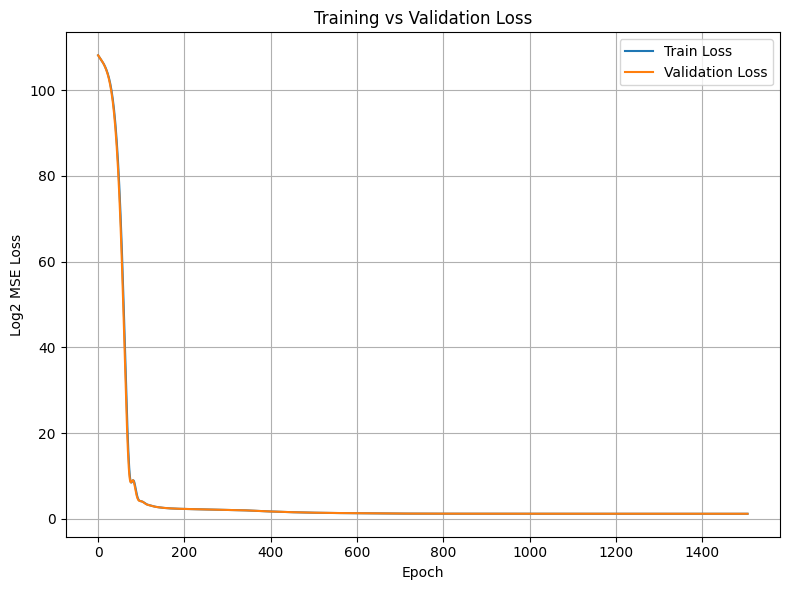

Test Loss: 1.1951
✅ Encoder-Decoder model saved as encoder_decoder_model.pth
✅ Scaler saved as scaler.pkl


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Filter for (n=9, k=4)
df_94 = grouped_dfs[(9, 4)].copy()

# Flatten P and create input features
def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_94.apply(preprocess, axis=1))
y = df_94['result'].values
y_log = np.log2(np.clip(y, 1e-6, None))  # log2-transformed targets

# Train-val-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Log2_mse_loss function
def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

# Encoder-Decoder model
class EncoderDecoder(nn.Module):
    def __init__(self, input_dim=39, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# Instantiate model
ed_model = EncoderDecoder().to(device)

optimizer = optim.Adam(ed_model.parameters(), lr=0.001)
num_epochs = 3000

# Early stopping parameters
patience = 20            # epochs to wait before stopping
min_delta = 1e-4         # minimum change to qualify as an improvement
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # Train the model
    ed_model.train()
    y_pred = ed_model(X_train)
    loss = log2_mse_loss(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validate the model
    ed_model.eval()
    with torch.no_grad():
        val_pred = ed_model(X_val)
        val_loss = log2_mse_loss(val_pred, y_val)

    # Record losses every epoch
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    # Early stopping check
    if val_loss.item() + min_delta < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = ed_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
        break

# Load best model weights after training
if best_model_state is not None:
    ed_model.load_state_dict(best_model_state)

# ✅ Plot Train vs Validation Loss
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log2 MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test encoder-decoder model
ed_model.eval()
with torch.no_grad():
    test_pred = ed_model(X_test)
    test_loss = log2_mse_loss(test_pred, y_test)

print(f"Test Loss: {test_loss:.4f}")

# Save the trained Encoder-Decoder model
torch.save(ed_model.state_dict(), f"9_4_encoder_decoder_model.pth")
print("✅ Encoder-Decoder model saved as encoder_decoder_model.pth")

# Save the fitted StandardScaler
joblib.dump(scaler, "9_4_scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

# MLP Classifier Model Training

Epoch 0 | Train Loss: 3.0948 | Val Acc: 0.0491
Epoch 10 | Train Loss: 2.9678 | Val Acc: 0.0493
Epoch 20 | Train Loss: 2.9141 | Val Acc: 0.0488
Epoch 30 | Train Loss: 2.8784 | Val Acc: 0.0492
Early stopping at epoch 32 with best val acc 0.0496
Test Accuracy: 0.0506
✅ Classifier model saved as classifier_mlp_model.pth


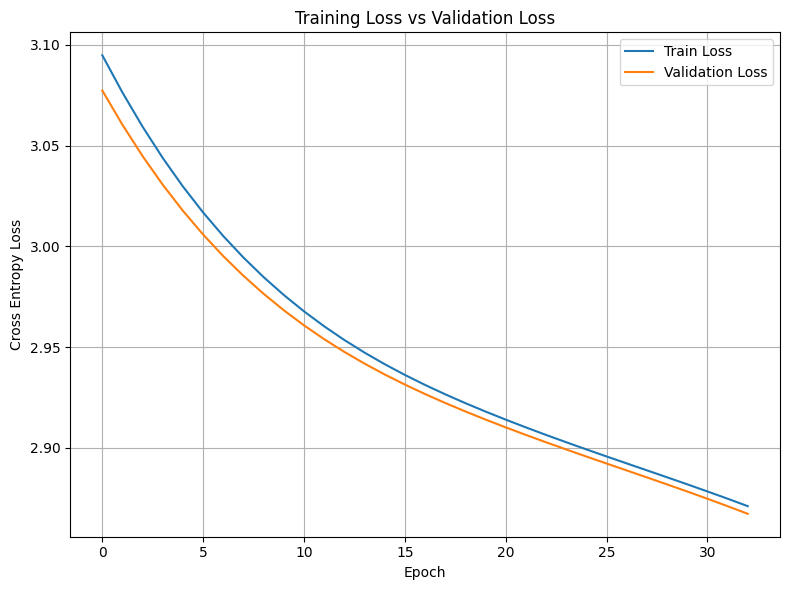

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

# Get encoder-only model
trained_encoder = ed_model.encoder

# Get original `result` values for (9,4)
result_values = df_94['result'].values

# Create 20 quantile-based classes
df_94['class'] = pd.qcut(np.log2(result_values), q=20, labels=False, duplicates='drop')

# Recreate input features
X_full = np.vstack(df_94.apply(preprocess, axis=1))
X_full_scaled = scaler.transform(X_full)  # Use same scaler from before
X_full_tensor = torch.tensor(X_full_scaled, dtype=torch.float32).to(device)

# Get encoder outputs (compressed representation)
with torch.no_grad():
    compressed_reps = trained_encoder(X_full_tensor).cpu().numpy()

# Prepare class labels
class_labels = df_94['class'].values
label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(class_labels)

# Train/val/test split on new classifier dataset
X_cls_temp, X_cls_test, y_cls_temp, y_cls_test = train_test_split(compressed_reps, y_classes, test_size=0.15, random_state=42)
X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(X_cls_temp, y_cls_temp, test_size=0.1765, random_state=42)

# Convert to tensors
X_cls_train = torch.tensor(X_cls_train, dtype=torch.float32).to(device)
X_cls_val = torch.tensor(X_cls_val, dtype=torch.float32).to(device)
X_cls_test = torch.tensor(X_cls_test, dtype=torch.float32).to(device)

y_cls_train = torch.tensor(y_cls_train, dtype=torch.long).to(device)
y_cls_val = torch.tensor(y_cls_val, dtype=torch.long).to(device)
y_cls_test = torch.tensor(y_cls_test, dtype=torch.long).to(device)

# Define MLP classifier
class ClassifierMLP(nn.Module):
    def __init__(self, input_dim=16, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
clf_model = ClassifierMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=0.001)

# Early stopping parameters
patience = 20
best_val_acc = 0.0
epochs_no_improve = 0
min_delta = 1e-4
best_model_state = None

# Initialize lists to store training loss and validation accuracy
train_losses = []
val_losses = []

for epoch in range(100):

    # Train classifier
    clf_model.train()
    outputs = clf_model(X_cls_train)
    loss = criterion(outputs, y_cls_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validate classifier
    clf_model.eval()
    with torch.no_grad():
        val_outputs = clf_model(X_cls_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_loss = criterion(val_outputs, y_cls_val)  # Validation loss
        val_acc = accuracy_score(y_cls_val.cpu(), val_preds.cpu())

    # Store training and validation loss
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Print every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping check
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_model_state = clf_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val acc {best_val_acc:.4f}")
        break

# Load best model
if best_model_state:
    clf_model.load_state_dict(best_model_state)

# Test classifier model
clf_model.eval()
with torch.no_grad():
    test_outputs = clf_model(X_cls_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = accuracy_score(y_cls_test.cpu(), test_preds.cpu())

print(f"Test Accuracy: {test_acc:.4f}")

torch.save(clf_model.state_dict(), "9_4_classifier_mlp_model.pth")
print("✅ Classifier model saved as classifier_mlp_model.pth")

# ✅ Plot Train Loss vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MLP Regressor Model Training


🔧 Training Regressor for class 0...
  Epoch 0 | Val log2-loss: 43.2544
  Epoch 100 | Val log2-loss: 0.9106
  Early stopping at epoch 131 with best val loss 0.8039
Test log2-loss: 0.7962


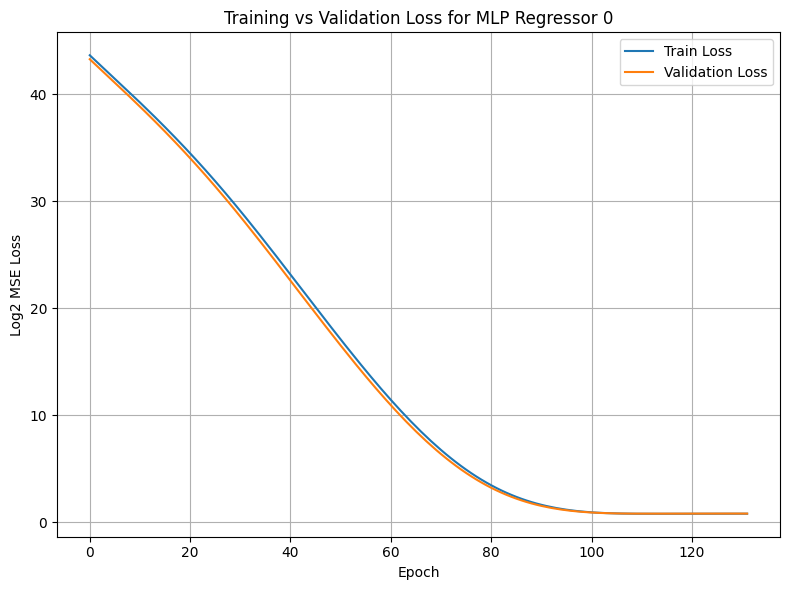


🔧 Training Regressor for class 1...
  Epoch 0 | Val log2-loss: 46.0592
  Epoch 100 | Val log2-loss: 1.0430
  Early stopping at epoch 141 with best val loss 0.6771
Test log2-loss: 0.6787


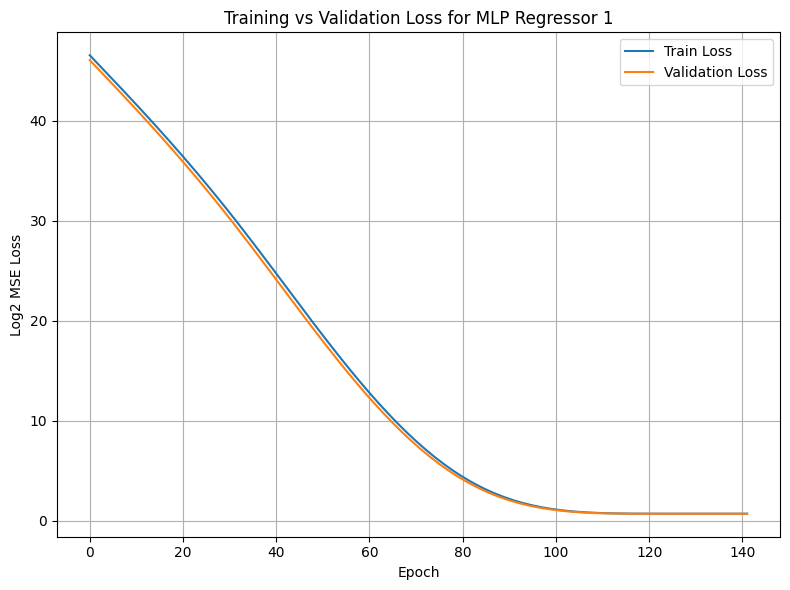


🔧 Training Regressor for class 2...
  Epoch 0 | Val log2-loss: 54.9663
  Epoch 100 | Val log2-loss: 3.1749
  Epoch 200 | Val log2-loss: 0.9606
  Epoch 300 | Val log2-loss: 0.9207
  Epoch 400 | Val log2-loss: 0.8706
  Epoch 500 | Val log2-loss: 0.8151
  Epoch 600 | Val log2-loss: 0.7551
  Epoch 700 | Val log2-loss: 0.6882
  Epoch 800 | Val log2-loss: 0.6126
  Epoch 900 | Val log2-loss: 0.5269
  Epoch 1000 | Val log2-loss: 0.4336
  Epoch 1100 | Val log2-loss: 0.3383
  Epoch 1200 | Val log2-loss: 0.2468
  Epoch 1300 | Val log2-loss: 0.1681
  Epoch 1400 | Val log2-loss: 0.1092
  Epoch 1500 | Val log2-loss: 0.0710
  Epoch 1600 | Val log2-loss: 0.0490
  Epoch 1700 | Val log2-loss: 0.0366
  Epoch 1800 | Val log2-loss: 0.0293
  Epoch 1900 | Val log2-loss: 0.0245
  Epoch 2000 | Val log2-loss: 0.0210
  Epoch 2100 | Val log2-loss: 0.0183
  Epoch 2200 | Val log2-loss: 0.0161
  Epoch 2300 | Val log2-loss: 0.0144
  Epoch 2400 | Val log2-loss: 0.0129
  Epoch 2500 | Val log2-loss: 0.0117
  Epoch 2600

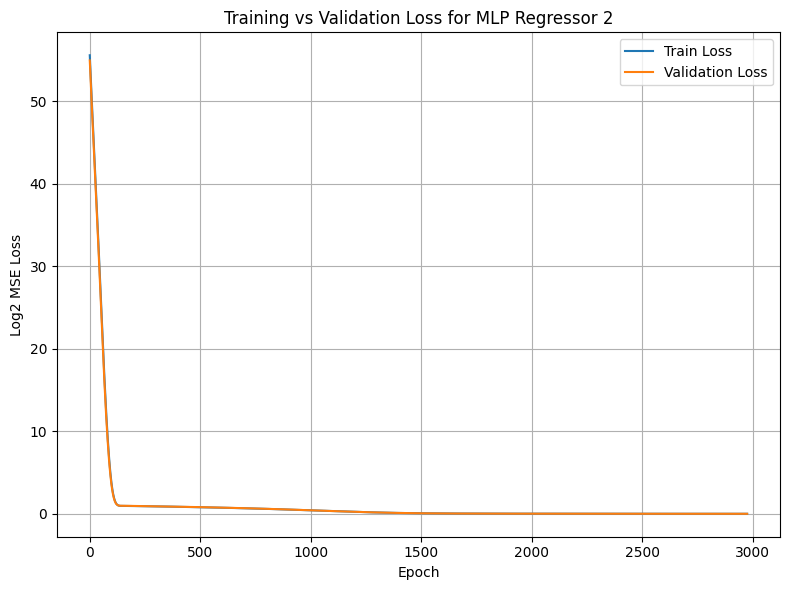


🔧 Training Regressor for class 3...
  Epoch 0 | Val log2-loss: 51.5770
  Epoch 100 | Val log2-loss: 2.3234
  Epoch 200 | Val log2-loss: 1.3230
  Epoch 300 | Val log2-loss: 1.2506
  Epoch 400 | Val log2-loss: 1.1672
  Epoch 500 | Val log2-loss: 1.0668
  Epoch 600 | Val log2-loss: 0.9288
  Epoch 700 | Val log2-loss: 0.7151
  Epoch 800 | Val log2-loss: 0.4357
  Epoch 900 | Val log2-loss: 0.2132
  Epoch 1000 | Val log2-loss: 0.1027
  Epoch 1100 | Val log2-loss: 0.0612
  Epoch 1200 | Val log2-loss: 0.0441
  Epoch 1300 | Val log2-loss: 0.0344
  Epoch 1400 | Val log2-loss: 0.0276
  Epoch 1500 | Val log2-loss: 0.0225
  Epoch 1600 | Val log2-loss: 0.0185
  Epoch 1700 | Val log2-loss: 0.0154
  Epoch 1800 | Val log2-loss: 0.0130
  Epoch 1900 | Val log2-loss: 0.0111
  Epoch 2000 | Val log2-loss: 0.0097
  Epoch 2100 | Val log2-loss: 0.0087
  Epoch 2200 | Val log2-loss: 0.0079
  Epoch 2300 | Val log2-loss: 0.0073
  Early stopping at epoch 2308 with best val loss 0.0074
Test log2-loss: 0.0073


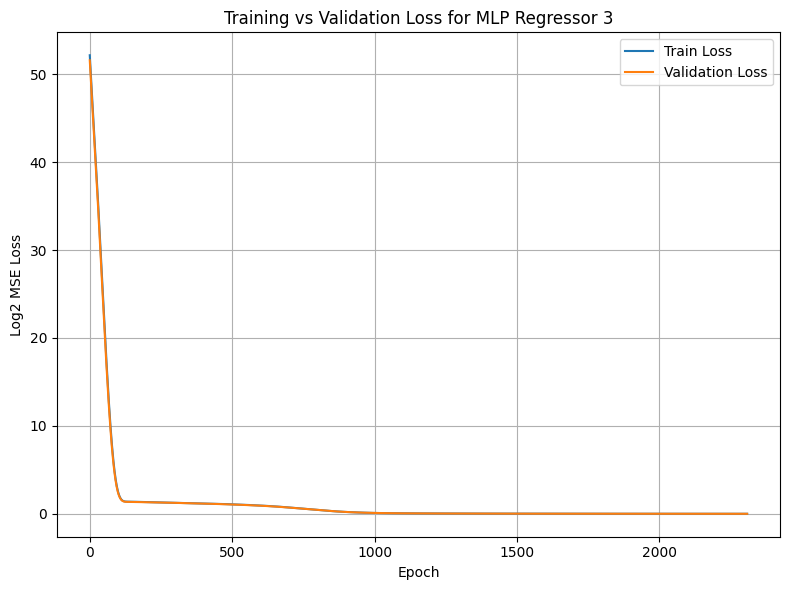


🔧 Training Regressor for class 4...
  Epoch 0 | Val log2-loss: 57.0736
  Epoch 100 | Val log2-loss: 2.6030
  Epoch 200 | Val log2-loss: 1.4851
  Epoch 300 | Val log2-loss: 1.3689
  Epoch 400 | Val log2-loss: 1.1953
  Epoch 500 | Val log2-loss: 0.9577
  Epoch 600 | Val log2-loss: 0.6993
  Epoch 700 | Val log2-loss: 0.4738
  Epoch 800 | Val log2-loss: 0.3089
  Epoch 900 | Val log2-loss: 0.2044
  Epoch 1000 | Val log2-loss: 0.1450
  Epoch 1100 | Val log2-loss: 0.1121
  Epoch 1200 | Val log2-loss: 0.0923
  Epoch 1300 | Val log2-loss: 0.0784
  Epoch 1400 | Val log2-loss: 0.0673
  Epoch 1500 | Val log2-loss: 0.0577
  Epoch 1600 | Val log2-loss: 0.0493
  Epoch 1700 | Val log2-loss: 0.0418
  Epoch 1800 | Val log2-loss: 0.0353
  Epoch 1900 | Val log2-loss: 0.0296
  Epoch 2000 | Val log2-loss: 0.0247
  Epoch 2100 | Val log2-loss: 0.0206
  Epoch 2200 | Val log2-loss: 0.0173
  Epoch 2300 | Val log2-loss: 0.0147
  Epoch 2400 | Val log2-loss: 0.0126
  Epoch 2500 | Val log2-loss: 0.0111
  Epoch 2600

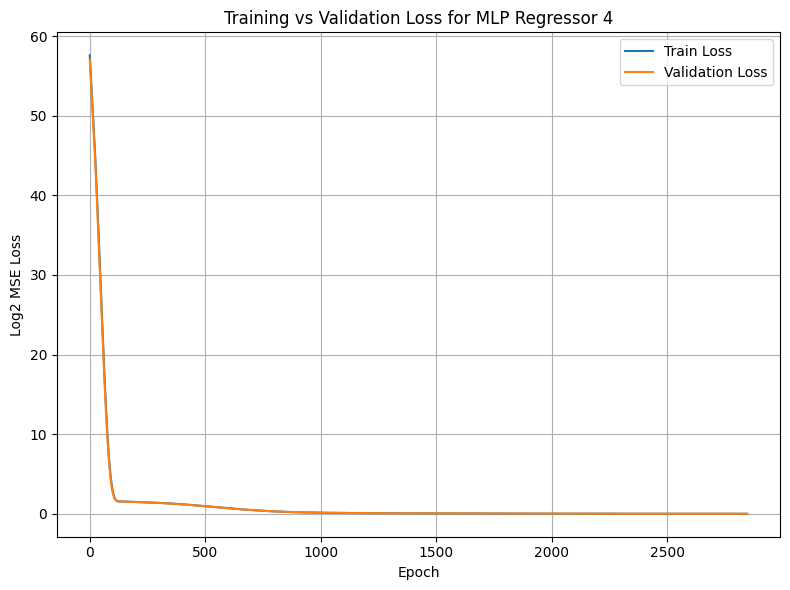


🔧 Training Regressor for class 5...
  Epoch 0 | Val log2-loss: 63.3574
  Epoch 100 | Val log2-loss: 1.8030
  Epoch 200 | Val log2-loss: 1.5829
  Epoch 300 | Val log2-loss: 1.4876
  Epoch 400 | Val log2-loss: 1.3773
  Epoch 500 | Val log2-loss: 1.2484
  Epoch 600 | Val log2-loss: 1.1134
  Epoch 700 | Val log2-loss: 0.9706
  Epoch 800 | Val log2-loss: 0.8112
  Epoch 900 | Val log2-loss: 0.6141
  Epoch 1000 | Val log2-loss: 0.3783
  Epoch 1100 | Val log2-loss: 0.1771
  Epoch 1200 | Val log2-loss: 0.0746
  Epoch 1300 | Val log2-loss: 0.0444
  Epoch 1400 | Val log2-loss: 0.0314
  Epoch 1500 | Val log2-loss: 0.0231
  Epoch 1600 | Val log2-loss: 0.0174
  Epoch 1700 | Val log2-loss: 0.0137
  Epoch 1800 | Val log2-loss: 0.0113
  Epoch 1900 | Val log2-loss: 0.0098
  Epoch 2000 | Val log2-loss: 0.0088
  Epoch 2100 | Val log2-loss: 0.0081
  Early stopping at epoch 2135 with best val loss 0.0081
Test log2-loss: 0.0079


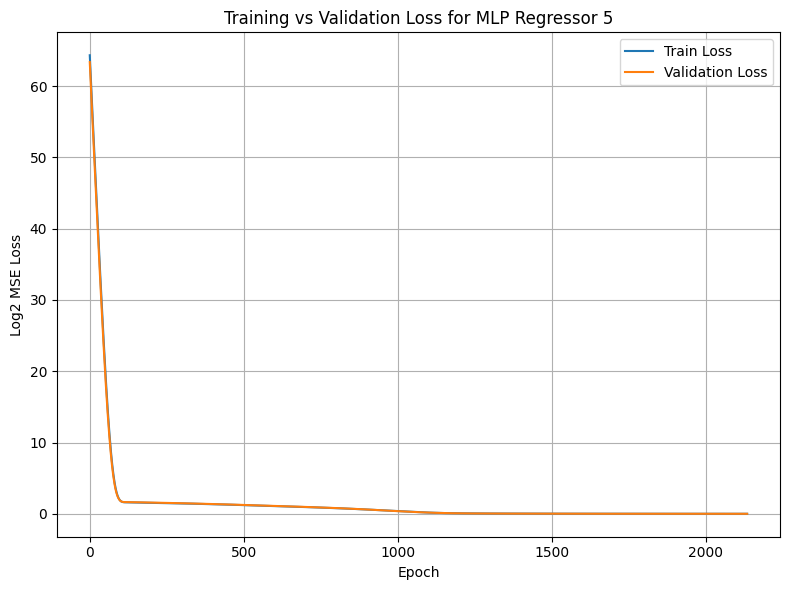


🔧 Training Regressor for class 6...
  Epoch 0 | Val log2-loss: 58.9737
  Epoch 100 | Val log2-loss: 1.3484
  Early stopping at epoch 117 with best val loss 1.3450
Test log2-loss: 1.3367


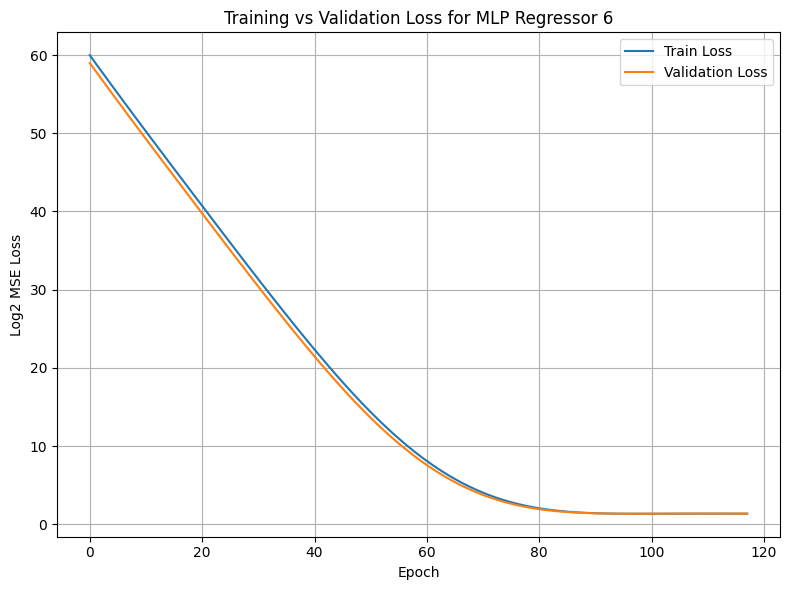


🔧 Training Regressor for class 7...
  Epoch 0 | Val log2-loss: 62.4808
  Epoch 100 | Val log2-loss: 1.3647
  Early stopping at epoch 136 with best val loss 0.9761
Test log2-loss: 0.9556


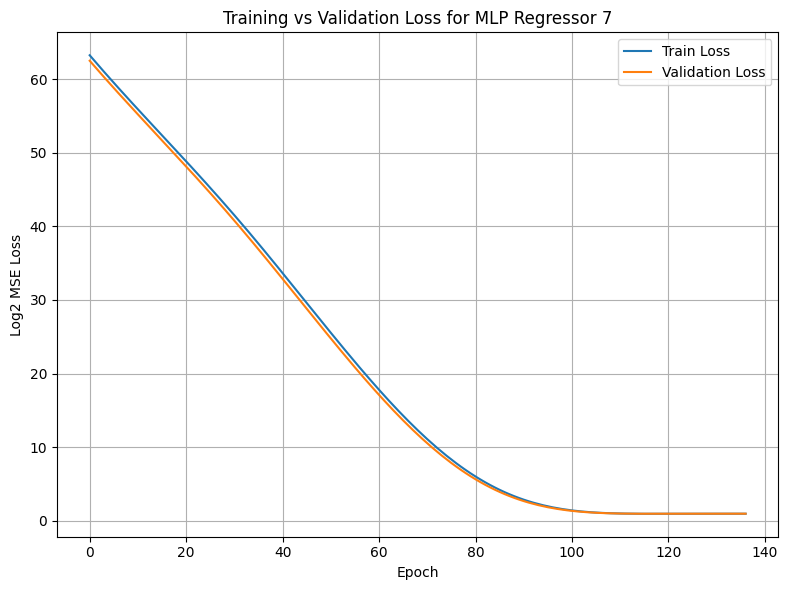


🔧 Training Regressor for class 8...
  Epoch 0 | Val log2-loss: 61.2274
  Epoch 100 | Val log2-loss: 1.3413
  Early stopping at epoch 113 with best val loss 1.3075
Test log2-loss: 1.3463


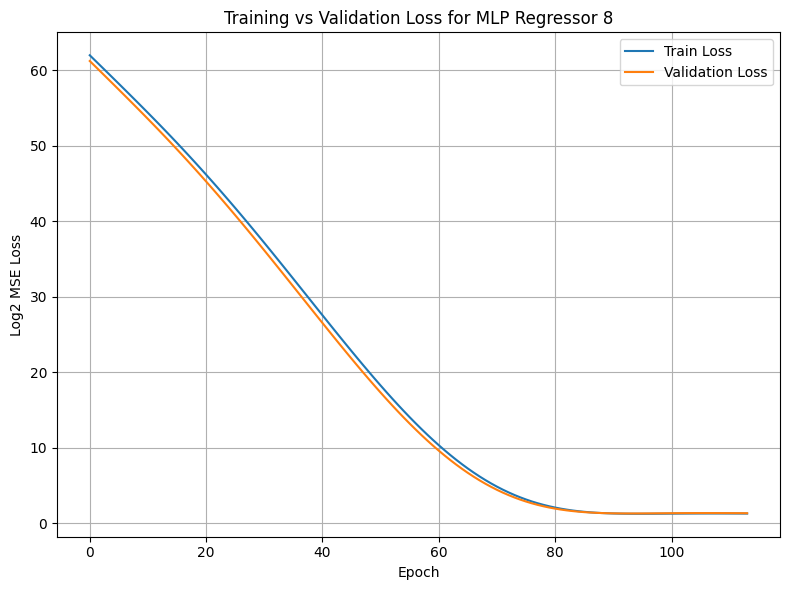


🔧 Training Regressor for class 9...
  Epoch 0 | Val log2-loss: 80.3482
  Epoch 100 | Val log2-loss: 5.9092
  Epoch 200 | Val log2-loss: 3.1916
  Epoch 300 | Val log2-loss: 2.8310
  Epoch 400 | Val log2-loss: 2.4508
  Epoch 500 | Val log2-loss: 2.0307
  Epoch 600 | Val log2-loss: 1.5646
  Epoch 700 | Val log2-loss: 1.0838
  Epoch 800 | Val log2-loss: 0.6828
  Epoch 900 | Val log2-loss: 0.4346
  Epoch 1000 | Val log2-loss: 0.3143
  Epoch 1100 | Val log2-loss: 0.2562
  Epoch 1200 | Val log2-loss: 0.2196
  Epoch 1300 | Val log2-loss: 0.1906
  Epoch 1400 | Val log2-loss: 0.1658
  Epoch 1500 | Val log2-loss: 0.1444
  Epoch 1600 | Val log2-loss: 0.1258
  Epoch 1700 | Val log2-loss: 0.1097
  Epoch 1800 | Val log2-loss: 0.0958
  Epoch 1900 | Val log2-loss: 0.0837
  Epoch 2000 | Val log2-loss: 0.0731
  Epoch 2100 | Val log2-loss: 0.0639
  Epoch 2200 | Val log2-loss: 0.0558
  Epoch 2300 | Val log2-loss: 0.0489
  Epoch 2400 | Val log2-loss: 0.0429
  Epoch 2500 | Val log2-loss: 0.0378
  Epoch 2600

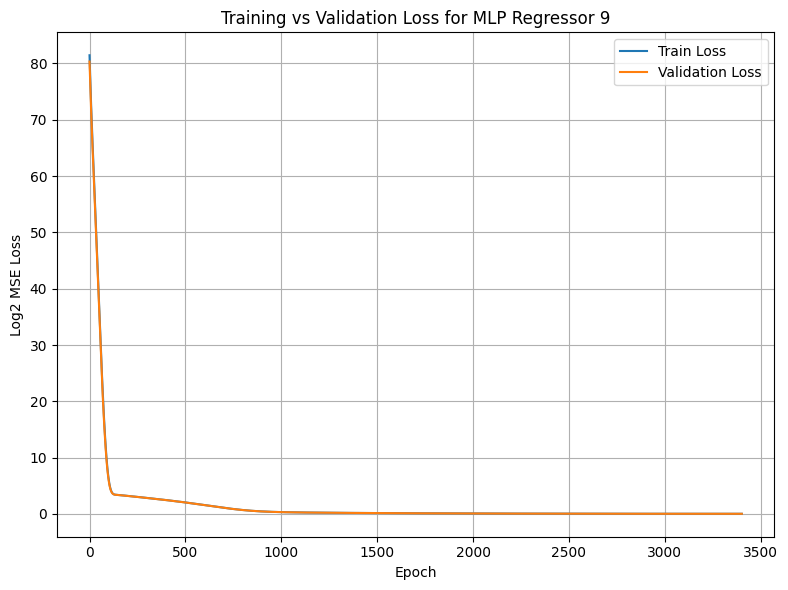


🔧 Training Regressor for class 10...
  Epoch 0 | Val log2-loss: 80.5366
  Epoch 100 | Val log2-loss: 2.5434
  Epoch 200 | Val log2-loss: 2.3075
  Epoch 300 | Val log2-loss: 1.9182
  Epoch 400 | Val log2-loss: 1.4468
  Epoch 500 | Val log2-loss: 1.0093
  Epoch 600 | Val log2-loss: 0.6724
  Epoch 700 | Val log2-loss: 0.4535
  Epoch 800 | Val log2-loss: 0.3277
  Epoch 900 | Val log2-loss: 0.2559
  Epoch 1000 | Val log2-loss: 0.2099
  Epoch 1100 | Val log2-loss: 0.1754
  Epoch 1200 | Val log2-loss: 0.1465
  Epoch 1300 | Val log2-loss: 0.1210
  Epoch 1400 | Val log2-loss: 0.0985
  Epoch 1500 | Val log2-loss: 0.0791
  Epoch 1600 | Val log2-loss: 0.0629
  Epoch 1700 | Val log2-loss: 0.0499
  Epoch 1800 | Val log2-loss: 0.0401
  Epoch 1900 | Val log2-loss: 0.0329
  Epoch 2000 | Val log2-loss: 0.0279
  Epoch 2100 | Val log2-loss: 0.0244
  Epoch 2200 | Val log2-loss: 0.0221
  Epoch 2300 | Val log2-loss: 0.0206
  Epoch 2400 | Val log2-loss: 0.0195
  Epoch 2500 | Val log2-loss: 0.0188
  Early sto

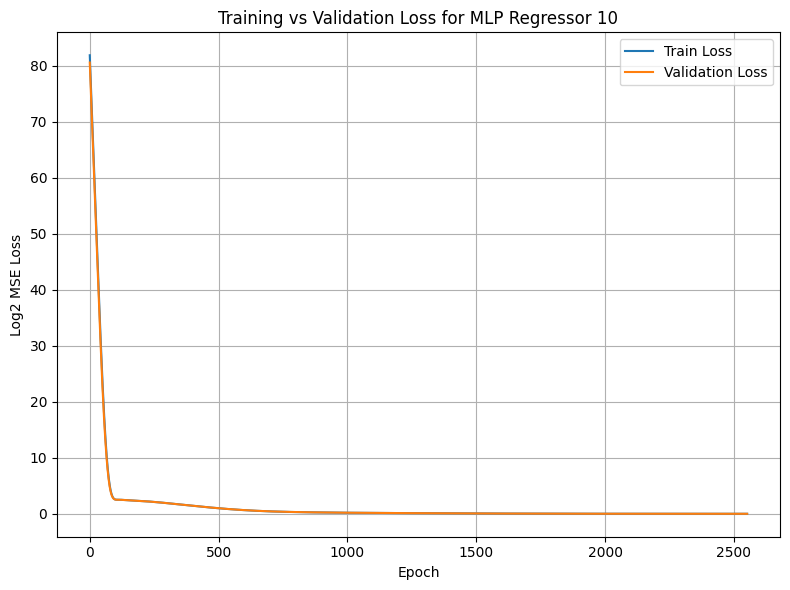


🔧 Training Regressor for class 11...
  Epoch 0 | Val log2-loss: 92.1197
  Epoch 100 | Val log2-loss: 1.3802
  Early stopping at epoch 121 with best val loss 1.3795
Test log2-loss: 1.4283


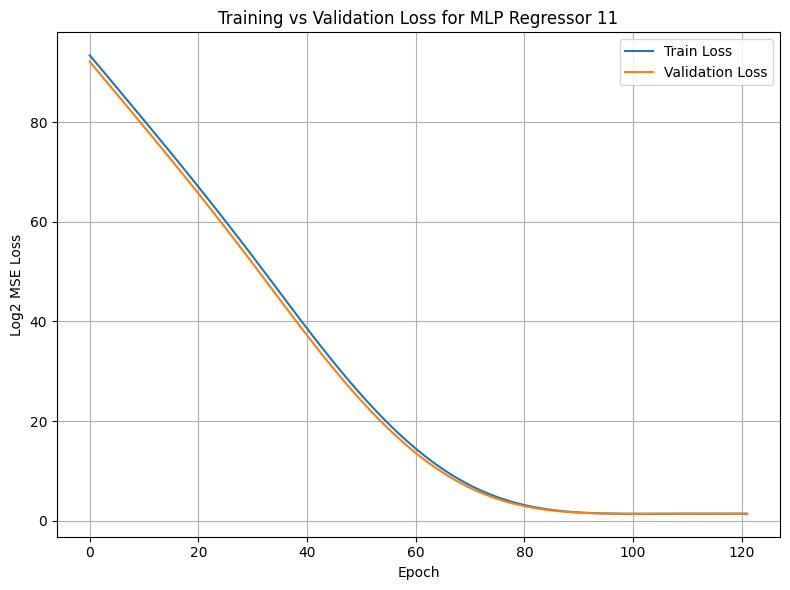


🔧 Training Regressor for class 12...
  Epoch 0 | Val log2-loss: 88.6042
  Epoch 100 | Val log2-loss: 0.8802
  Early stopping at epoch 110 with best val loss 0.8311
Test log2-loss: 0.9344


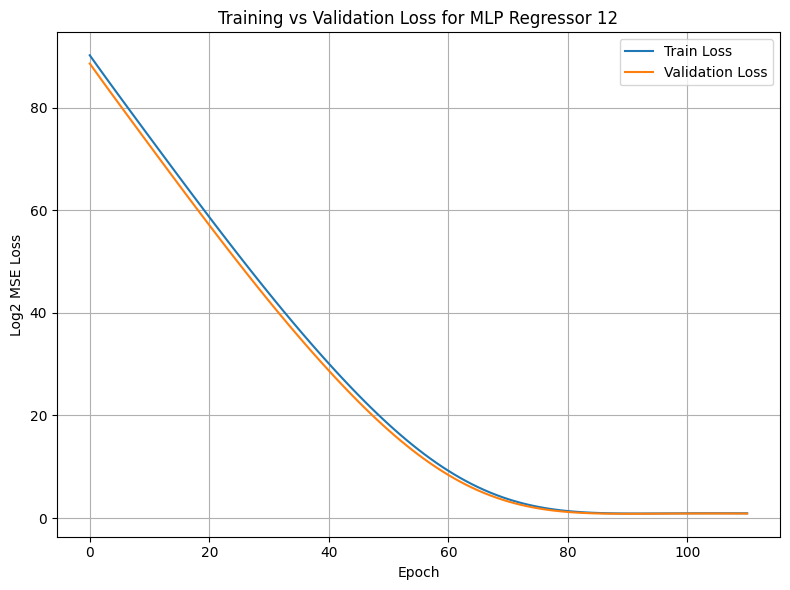


🔧 Training Regressor for class 13...
  Epoch 0 | Val log2-loss: 98.1937
  Epoch 100 | Val log2-loss: 0.8489
  Early stopping at epoch 112 with best val loss 0.8070
Test log2-loss: 0.8441


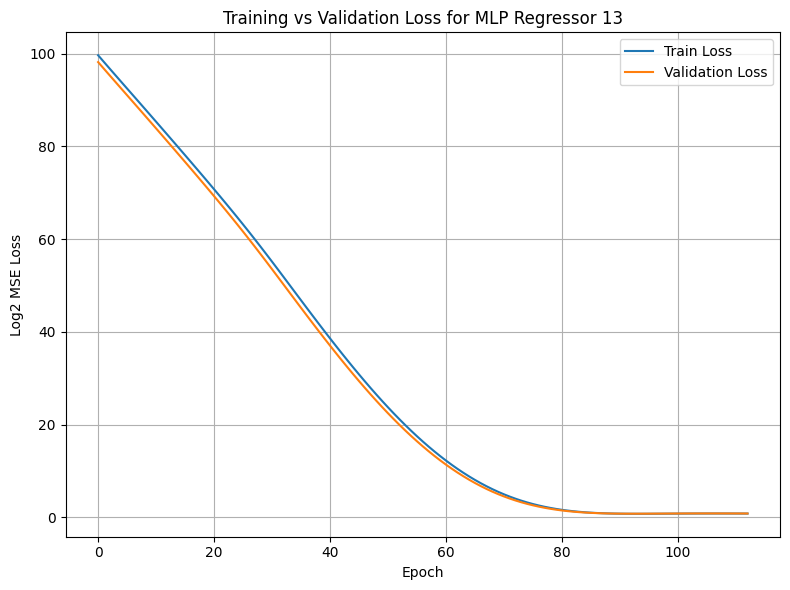


🔧 Training Regressor for class 14...
  Epoch 0 | Val log2-loss: 119.1327
  Epoch 100 | Val log2-loss: 3.9189
  Early stopping at epoch 108 with best val loss 3.8378
Test log2-loss: 3.8654


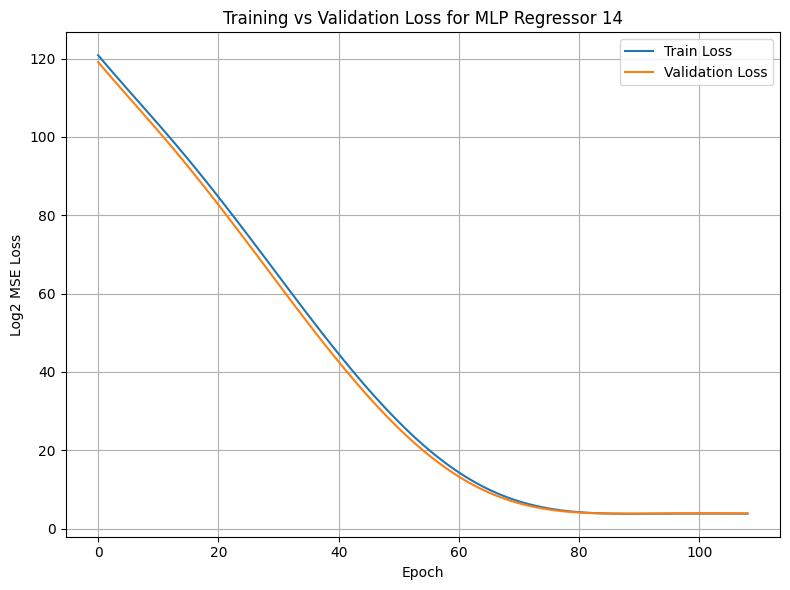


🔧 Training Regressor for class 15...
  Epoch 0 | Val log2-loss: 171.7582
  Epoch 100 | Val log2-loss: 2.5719
  Early stopping at epoch 130 with best val loss 2.4218
Test log2-loss: 2.3156


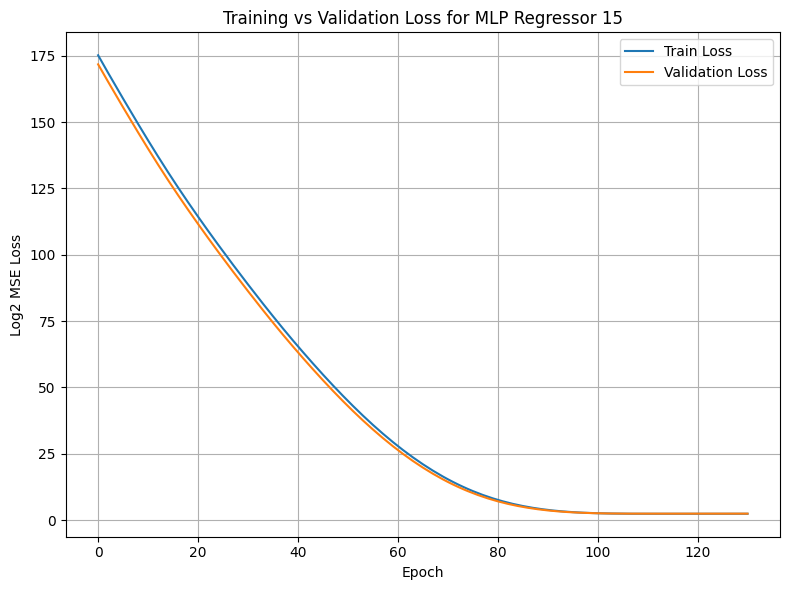


🔧 Training Regressor for class 16...
  Epoch 0 | Val log2-loss: 153.2426
  Epoch 100 | Val log2-loss: 1.0616
  Early stopping at epoch 110 with best val loss 0.9789
Test log2-loss: 0.9899


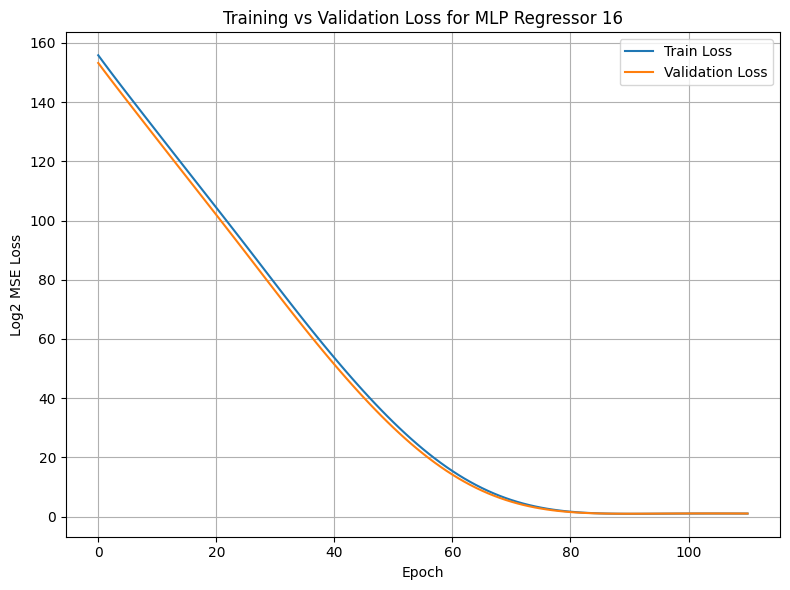


🔧 Training Regressor for class 17...
  Epoch 0 | Val log2-loss: 186.5319
  Epoch 100 | Val log2-loss: 0.7062
  Early stopping at epoch 118 with best val loss 0.7000
Test log2-loss: 0.7393


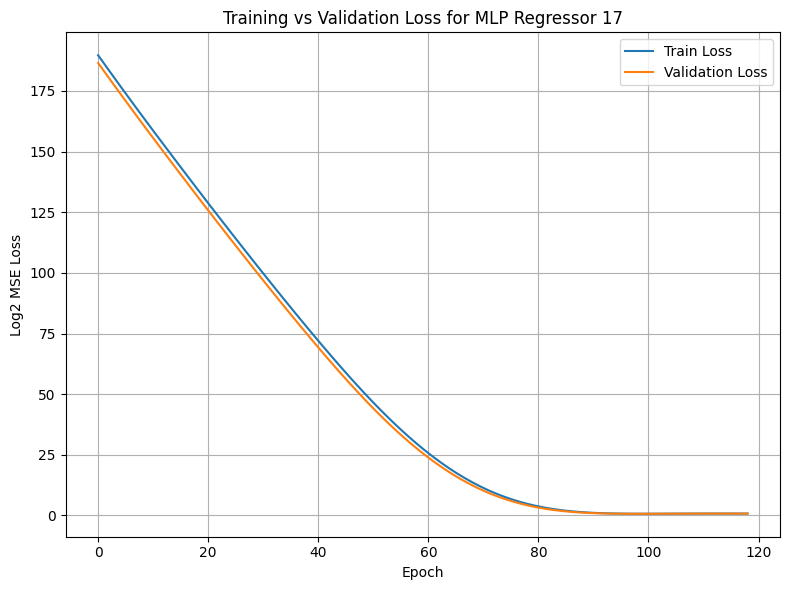


🔧 Training Regressor for class 18...
  Epoch 0 | Val log2-loss: 266.1322
  Epoch 100 | Val log2-loss: 8.2504
  Early stopping at epoch 151 with best val loss 0.7239
Test log2-loss: 0.7502


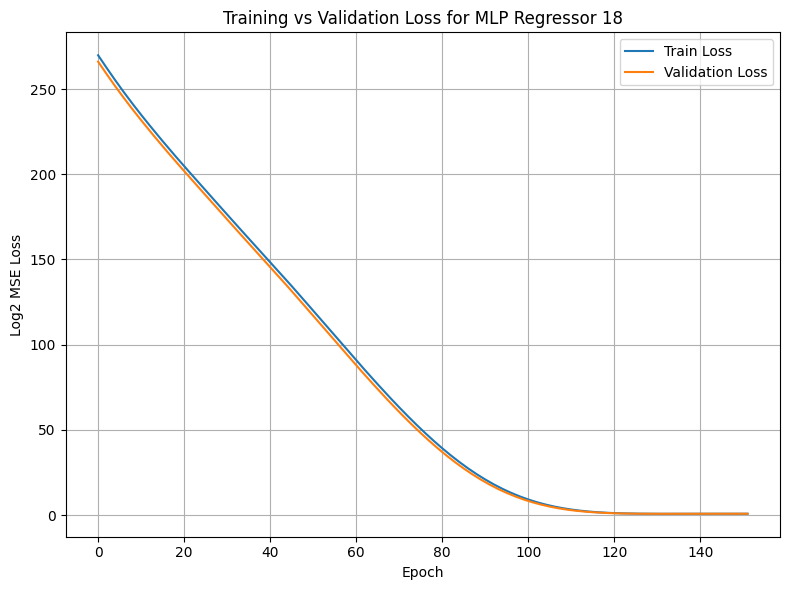


🔧 Training Regressor for class 19...
  Epoch 0 | Val log2-loss: 304.7786
  Epoch 100 | Val log2-loss: 3.3028
  Early stopping at epoch 130 with best val loss 2.7929
Test log2-loss: 2.9073


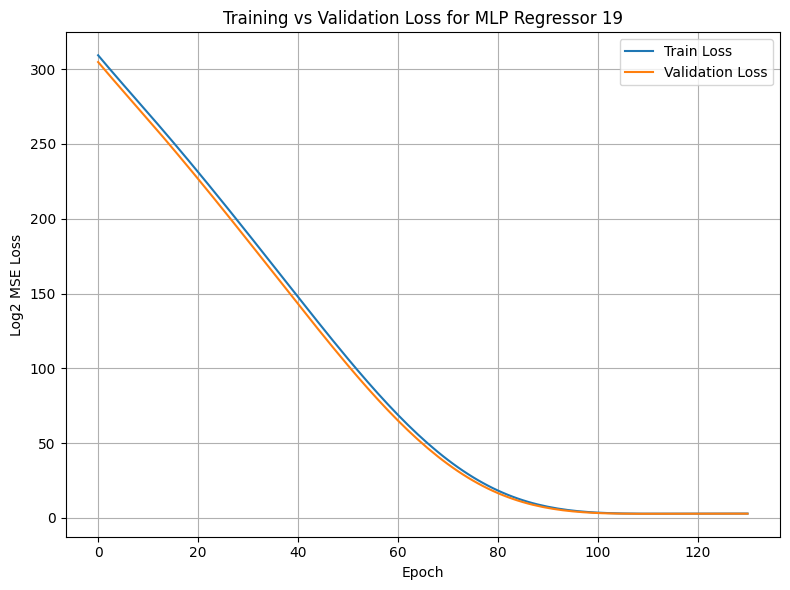

✅ Saved MLP regressors at 9_4_MLP_regressor_models


In [ ]:
import matplotlib.pyplot as plt
import torch
import os

regressors = {}

# Reuse the compressed encoder representations obtained from last step
compressed_reps_tensor = torch.tensor(compressed_reps, dtype=torch.float32).to(device)
log_result_values = np.log2(np.clip(df_94['result'].values, 1e-6, None))
log_result_tensor = torch.tensor(log_result_values, dtype=torch.float32).view(-1, 1).to(device)

# Define MLP Regressor
class MLPRegressor(nn.Module):
    def __init__(self, input_dim=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)

# Log2-based loss
def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

# For each of 20 qcut classes
for class_id in range(20):
    print(f"\n🔧 Training Regressor for class {class_id}...")
    class_mask = df_94['class'].values == class_id

    # Select compressed representations and log-transformed targets for the current class
    X_class = compressed_reps_tensor[class_mask]
    y_class = log_result_tensor[class_mask]

    # Skip if not enough data
    if X_class.size(0) < 10:
        print(f"  Skipping class {class_id} (too few samples)")
        continue

    # Train-val-test split
    X_temp, X_test, y_temp, y_test = train_test_split(X_class, y_class, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

    # Instantiate model
    reg_model = MLPRegressor().to(device)
    optimizer = optim.Adam(reg_model.parameters(), lr=0.001)

    # Early stopping
    best_val_loss = float('inf')
    patience = 20
    epochs_no_improve = 0
    min_delta = 1e-4
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(10000):

        # Train regressor
        reg_model.train()
        y_pred = reg_model(X_train)
        loss = log2_mse_loss(y_pred,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validate regressor
        reg_model.eval()
        with torch.no_grad():
            val_pred = reg_model(X_val)
            val_loss = log2_mse_loss(val_pred, y_val)  # Eval on 2^x scale

        # Store training and validation loss
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Print every 100 epochs
        if epoch % 100 == 0:
            print(f"  Epoch {epoch} | Val log2-loss: {val_loss.item():.4f}")

        # Early stopping check
        if val_loss.item() + min_delta < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = reg_model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
            break

    # Save model
    if best_model_state:
        reg_model.load_state_dict(best_model_state)
    regressors[class_id] = reg_model

    # Test regerssor model
    reg_model.eval()
    with torch.no_grad():
        test_pred = reg_model(X_test)
        test_loss = log2_mse_loss(test_pred, y_test)  # Eval on 2^x scale

    print(f"Test log2-loss: {test_loss.item():.4f}")

    # ✅ Plot Train vs Validation Loss
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log2 MSE Loss")
    plt.title(f"Training vs Validation Loss for MLP Regressor {class_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a directory to store all regressors
os.makedirs("9_4_MLP_regressor_models", exist_ok=True)

# Save each regressor model separately
for class_id, model in regressors.items():
    model_path = f"9_4_MLP_regressor_models/9_4_MLP_regressor_{class_id}.pth"
    torch.save(model.state_dict(), model_path)

print(f"✅ Saved MLP regressors at 9_4_MLP_regressor_models")

# Final Model Testing

In [ ]:
df_94_test = grouped_dfs[(9, 4)].copy()

# Flatten P and create input features
def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_94_test.apply(preprocess, axis=1))
y = df_94_test['result'].values

# Train-val-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_full_scaled_test = scaler.transform(X_test)  # Use same scaler from before
X_full_tensor_test = torch.tensor(X_full_scaled_test, dtype=torch.float32).to(device) # Convert to tensor

# Generate and prepare compressed representations of the test inputs using the trained encoder
with torch.no_grad():
    compressed_reps_test = trained_encoder(X_full_tensor_test).cpu().numpy()
compressed_reps_test_tensor = torch.tensor(compressed_reps_test, dtype=torch.float32).to(device)

# Predict class labels for the test compressed representations using the trained classifier
clf_model.eval()
with torch.no_grad():
    test_outputs_clf = clf_model(compressed_reps_test_tensor)
    test_pred_clf = torch.argmax(test_outputs_clf, dim=1).cpu().numpy()

y_true_actual = y_test
y_pred_actual = []

for i in range(len(X_test)):
    class_id = int(test_pred_clf[i])

    if class_id not in regressors:
        # If that class wasn't trained (e.g. due to low sample size), skip or use fallback
        y_pred_actual.append(0.0)
        continue

    # Retrieve regressor based on class_id
    regressor = regressors[class_id]
    regressor.eval()

    input_tensor = compressed_reps_test_tensor[i].unsqueeze(0)

    with torch.no_grad():
        log_pred = regressor(input_tensor)  # output is log2(result)
        pred_value = torch.pow(2.0, log_pred).item()  # convert back to result scale

    # Append the final predicted result value to the predictions list
    y_pred_actual.append(pred_value)

y_pred_actual = np.array(y_pred_actual)
y_true_actual = np.clip(y_true_actual, 1e-6, None) # Clip true result values to avoid extremely small or zero values

# Compute log2-based MSE loss
def log2_mse_np(y_true, y_pred):
    y_true = np.clip(y_true, 1e-6, None)
    y_pred = np.clip(y_pred, 1e-6, None)
    return np.mean((np.log2(y_true) - np.log2(y_pred)) ** 2)

test_log2_loss = log2_mse_np(y_true_actual, y_pred_actual)
print(f"✅ Final Test Log2 Loss: {test_log2_loss:.4f}")

✅ Final Test Log2 Loss: 4.8542


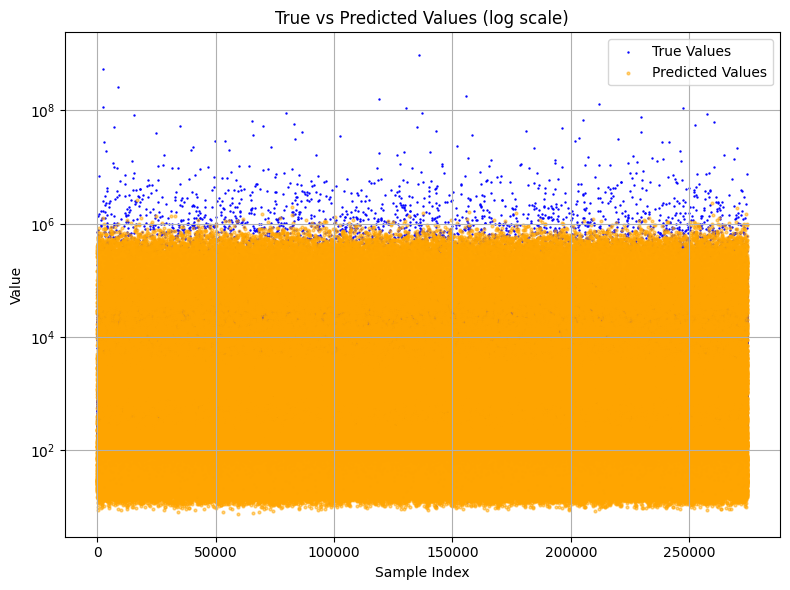

In [ ]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays in case they're not already
y_true = np.array(y_true_actual)
y_pred = np.array(y_pred_actual)

plt.figure(figsize=(8, 6))

# Plot true values in blue
plt.scatter(range(len(y_true)), y_true, label='True Values', color='blue', alpha=1, s=0.5)

# Plot predicted values in orange
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.5, s=4)

plt.title('True vs Predicted Values (log scale)')
plt.yscale('log')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Training for (9,5)

# Encoder Decoder Model Training

Using device: cuda
Epoch 0 | Train Loss: 132.6523 | Val Loss: 132.5259
Epoch 100 | Train Loss: 3.8835 | Val Loss: 3.8208
Epoch 200 | Train Loss: 2.5035 | Val Loss: 2.5013
Epoch 300 | Train Loss: 2.2921 | Val Loss: 2.2894
Epoch 400 | Train Loss: 1.9402 | Val Loss: 1.9371
Epoch 500 | Train Loss: 1.7575 | Val Loss: 1.7545
Epoch 600 | Train Loss: 1.5796 | Val Loss: 1.5770
Epoch 700 | Train Loss: 1.5247 | Val Loss: 1.5223
Epoch 800 | Train Loss: 1.5163 | Val Loss: 1.5139
Epoch 900 | Train Loss: 1.5141 | Val Loss: 1.5116
Epoch 1000 | Train Loss: 1.5129 | Val Loss: 1.5104
Epoch 1100 | Train Loss: 1.5121 | Val Loss: 1.5096
Early stopping at epoch 1113 with best val loss 1.5096


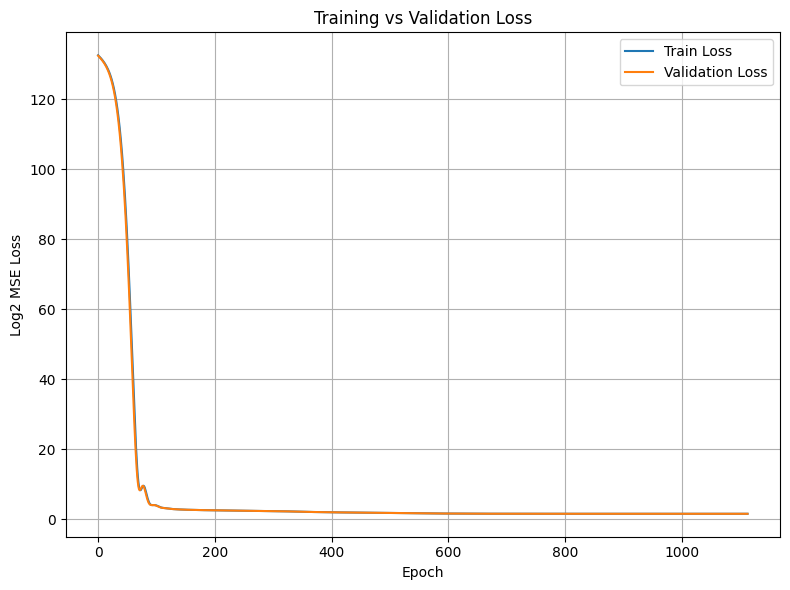

Test Loss: 1.5066
✅ Encoder-Decoder model saved as encoder_decoder_model.pth
✅ Scaler saved as scaler.pkl


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

df_95 = grouped_dfs[(9, 5)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_95.apply(preprocess, axis=1))
y = df_95['result'].values
y_log = np.log2(np.clip(y, 1e-6, None))

X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

class EncoderDecoder(nn.Module):
    def __init__(self, input_dim=48, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

ed_model = EncoderDecoder().to(device)

optimizer = optim.Adam(ed_model.parameters(), lr=0.001)
num_epochs = 3000

patience = 20
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ed_model.train()
    y_pred = ed_model(X_train)
    loss = log2_mse_loss(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ed_model.eval()
    with torch.no_grad():
        val_pred = ed_model(X_val)
        val_loss = log2_mse_loss(val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    if val_loss.item() + min_delta < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = ed_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
        break

if best_model_state is not None:
    ed_model.load_state_dict(best_model_state)

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log2 MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ed_model.eval()
with torch.no_grad():
    test_pred = ed_model(X_test)
    test_loss = log2_mse_loss(test_pred, y_test)

print(f"Test Loss: {test_loss:.4f}")

torch.save(ed_model.state_dict(), f"9_5_encoder_decoder_model.pth")
print("✅ Encoder-Decoder model saved as encoder_decoder_model.pth")

joblib.dump(scaler, "9_5_scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

# MLP Classifier Model Training

Epoch 0 | Train Loss: 3.0359 | Val Acc: 0.0497
Epoch 10 | Train Loss: 2.9473 | Val Acc: 0.0567
Epoch 20 | Train Loss: 2.9073 | Val Acc: 0.0508
Epoch 30 | Train Loss: 2.8774 | Val Acc: 0.0517
Early stopping at epoch 31 with best val acc 0.0582
Test Accuracy: 0.0514
✅ Classifier model saved as classifier_mlp_model.pth


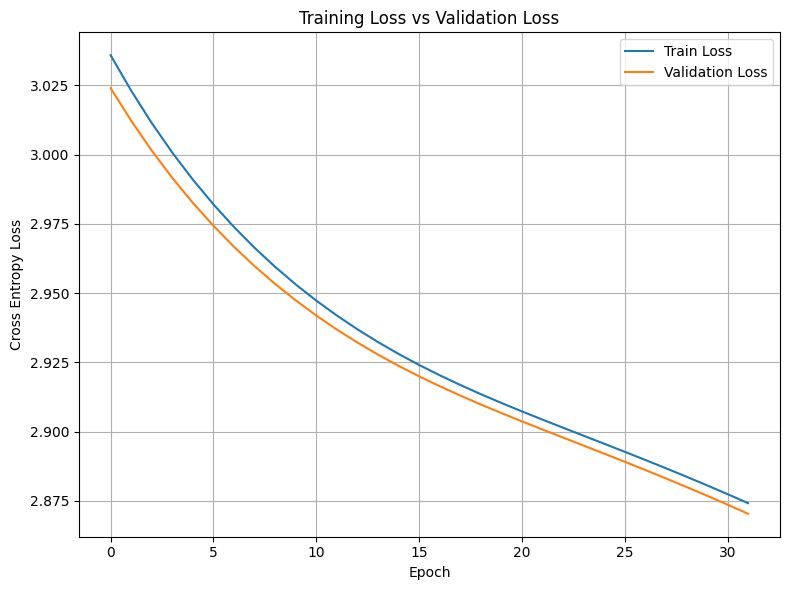

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

trained_encoder = ed_model.encoder

result_values = df_95['result'].values

df_95['class'] = pd.qcut(np.log2(result_values), q=20, labels=False, duplicates='drop')

X_full = np.vstack(df_95.apply(preprocess, axis=1))
X_full_scaled = scaler.transform(X_full)
X_full_tensor = torch.tensor(X_full_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps = trained_encoder(X_full_tensor).cpu().numpy()

class_labels = df_95['class'].values
label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(class_labels)

X_cls_temp, X_cls_test, y_cls_temp, y_cls_test = train_test_split(compressed_reps, y_classes, test_size=0.15, random_state=42)
X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(X_cls_temp, y_cls_temp, test_size=0.1765, random_state=42)

X_cls_train = torch.tensor(X_cls_train, dtype=torch.float32).to(device)
X_cls_val = torch.tensor(X_cls_val, dtype=torch.float32).to(device)
X_cls_test = torch.tensor(X_cls_test, dtype=torch.float32).to(device)

y_cls_train = torch.tensor(y_cls_train, dtype=torch.long).to(device)
y_cls_val = torch.tensor(y_cls_val, dtype=torch.long).to(device)
y_cls_test = torch.tensor(y_cls_test, dtype=torch.long).to(device)

class ClassifierMLP(nn.Module):
    def __init__(self, input_dim=16, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

clf_model = ClassifierMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=0.001)

patience = 20
best_val_acc = 0.0
epochs_no_improve = 0
min_delta = 1e-4
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(100):
    clf_model.train()
    outputs = clf_model(X_cls_train)
    loss = criterion(outputs, y_cls_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    clf_model.eval()
    with torch.no_grad():
        val_outputs = clf_model(X_cls_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_loss = criterion(val_outputs, y_cls_val)
        val_acc = accuracy_score(y_cls_val.cpu(), val_preds.cpu())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_model_state = clf_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val acc {best_val_acc:.4f}")
        break

if best_model_state:
    clf_model.load_state_dict(best_model_state)

clf_model.eval()
with torch.no_grad():
    test_outputs = clf_model(X_cls_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = accuracy_score(y_cls_test.cpu(), test_preds.cpu())

print(f"Test Accuracy: {test_acc:.4f}")

torch.save(clf_model.state_dict(), "9_5_classifier_mlp_model.pth")
print("✅ Classifier model saved as classifier_mlp_model.pth")

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MLP Regressor Model Training


🔧 Training Regressor for class 0...
  Epoch 0 | Val log2-loss: 61.9173
  Epoch 100 | Val log2-loss: 7.0905
  Epoch 200 | Val log2-loss: 0.4672
  Epoch 300 | Val log2-loss: 0.4486
  Epoch 400 | Val log2-loss: 0.4274
  Epoch 500 | Val log2-loss: 0.4038
  Epoch 600 | Val log2-loss: 0.3783
  Epoch 700 | Val log2-loss: 0.3513
  Epoch 800 | Val log2-loss: 0.3120
  Epoch 900 | Val log2-loss: 0.1953
  Epoch 1000 | Val log2-loss: 0.1007
  Epoch 1100 | Val log2-loss: 0.0552
  Epoch 1200 | Val log2-loss: 0.0392
  Epoch 1300 | Val log2-loss: 0.0347
  Epoch 1400 | Val log2-loss: 0.0335
  Early stopping at epoch 1430 with best val loss 0.0335
Test log2-loss: 0.0330


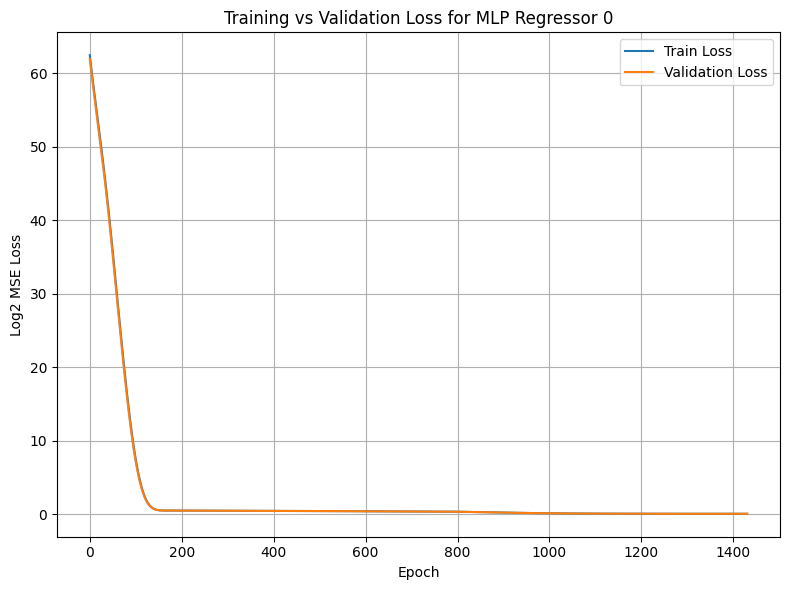


🔧 Training Regressor for class 1...
  Epoch 0 | Val log2-loss: 68.8990
  Epoch 100 | Val log2-loss: 5.3235
  Early stopping at epoch 168 with best val loss 0.4090
Test log2-loss: 0.3950


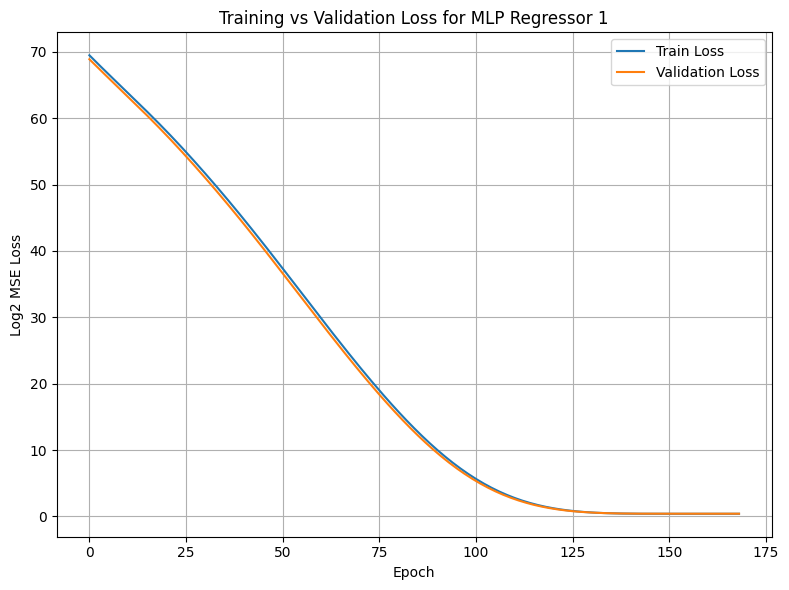


🔧 Training Regressor for class 2...
  Epoch 0 | Val log2-loss: 58.7612
  Epoch 100 | Val log2-loss: 0.5628
  Early stopping at epoch 130 with best val loss 0.4256
Test log2-loss: 0.4301


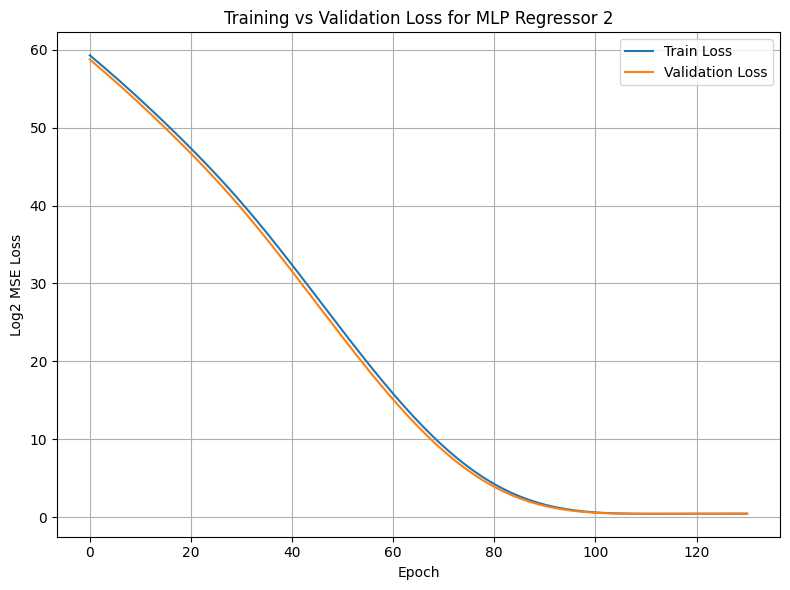


🔧 Training Regressor for class 3...
  Epoch 0 | Val log2-loss: 62.9024
  Epoch 100 | Val log2-loss: 1.2802
  Early stopping at epoch 142 with best val loss 0.5924
Test log2-loss: 0.6072


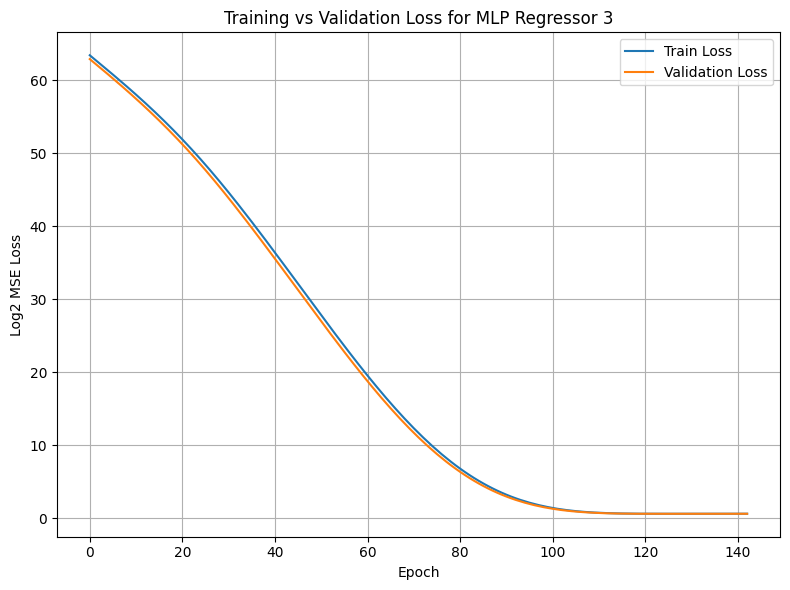


🔧 Training Regressor for class 4...
  Epoch 0 | Val log2-loss: 81.1570
  Epoch 100 | Val log2-loss: 7.7425
  Epoch 200 | Val log2-loss: 0.8036
  Epoch 300 | Val log2-loss: 0.7556
  Epoch 400 | Val log2-loss: 0.7003
  Epoch 500 | Val log2-loss: 0.6379
  Epoch 600 | Val log2-loss: 0.5685
  Epoch 700 | Val log2-loss: 0.4950
  Epoch 800 | Val log2-loss: 0.4191
  Epoch 900 | Val log2-loss: 0.3399
  Epoch 1000 | Val log2-loss: 0.2610
  Epoch 1100 | Val log2-loss: 0.1734
  Epoch 1200 | Val log2-loss: 0.0806
  Epoch 1300 | Val log2-loss: 0.0408
  Epoch 1400 | Val log2-loss: 0.0313
  Epoch 1500 | Val log2-loss: 0.0285
  Epoch 1600 | Val log2-loss: 0.0265
  Epoch 1700 | Val log2-loss: 0.0252
  Epoch 1800 | Val log2-loss: 0.0240
  Epoch 1900 | Val log2-loss: 0.0227
  Epoch 2000 | Val log2-loss: 0.0213
  Epoch 2100 | Val log2-loss: 0.0201
  Epoch 2200 | Val log2-loss: 0.0192
  Epoch 2300 | Val log2-loss: 0.0183
  Epoch 2400 | Val log2-loss: 0.0176
  Epoch 2500 | Val log2-loss: 0.0168
  Epoch 2600

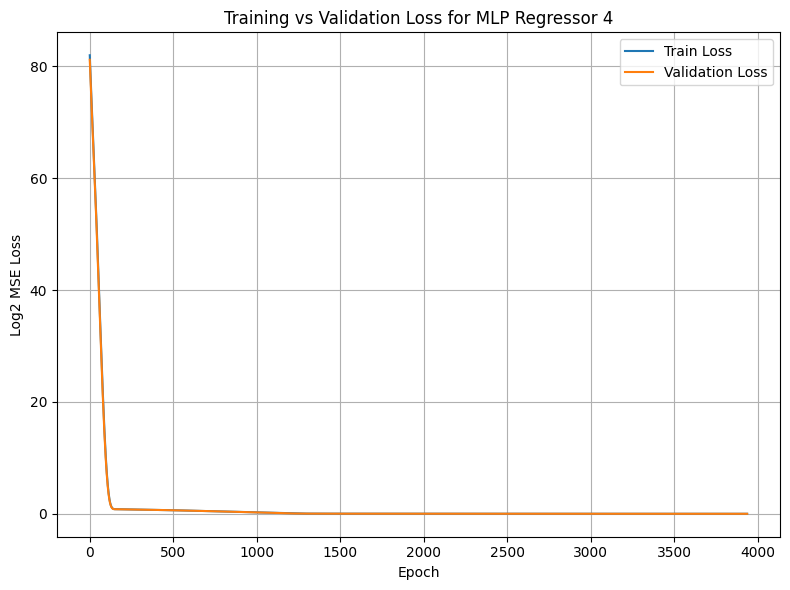


🔧 Training Regressor for class 5...
  Epoch 0 | Val log2-loss: 71.9434
  Epoch 100 | Val log2-loss: 5.4210
  Epoch 200 | Val log2-loss: 1.4998
  Epoch 300 | Val log2-loss: 1.3307
  Epoch 400 | Val log2-loss: 1.1470
  Epoch 500 | Val log2-loss: 0.9138
  Epoch 600 | Val log2-loss: 0.5510
  Epoch 700 | Val log2-loss: 0.2663
  Epoch 800 | Val log2-loss: 0.1251
  Epoch 900 | Val log2-loss: 0.0710
  Epoch 1000 | Val log2-loss: 0.0514
  Epoch 1100 | Val log2-loss: 0.0436
  Epoch 1200 | Val log2-loss: 0.0400
  Epoch 1300 | Val log2-loss: 0.0378
  Epoch 1400 | Val log2-loss: 0.0363
  Epoch 1500 | Val log2-loss: 0.0351
  Epoch 1600 | Val log2-loss: 0.0340
  Epoch 1700 | Val log2-loss: 0.0330
  Epoch 1800 | Val log2-loss: 0.0321
  Epoch 1900 | Val log2-loss: 0.0312
  Epoch 2000 | Val log2-loss: 0.0303
  Epoch 2100 | Val log2-loss: 0.0295
  Epoch 2200 | Val log2-loss: 0.0287
  Epoch 2300 | Val log2-loss: 0.0280
  Epoch 2400 | Val log2-loss: 0.0273
  Epoch 2500 | Val log2-loss: 0.0266
  Epoch 2600

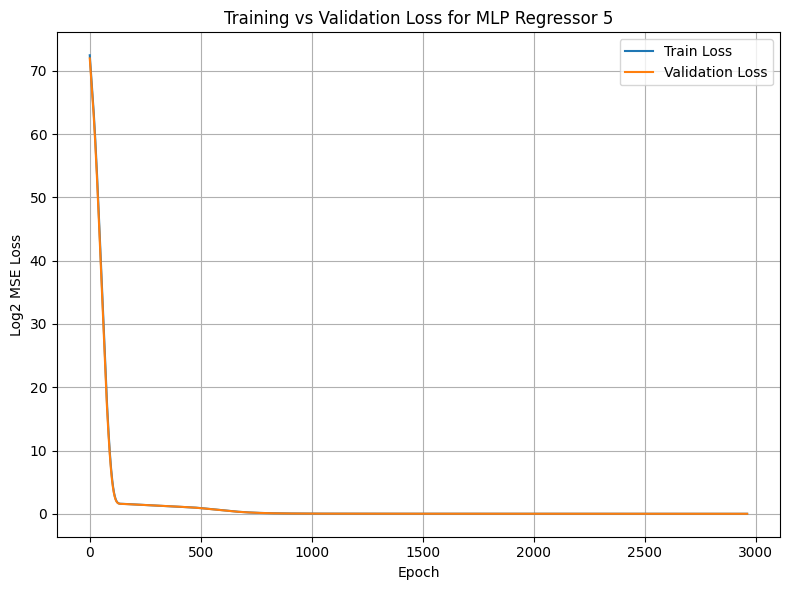


🔧 Training Regressor for class 6...
  Epoch 0 | Val log2-loss: 72.7070
  Epoch 100 | Val log2-loss: 3.7066
  Epoch 200 | Val log2-loss: 2.8529
  Epoch 300 | Val log2-loss: 2.4522
  Epoch 400 | Val log2-loss: 1.9728
  Epoch 500 | Val log2-loss: 1.4456
  Epoch 600 | Val log2-loss: 0.9454
  Epoch 700 | Val log2-loss: 0.5576
  Epoch 800 | Val log2-loss: 0.2567
  Epoch 900 | Val log2-loss: 0.1216
  Epoch 1000 | Val log2-loss: 0.0755
  Epoch 1100 | Val log2-loss: 0.0568
  Epoch 1200 | Val log2-loss: 0.0476
  Epoch 1300 | Val log2-loss: 0.0423
  Epoch 1400 | Val log2-loss: 0.0388
  Epoch 1500 | Val log2-loss: 0.0364
  Epoch 1600 | Val log2-loss: 0.0344
  Epoch 1700 | Val log2-loss: 0.0328
  Epoch 1800 | Val log2-loss: 0.0314
  Epoch 1900 | Val log2-loss: 0.0302
  Epoch 2000 | Val log2-loss: 0.0291
  Epoch 2100 | Val log2-loss: 0.0281
  Epoch 2200 | Val log2-loss: 0.0272
  Epoch 2300 | Val log2-loss: 0.0263
  Epoch 2400 | Val log2-loss: 0.0256
  Epoch 2500 | Val log2-loss: 0.0249
  Epoch 2600

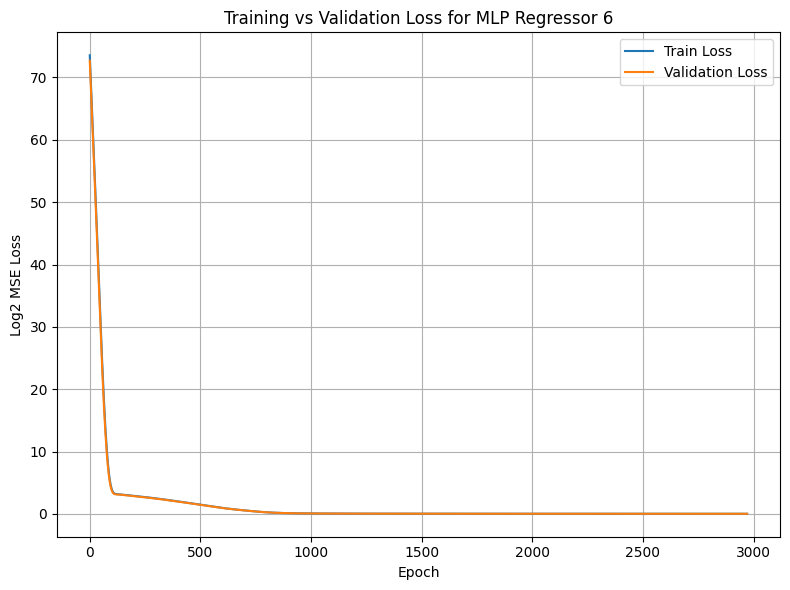


🔧 Training Regressor for class 7...
  Epoch 0 | Val log2-loss: 78.1106
  Epoch 100 | Val log2-loss: 2.1007
  Epoch 200 | Val log2-loss: 1.8147
  Epoch 300 | Val log2-loss: 1.6380
  Epoch 400 | Val log2-loss: 1.4458
  Epoch 500 | Val log2-loss: 1.2452
  Epoch 600 | Val log2-loss: 1.0410
  Epoch 700 | Val log2-loss: 0.8390
  Epoch 800 | Val log2-loss: 0.6469
  Epoch 900 | Val log2-loss: 0.4748
  Epoch 1000 | Val log2-loss: 0.3328
  Epoch 1100 | Val log2-loss: 0.2271
  Epoch 1200 | Val log2-loss: 0.1567
  Epoch 1300 | Val log2-loss: 0.1140
  Epoch 1400 | Val log2-loss: 0.0888
  Epoch 1500 | Val log2-loss: 0.0743
  Epoch 1600 | Val log2-loss: 0.0656
  Epoch 1700 | Val log2-loss: 0.0600
  Epoch 1800 | Val log2-loss: 0.0547
  Epoch 1900 | Val log2-loss: 0.0462
  Epoch 2000 | Val log2-loss: 0.0427
  Epoch 2100 | Val log2-loss: 0.0403
  Epoch 2200 | Val log2-loss: 0.0386
  Epoch 2300 | Val log2-loss: 0.0371
  Epoch 2400 | Val log2-loss: 0.0359
  Epoch 2500 | Val log2-loss: 0.0347
  Epoch 2600

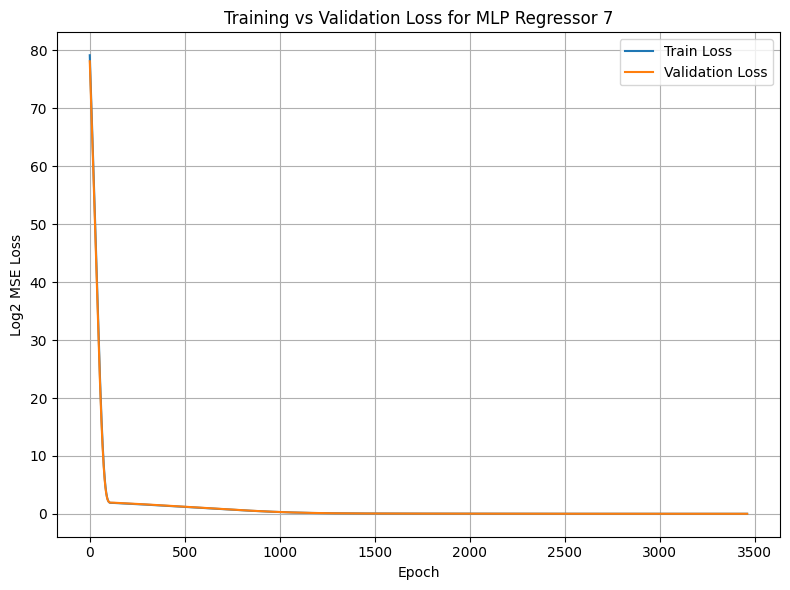


🔧 Training Regressor for class 8...
  Epoch 0 | Val log2-loss: 92.6925
  Epoch 100 | Val log2-loss: 1.9872
  Early stopping at epoch 143 with best val loss 1.0969
Test log2-loss: 1.0735


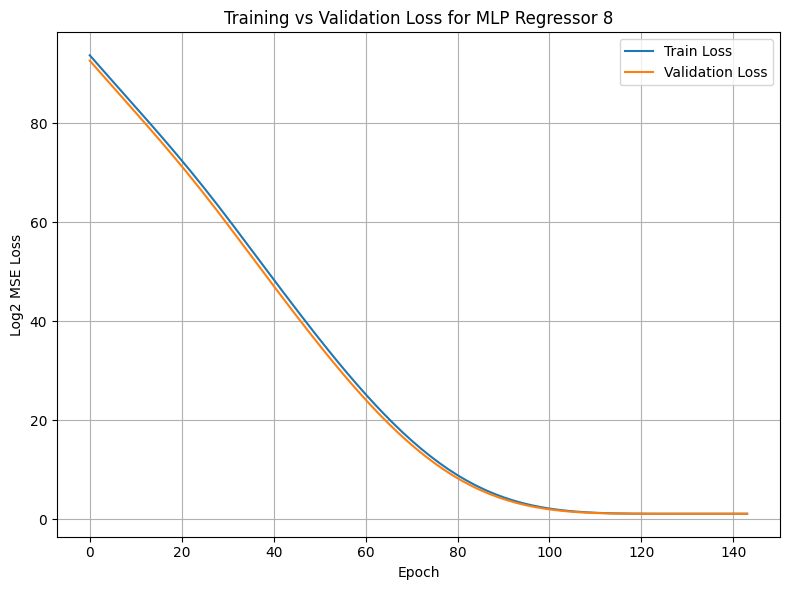


🔧 Training Regressor for class 9...
  Epoch 0 | Val log2-loss: 102.9017
  Epoch 100 | Val log2-loss: 6.2666
  Early stopping at epoch 163 with best val loss 0.8190
Test log2-loss: 0.8029


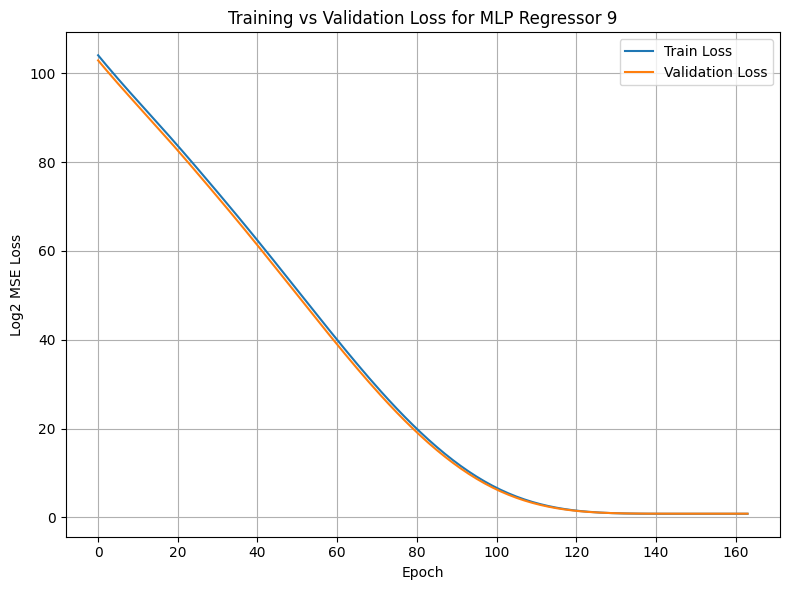


🔧 Training Regressor for class 10...
  Epoch 0 | Val log2-loss: 104.7698
  Epoch 100 | Val log2-loss: 1.5316
  Early stopping at epoch 140 with best val loss 0.5891
Test log2-loss: 0.5881


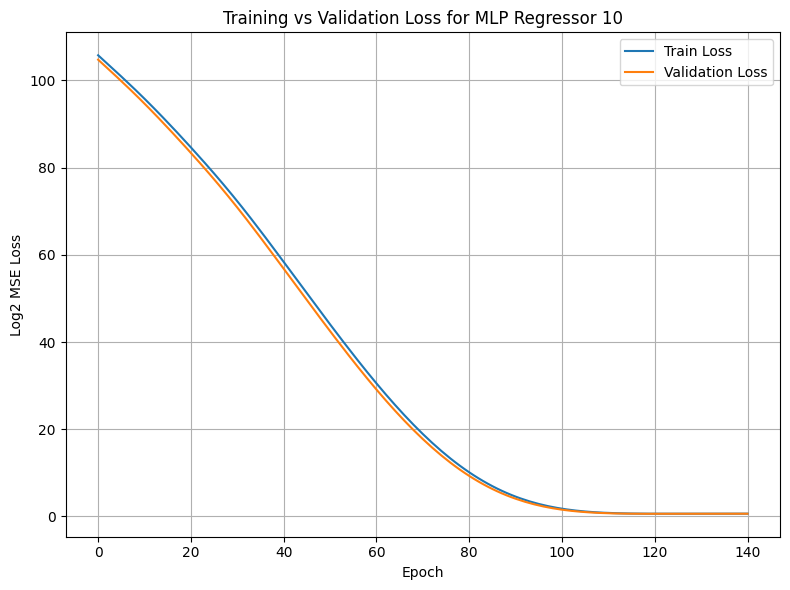


🔧 Training Regressor for class 11...
  Epoch 0 | Val log2-loss: 110.3486
  Epoch 100 | Val log2-loss: 3.8453
  Early stopping at epoch 158 with best val loss 0.6101
Test log2-loss: 0.6395


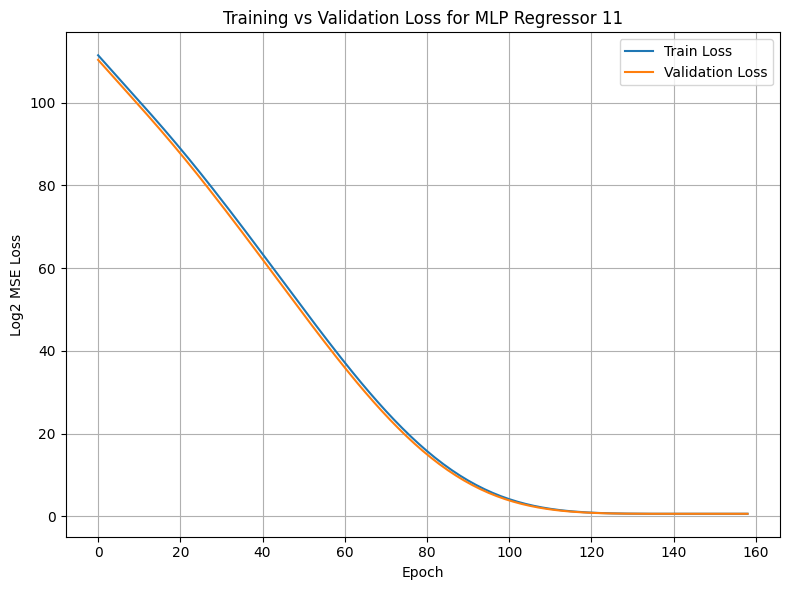


🔧 Training Regressor for class 12...
  Epoch 0 | Val log2-loss: 122.6806
  Epoch 100 | Val log2-loss: 3.6780
  Epoch 200 | Val log2-loss: 1.9437
  Epoch 300 | Val log2-loss: 1.8606
  Epoch 400 | Val log2-loss: 1.7661
  Epoch 500 | Val log2-loss: 1.6636
  Epoch 600 | Val log2-loss: 1.5553
  Epoch 700 | Val log2-loss: 1.4431
  Epoch 800 | Val log2-loss: 1.3281
  Epoch 900 | Val log2-loss: 1.2106
  Epoch 1000 | Val log2-loss: 1.0924
  Epoch 1100 | Val log2-loss: 0.9762
  Epoch 1200 | Val log2-loss: 0.8636
  Epoch 1300 | Val log2-loss: 0.7559
  Epoch 1400 | Val log2-loss: 0.6555
  Epoch 1500 | Val log2-loss: 0.5648
  Epoch 1600 | Val log2-loss: 0.4860
  Epoch 1700 | Val log2-loss: 0.4204
  Epoch 1800 | Val log2-loss: 0.3685
  Epoch 1900 | Val log2-loss: 0.3290
  Epoch 2000 | Val log2-loss: 0.3000
  Epoch 2100 | Val log2-loss: 0.2791
  Epoch 2200 | Val log2-loss: 0.2638
  Epoch 2300 | Val log2-loss: 0.2519
  Epoch 2400 | Val log2-loss: 0.2421
  Epoch 2500 | Val log2-loss: 0.2333
  Epoch 26

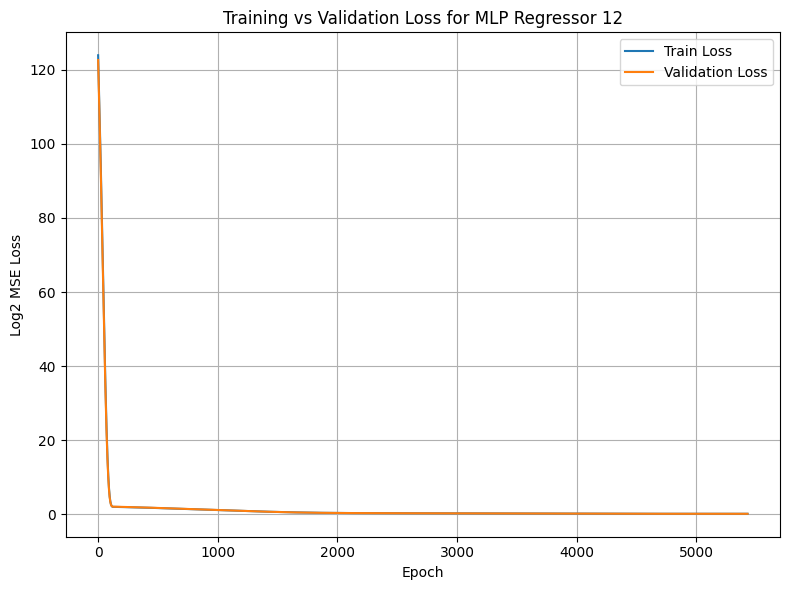


🔧 Training Regressor for class 13...
  Epoch 0 | Val log2-loss: 170.3780
  Epoch 100 | Val log2-loss: 5.3111
  Epoch 200 | Val log2-loss: 4.6264
  Epoch 300 | Val log2-loss: 4.3064
  Epoch 400 | Val log2-loss: 3.9642
  Epoch 500 | Val log2-loss: 3.6056
  Epoch 600 | Val log2-loss: 3.2335
  Epoch 700 | Val log2-loss: 2.8501
  Epoch 800 | Val log2-loss: 2.4613
  Epoch 900 | Val log2-loss: 2.0763
  Epoch 1000 | Val log2-loss: 1.7080
  Epoch 1100 | Val log2-loss: 1.3726
  Epoch 1200 | Val log2-loss: 1.0858
  Epoch 1300 | Val log2-loss: 0.8569
  Epoch 1400 | Val log2-loss: 0.6856
  Epoch 1500 | Val log2-loss: 0.5628
  Epoch 1600 | Val log2-loss: 0.4759
  Epoch 1700 | Val log2-loss: 0.4131
  Epoch 1800 | Val log2-loss: 0.3663
  Epoch 1900 | Val log2-loss: 0.3303
  Epoch 2000 | Val log2-loss: 0.3022
  Epoch 2100 | Val log2-loss: 0.2802
  Epoch 2200 | Val log2-loss: 0.2631
  Epoch 2300 | Val log2-loss: 0.2498
  Epoch 2400 | Val log2-loss: 0.2391
  Epoch 2500 | Val log2-loss: 0.2305
  Epoch 26

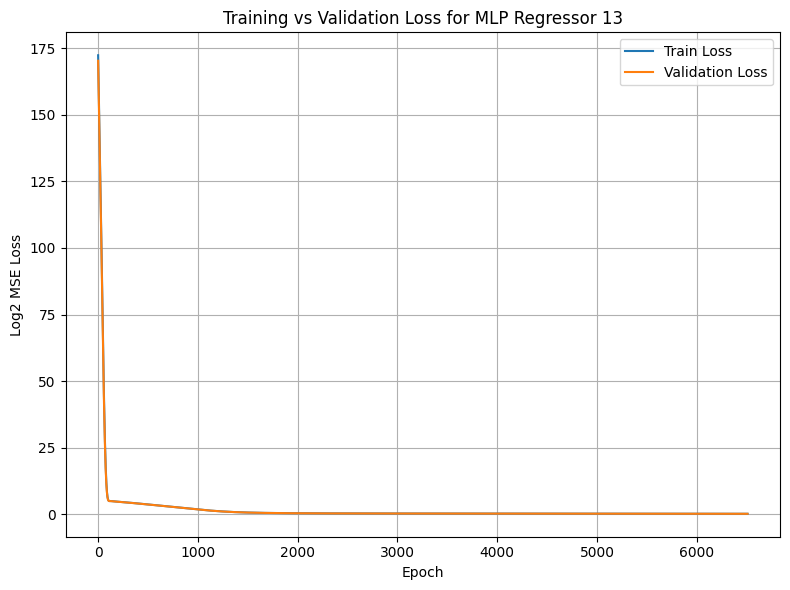


🔧 Training Regressor for class 14...
  Epoch 0 | Val log2-loss: 164.1626
  Epoch 100 | Val log2-loss: 1.3842
  Early stopping at epoch 120 with best val loss 1.3842
Test log2-loss: 1.3508


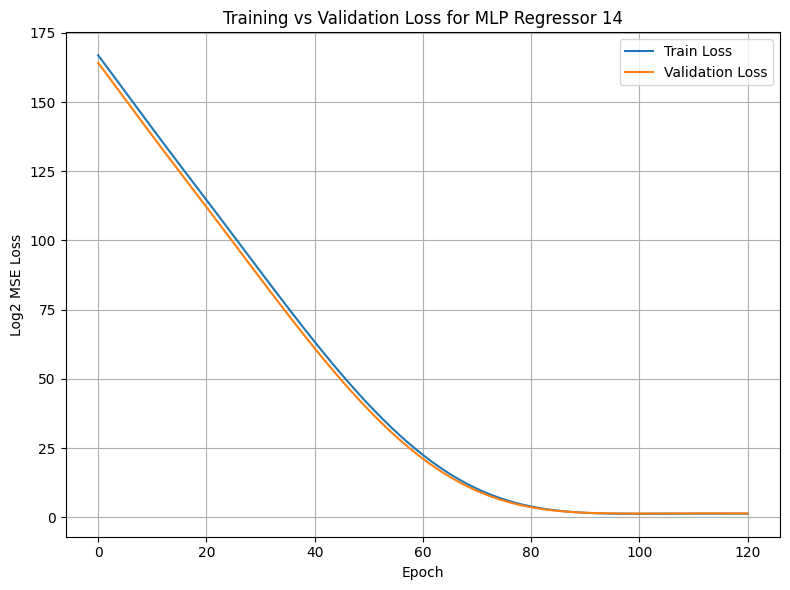


🔧 Training Regressor for class 15...
  Epoch 0 | Val log2-loss: 180.1148
  Epoch 100 | Val log2-loss: 2.9278
  Early stopping at epoch 145 with best val loss 0.6707
Test log2-loss: 0.7087


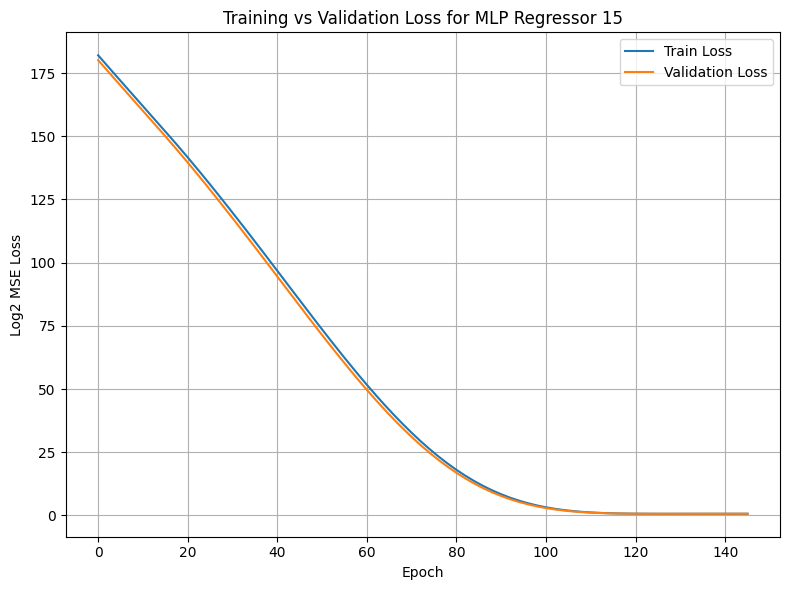


🔧 Training Regressor for class 16...
  Epoch 0 | Val log2-loss: 199.7507
  Epoch 100 | Val log2-loss: 1.0035
  Early stopping at epoch 132 with best val loss 0.4947
Test log2-loss: 0.5098


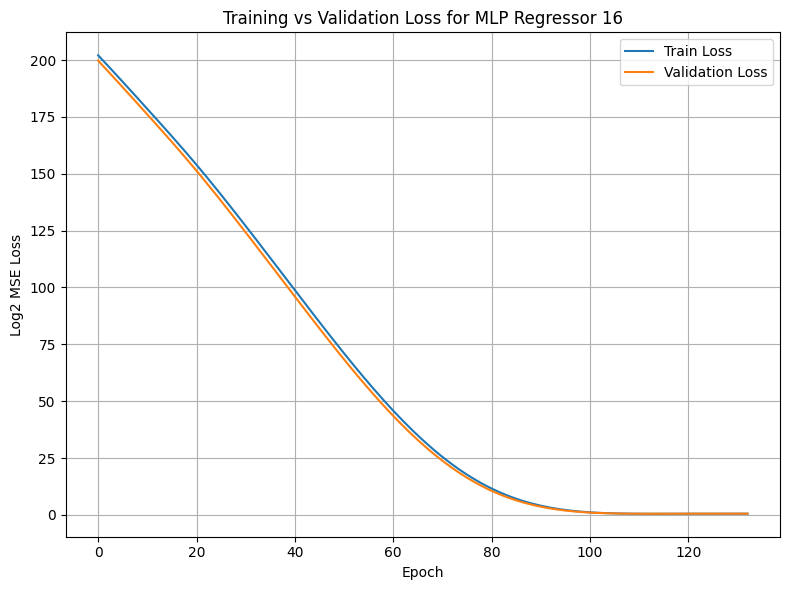


🔧 Training Regressor for class 17...
  Epoch 0 | Val log2-loss: 241.0439
  Epoch 100 | Val log2-loss: 7.2929
  Early stopping at epoch 156 with best val loss 0.3421
Test log2-loss: 0.3748


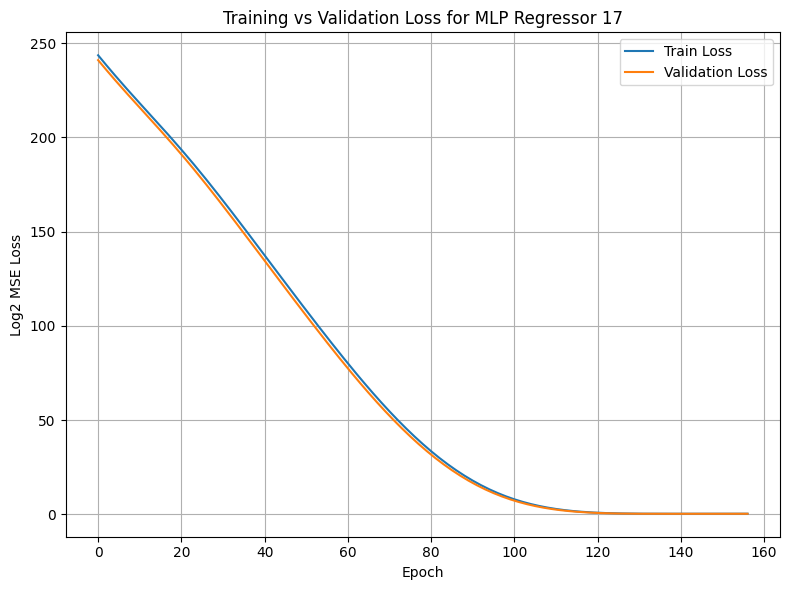


🔧 Training Regressor for class 18...
  Epoch 0 | Val log2-loss: 268.9484
  Epoch 100 | Val log2-loss: 9.5559
  Early stopping at epoch 159 with best val loss 0.4856
Test log2-loss: 0.4732


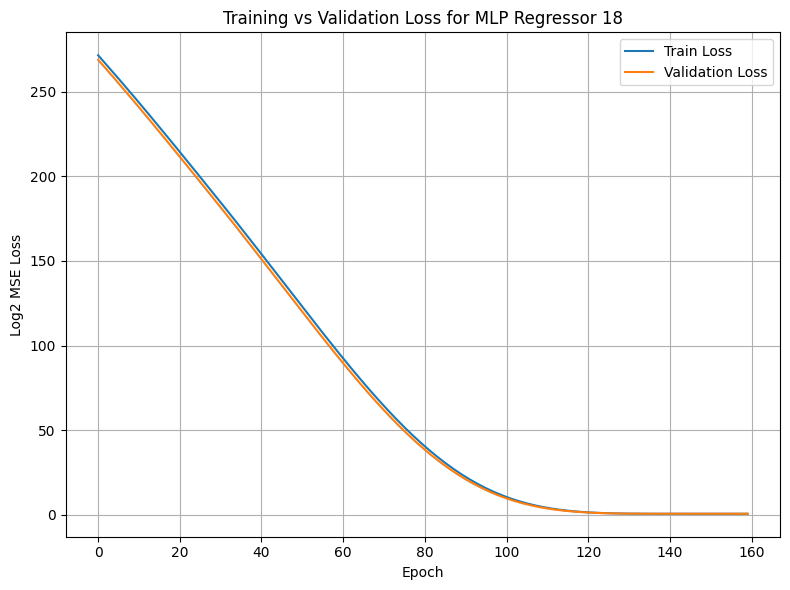


🔧 Training Regressor for class 19...
  Epoch 0 | Val log2-loss: 316.1510
  Epoch 100 | Val log2-loss: 10.6832
  Early stopping at epoch 156 with best val loss 2.5428
Test log2-loss: 2.5455


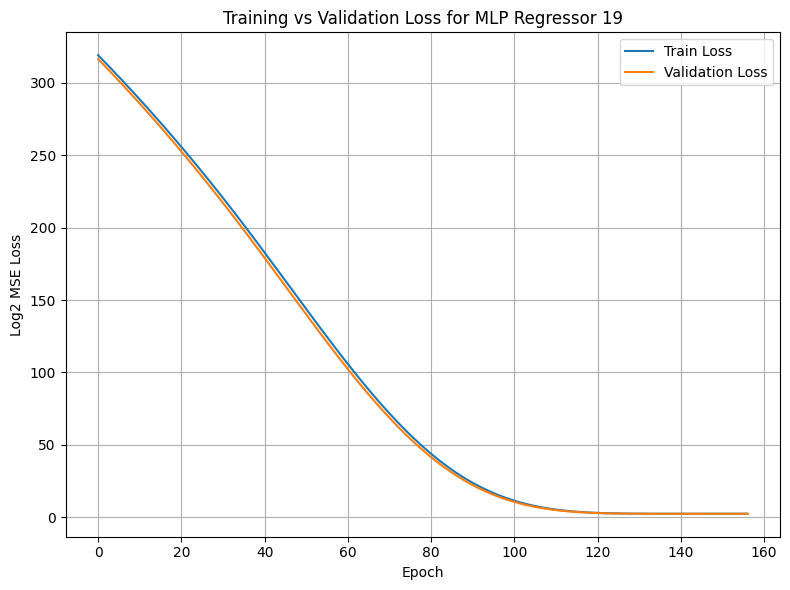

✅ Saved MLP regressors at 9_5_MLP_regressor_models


In [ ]:
import matplotlib.pyplot as plt
import torch
import os

regressors = {}

compressed_reps_tensor = torch.tensor(compressed_reps, dtype=torch.float32).to(device)
log_result_values = np.log2(np.clip(df_95['result'].values, 1e-6, None))
log_result_tensor = torch.tensor(log_result_values, dtype=torch.float32).view(-1, 1).to(device)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

for class_id in range(20):
    print(f"\n🔧 Training Regressor for class {class_id}...")
    class_mask = df_95['class'].values == class_id

    X_class = compressed_reps_tensor[class_mask]
    y_class = log_result_tensor[class_mask]

    if X_class.size(0) < 10:
        print(f"  Skipping class {class_id} (too few samples)")
        continue

    X_temp, X_test, y_temp, y_test = train_test_split(X_class, y_class, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

    reg_model = MLPRegressor().to(device)
    optimizer = optim.Adam(reg_model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    patience = 20
    epochs_no_improve = 0
    min_delta = 1e-4
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(10000):
        reg_model.train()
        y_pred = reg_model(X_train)
        loss = log2_mse_loss(y_pred,y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reg_model.eval()
        with torch.no_grad():
            val_pred = reg_model(X_val)
            val_loss = log2_mse_loss(val_pred, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 100 == 0:
            print(f"  Epoch {epoch} | Val log2-loss: {val_loss.item():.4f}")

        if val_loss.item() + min_delta < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = reg_model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
            break

    if best_model_state:
        reg_model.load_state_dict(best_model_state)
    regressors[class_id] = reg_model

    reg_model.eval()
    with torch.no_grad():
        test_pred = reg_model(X_test)
        test_loss = log2_mse_loss(test_pred, y_test)

    print(f"Test log2-loss: {test_loss.item():.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log2 MSE Loss")
    plt.title(f"Training vs Validation Loss for MLP Regressor {class_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

os.makedirs("9_5_MLP_regressor_models", exist_ok=True)

for class_id, model in regressors.items():
    model_path = f"9_5_MLP_regressor_models/9_5_MLP_regressor_{class_id}.pth"
    torch.save(model.state_dict(), model_path)

print(f"✅ Saved MLP regressors at 9_5_MLP_regressor_models")

# Final Model Testing

In [ ]:
df_95_test = grouped_dfs[(9, 5)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_95_test.apply(preprocess, axis=1))
y = df_95_test['result'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_full_scaled_test = scaler.transform(X_test)
X_full_tensor_test = torch.tensor(X_full_scaled_test, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps_test = trained_encoder(X_full_tensor_test).cpu().numpy()

compressed_reps_test_tensor = torch.tensor(compressed_reps_test, dtype=torch.float32).to(device)

clf_model.eval()
with torch.no_grad():
    test_outputs_clf = clf_model(compressed_reps_test_tensor)
    test_pred_clf = torch.argmax(test_outputs_clf, dim=1).cpu().numpy()

y_true_actual = y_test
y_pred_actual = []

for i in range(len(X_test)):
    class_id = int(test_pred_clf[i])

    if class_id not in regressors:
        y_pred_actual.append(0.0)
        continue

    regressor = regressors[class_id]
    regressor.eval()

    input_tensor = compressed_reps_test_tensor[i].unsqueeze(0)

    with torch.no_grad():
        log_pred = regressor(input_tensor)
        pred_value = torch.pow(2.0, log_pred).item()

    y_pred_actual.append(pred_value)

y_pred_actual = np.array(y_pred_actual)
y_true_actual = np.clip(y_true_actual, 1e-6, None)

def log2_mse_np(y_true, y_pred):
    y_true = np.clip(y_true, 1e-6, None)
    y_pred = np.clip(y_pred, 1e-6, None)
    return np.mean((np.log2(y_true) - np.log2(y_pred)) ** 2)

test_log2_loss = log2_mse_np(y_true_actual, y_pred_actual)
print(f"✅ Final Test Log2 Loss: {test_log2_loss:.4f}")

✅ Final Test Log2 Loss: 4.7459


/tmp/ipykernel_31/3591627150.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


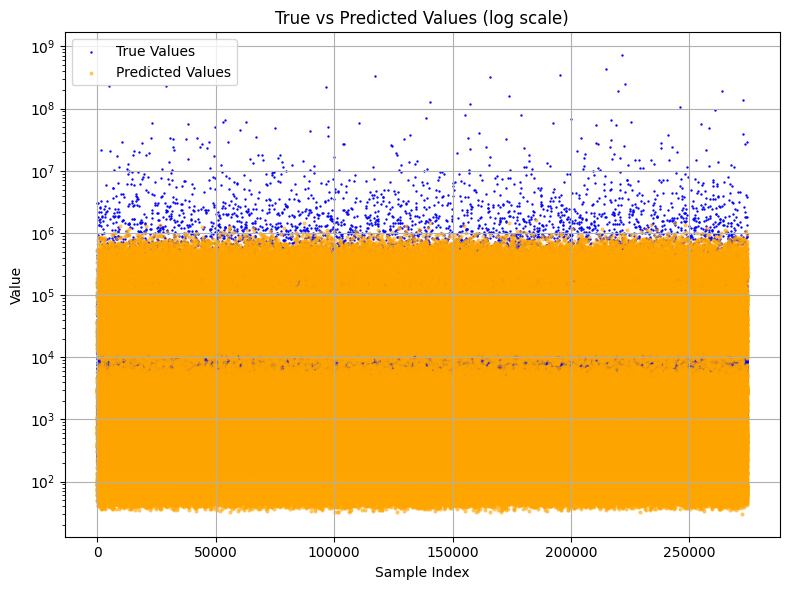

In [ ]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays in case they're not already
y_true = np.array(y_true_actual)
y_pred = np.array(y_pred_actual)

plt.figure(figsize=(8, 6))

# Plot true values in blue
plt.scatter(range(len(y_true)), y_true, label='True Values', color='blue', alpha=1, s=0.5)

# Plot predicted values in red
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.5, s=4)

plt.title('True vs Predicted Values (log scale)')
plt.yscale('log')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Training for (9,6)

# Encoder Decoder Model Training

Using device: cuda
Epoch 0 | Train Loss: 148.0726 | Val Loss: 147.5123
Epoch 100 | Train Loss: 3.8361 | Val Loss: 3.7531
Epoch 200 | Train Loss: 3.0420 | Val Loss: 3.0227
Epoch 300 | Train Loss: 2.8393 | Val Loss: 2.8209
Epoch 400 | Train Loss: 2.7250 | Val Loss: 2.7068
Epoch 500 | Train Loss: 2.6137 | Val Loss: 2.5943
Epoch 600 | Train Loss: 2.4328 | Val Loss: 2.4132
Epoch 700 | Train Loss: 2.2219 | Val Loss: 2.2017
Epoch 800 | Train Loss: 2.0814 | Val Loss: 2.0610
Epoch 900 | Train Loss: 2.0266 | Val Loss: 2.0055
Epoch 1000 | Train Loss: 2.0175 | Val Loss: 1.9961
Epoch 1100 | Train Loss: 2.0163 | Val Loss: 1.9948
Early stopping at epoch 1163 with best val loss 1.9945


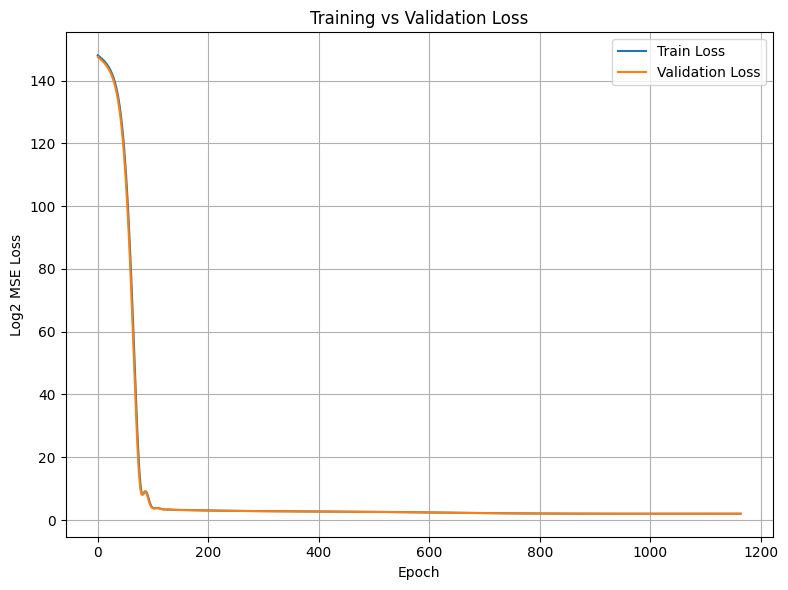

Test Loss: 2.0069
✅ Encoder-Decoder model saved as encoder_decoder_model.pth
✅ Scaler saved as scaler.pkl


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

df_96 = grouped_dfs[(9, 6)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_96.apply(preprocess, axis=1))
y = df_96['result'].values
y_log = np.log2(np.clip(y, 1e-6, None))

X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

class EncoderDecoder(nn.Module):
    def __init__(self, input_dim=57, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

ed_model = EncoderDecoder().to(device)

optimizer = optim.Adam(ed_model.parameters(), lr=0.001)
num_epochs = 3000

patience = 20
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ed_model.train()
    y_pred = ed_model(X_train)
    loss = log2_mse_loss(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ed_model.eval()
    with torch.no_grad():
        val_pred = ed_model(X_val)
        val_loss = log2_mse_loss(val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    if val_loss.item() + min_delta < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = ed_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
        break

if best_model_state is not None:
    ed_model.load_state_dict(best_model_state)

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log2 MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ed_model.eval()
with torch.no_grad():
    test_pred = ed_model(X_test)
    test_loss = log2_mse_loss(test_pred, y_test)

print(f"Test Loss: {test_loss:.4f}")

torch.save(ed_model.state_dict(), f"9_6_encoder_decoder_model.pth")
print("✅ Encoder-Decoder model saved as encoder_decoder_model.pth")

joblib.dump(scaler, "9_6_scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

# MLP Classifier Model Training

Epoch 0 | Train Loss: 3.0441 | Val Acc: 0.0500
Epoch 10 | Train Loss: 2.9810 | Val Acc: 0.0502
Epoch 20 | Train Loss: 2.9630 | Val Acc: 0.0496
Early stopping at epoch 28 with best val acc 0.0550
Test Accuracy: 0.0493
✅ Classifier model saved as classifier_mlp_model.pth


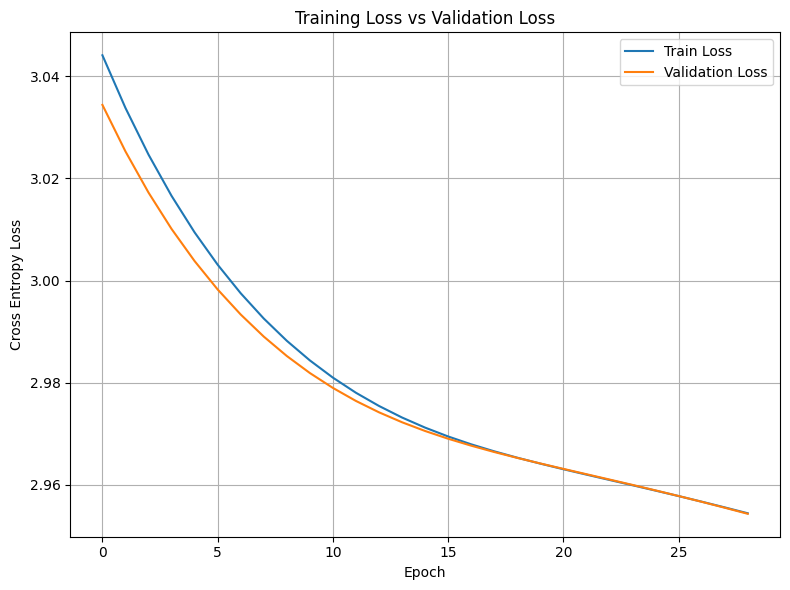

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

trained_encoder = ed_model.encoder

result_values = df_96['result'].values

df_96['class'] = pd.qcut(np.log2(result_values), q=20, labels=False, duplicates='drop')

X_full = np.vstack(df_96.apply(preprocess, axis=1))
X_full_scaled = scaler.transform(X_full)
X_full_tensor = torch.tensor(X_full_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps = trained_encoder(X_full_tensor).cpu().numpy()

class_labels = df_96['class'].values
label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(class_labels)

X_cls_temp, X_cls_test, y_cls_temp, y_cls_test = train_test_split(compressed_reps, y_classes, test_size=0.15, random_state=42)
X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(X_cls_temp, y_cls_temp, test_size=0.1765, random_state=42)

X_cls_train = torch.tensor(X_cls_train, dtype=torch.float32).to(device)
X_cls_val = torch.tensor(X_cls_val, dtype=torch.float32).to(device)
X_cls_test = torch.tensor(X_cls_test, dtype=torch.float32).to(device)

y_cls_train = torch.tensor(y_cls_train, dtype=torch.long).to(device)
y_cls_val = torch.tensor(y_cls_val, dtype=torch.long).to(device)
y_cls_test = torch.tensor(y_cls_test, dtype=torch.long).to(device)

class ClassifierMLP(nn.Module):
    def __init__(self, input_dim=16, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

clf_model = ClassifierMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=0.001)

patience = 20
best_val_acc = 0.0
epochs_no_improve = 0
min_delta = 1e-4
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(100):
    clf_model.train()
    outputs = clf_model(X_cls_train)
    loss = criterion(outputs, y_cls_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    clf_model.eval()
    with torch.no_grad():
        val_outputs = clf_model(X_cls_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_loss = criterion(val_outputs, y_cls_val)
        val_acc = accuracy_score(y_cls_val.cpu(), val_preds.cpu())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_model_state = clf_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val acc {best_val_acc:.4f}")
        break

if best_model_state:
    clf_model.load_state_dict(best_model_state)

clf_model.eval()
with torch.no_grad():
    test_outputs = clf_model(X_cls_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = accuracy_score(y_cls_test.cpu(), test_preds.cpu())

print(f"Test Accuracy: {test_acc:.4f}")

torch.save(clf_model.state_dict(), "9_6_classifier_mlp_model.pth")
print("✅ Classifier model saved as classifier_mlp_model.pth")

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MLP Regressor Model Training


🔧 Training Regressor for class 0...
  Epoch 0 | Val log2-loss: 69.3213
  Epoch 100 | Val log2-loss: 7.3939
  Early stopping at epoch 139 with best val loss 0.3833
Test log2-loss: 0.4377


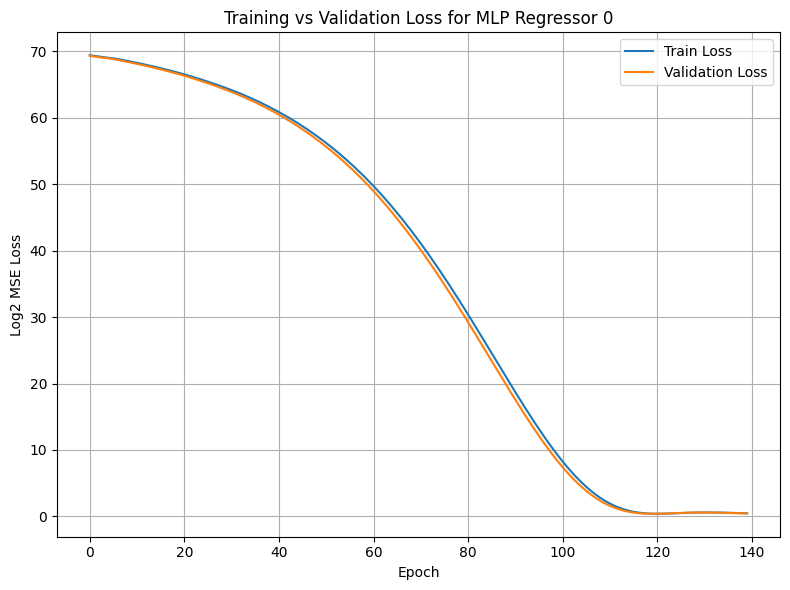


🔧 Training Regressor for class 1...
  Epoch 0 | Val log2-loss: 76.2642
  Epoch 100 | Val log2-loss: 64.4943
  Early stopping at epoch 192 with best val loss 0.3723
Test log2-loss: 0.5085


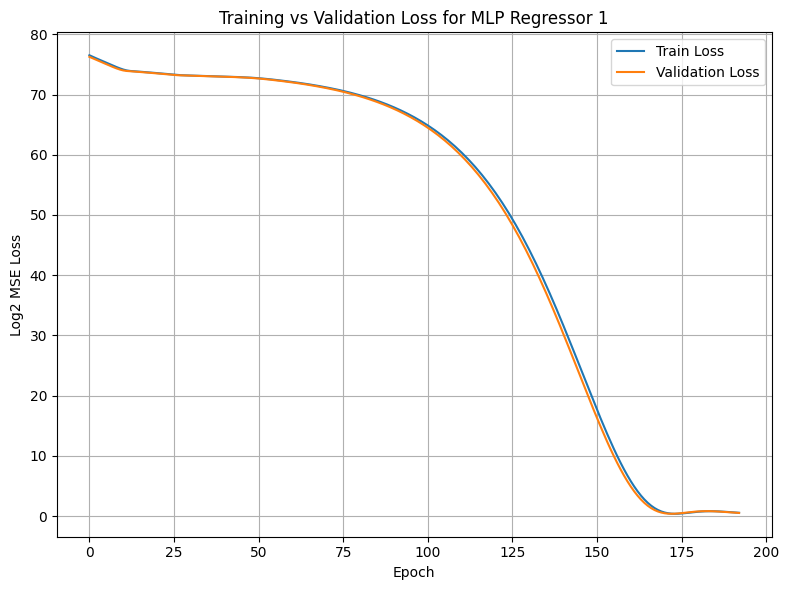


🔧 Training Regressor for class 2...
  Epoch 0 | Val log2-loss: 76.1769
  Epoch 100 | Val log2-loss: 0.8522
  Early stopping at epoch 113 with best val loss 0.4046
Test log2-loss: 0.5500


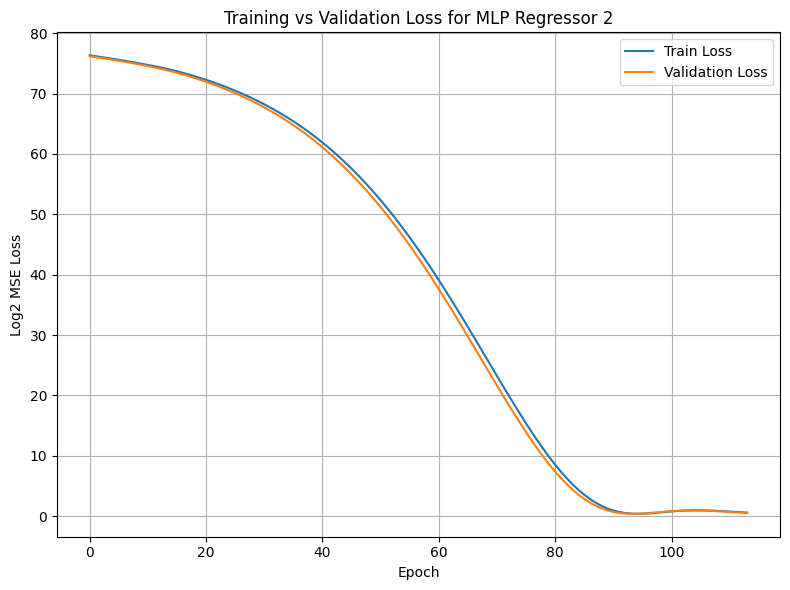


🔧 Training Regressor for class 3...
  Epoch 0 | Val log2-loss: 85.4233
  Epoch 100 | Val log2-loss: 0.9588
  Early stopping at epoch 111 with best val loss 0.4647
Test log2-loss: 0.5554


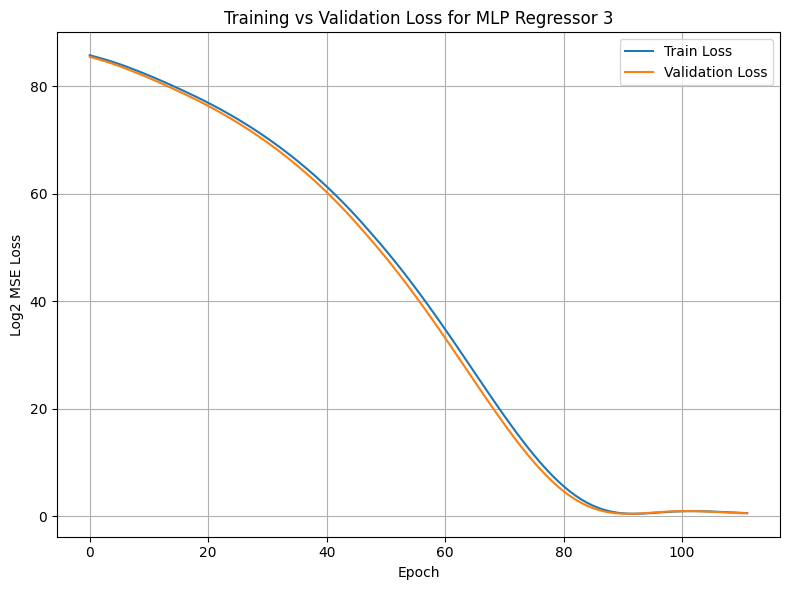


🔧 Training Regressor for class 4...
  Epoch 0 | Val log2-loss: 84.3464
  Epoch 100 | Val log2-loss: 14.3721
  Early stopping at epoch 140 with best val loss 0.4236
Test log2-loss: 0.5755


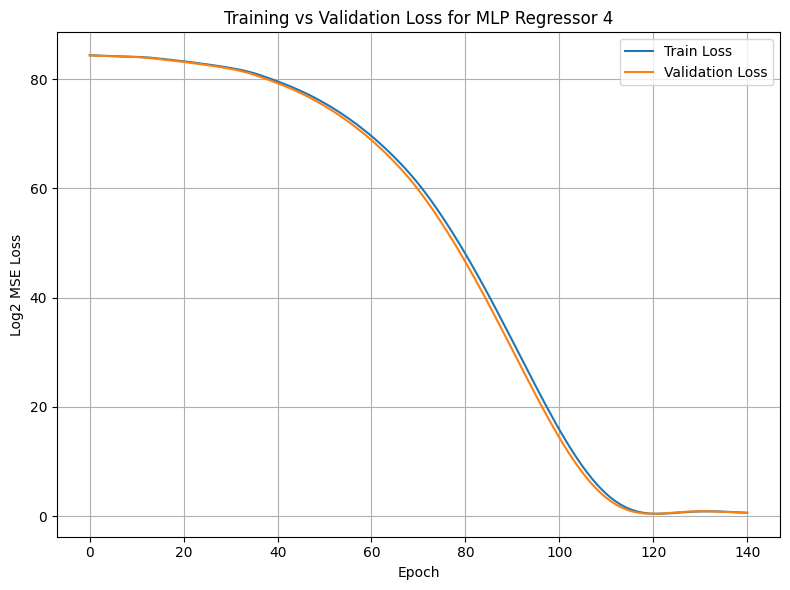


🔧 Training Regressor for class 5...
  Epoch 0 | Val log2-loss: 92.5781
  Epoch 100 | Val log2-loss: 0.6063
  Early stopping at epoch 117 with best val loss 0.4888
Test log2-loss: 0.6736


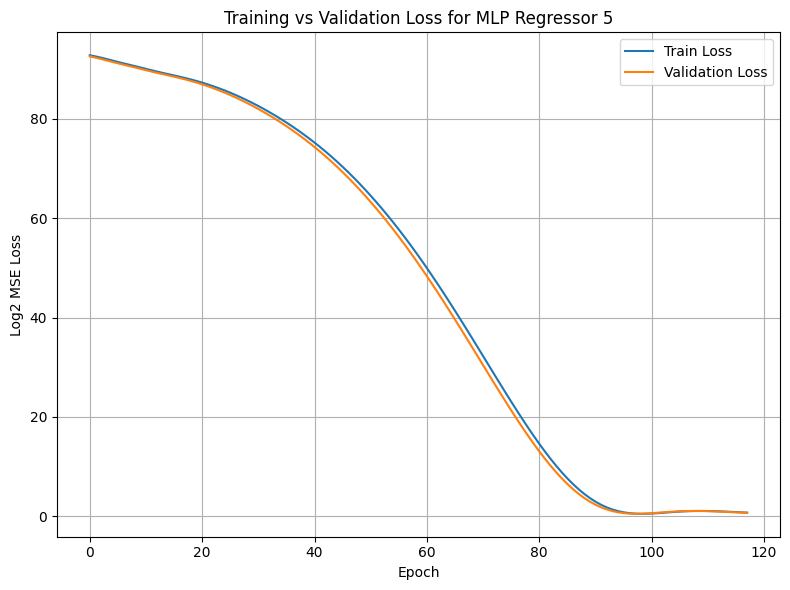


🔧 Training Regressor for class 6...
  Epoch 0 | Val log2-loss: 90.0621
  Epoch 100 | Val log2-loss: 3.4569
  Early stopping at epoch 130 with best val loss 0.4992
Test log2-loss: 0.6713


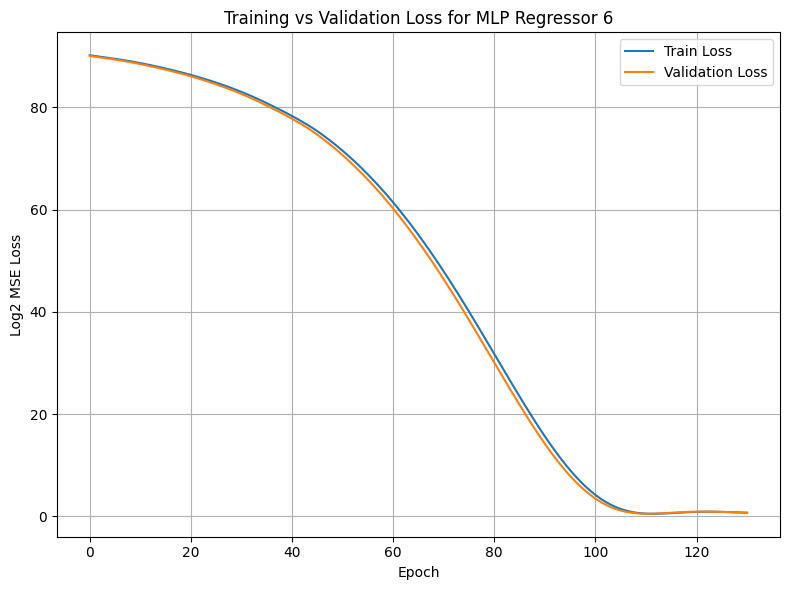


🔧 Training Regressor for class 7...
  Epoch 0 | Val log2-loss: 93.6330
  Epoch 100 | Val log2-loss: 1.2062
  Early stopping at epoch 108 with best val loss 0.4233
Test log2-loss: 0.6306


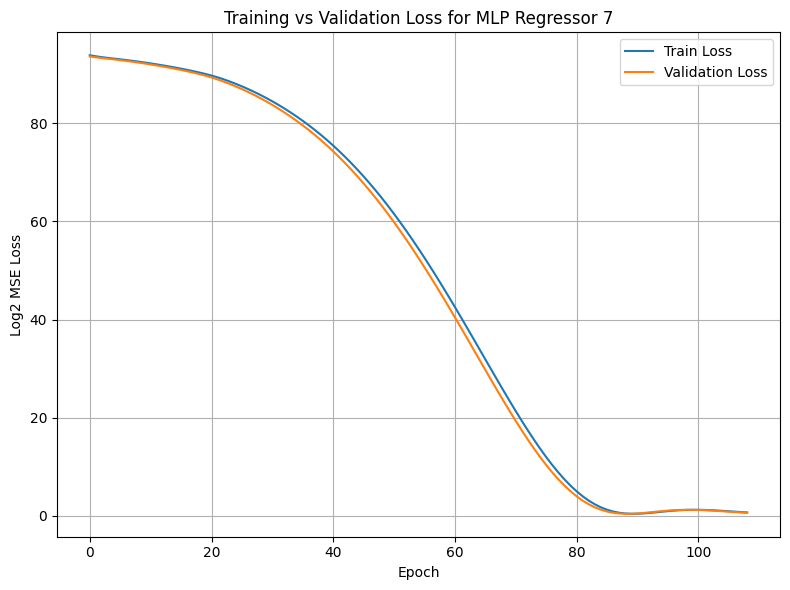


🔧 Training Regressor for class 8...
  Epoch 0 | Val log2-loss: 110.3896
  Epoch 100 | Val log2-loss: 2.3775
  Early stopping at epoch 126 with best val loss 0.7350
Test log2-loss: 0.8933


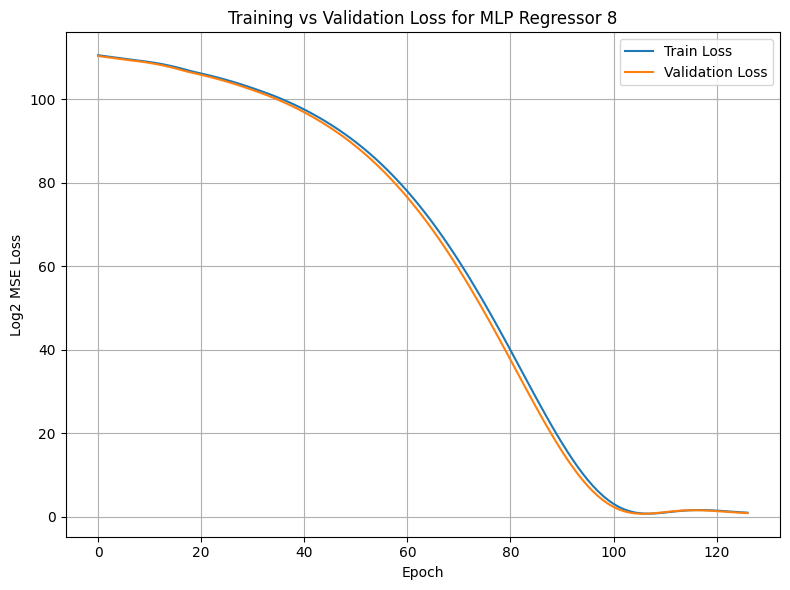


🔧 Training Regressor for class 9...
  Epoch 0 | Val log2-loss: 120.5381
  Epoch 100 | Val log2-loss: 6.1960
  Early stopping at epoch 113 with best val loss 5.3014
Test log2-loss: 5.4370


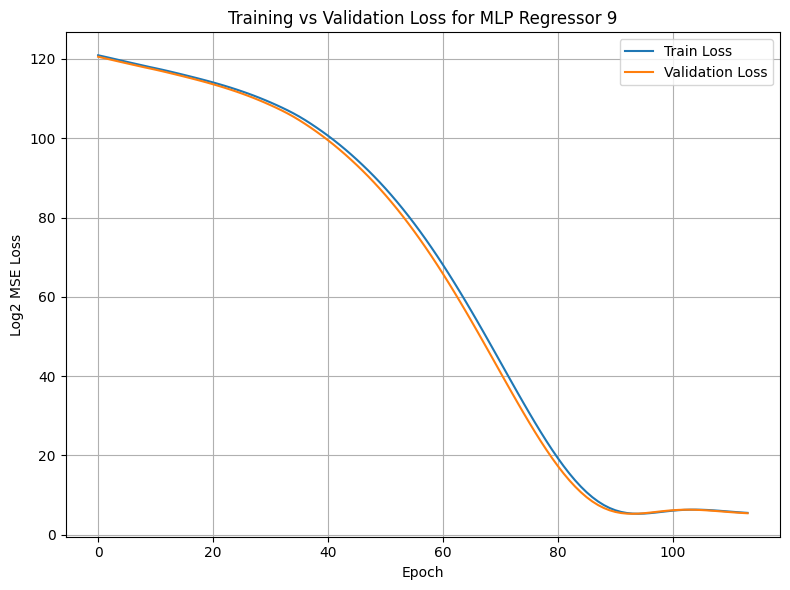


🔧 Training Regressor for class 10...
  Epoch 0 | Val log2-loss: 144.3514
  Epoch 100 | Val log2-loss: 3.5337
  Early stopping at epoch 123 with best val loss 3.2976
Test log2-loss: 3.6118


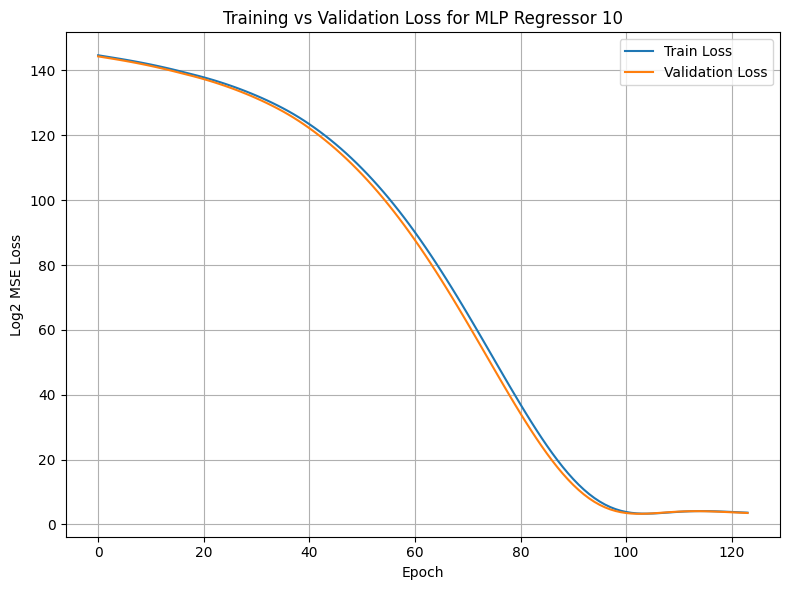


🔧 Training Regressor for class 11...
  Epoch 0 | Val log2-loss: 150.2422
  Epoch 100 | Val log2-loss: 2.6480
  Early stopping at epoch 111 with best val loss 1.2635
Test log2-loss: 1.5100


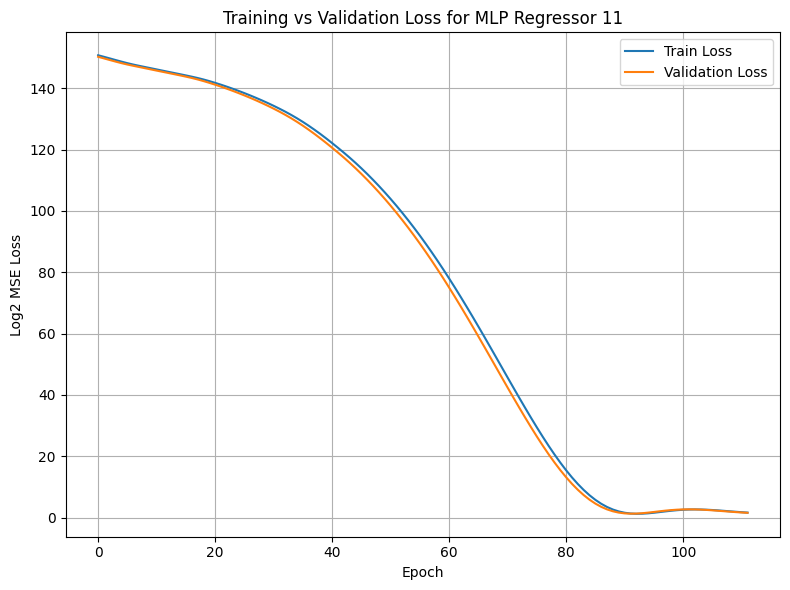


🔧 Training Regressor for class 12...
  Epoch 0 | Val log2-loss: 170.9164
  Epoch 100 | Val log2-loss: 64.5962
  Early stopping at epoch 153 with best val loss 0.8516
Test log2-loss: 1.0937


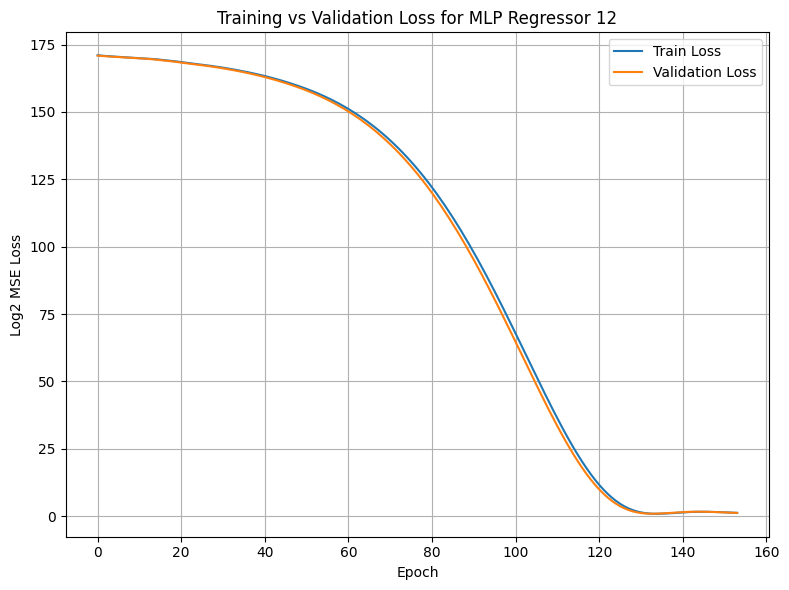


🔧 Training Regressor for class 13...
  Epoch 0 | Val log2-loss: 179.8768
  Epoch 100 | Val log2-loss: 4.6515
  Early stopping at epoch 128 with best val loss 0.6130
Test log2-loss: 0.8088


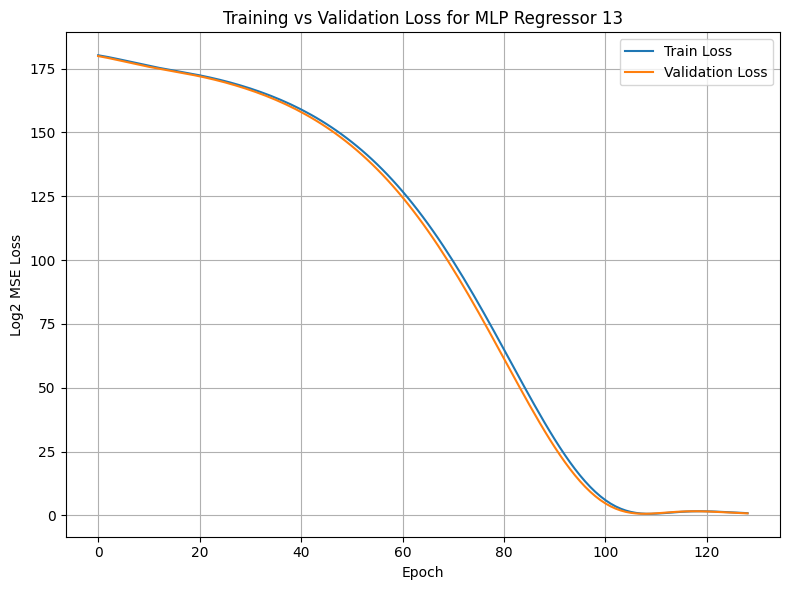


🔧 Training Regressor for class 14...
  Epoch 0 | Val log2-loss: 186.4750
  Epoch 100 | Val log2-loss: 54.3869
  Early stopping at epoch 148 with best val loss 0.5105
Test log2-loss: 0.8167


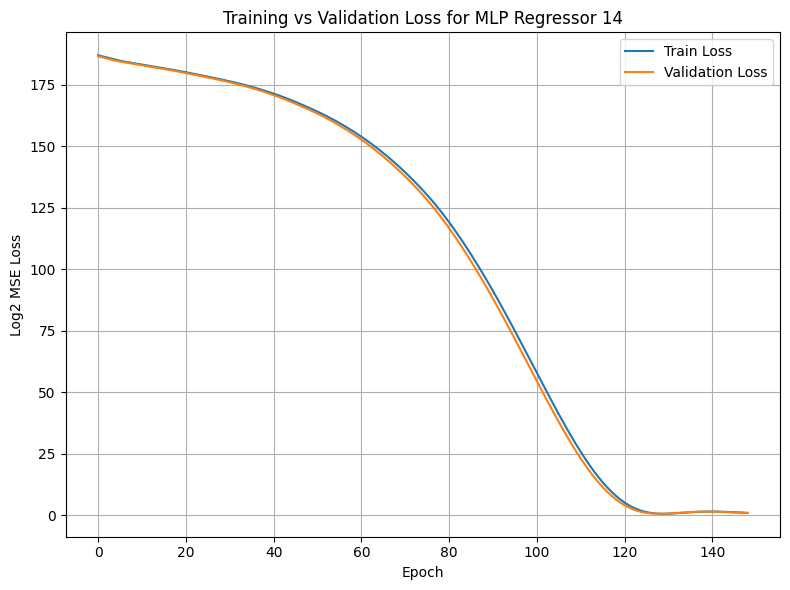


🔧 Training Regressor for class 15...
  Epoch 0 | Val log2-loss: 193.4935
  Epoch 100 | Val log2-loss: 4.9768
  Early stopping at epoch 128 with best val loss 0.5233
Test log2-loss: 0.8515


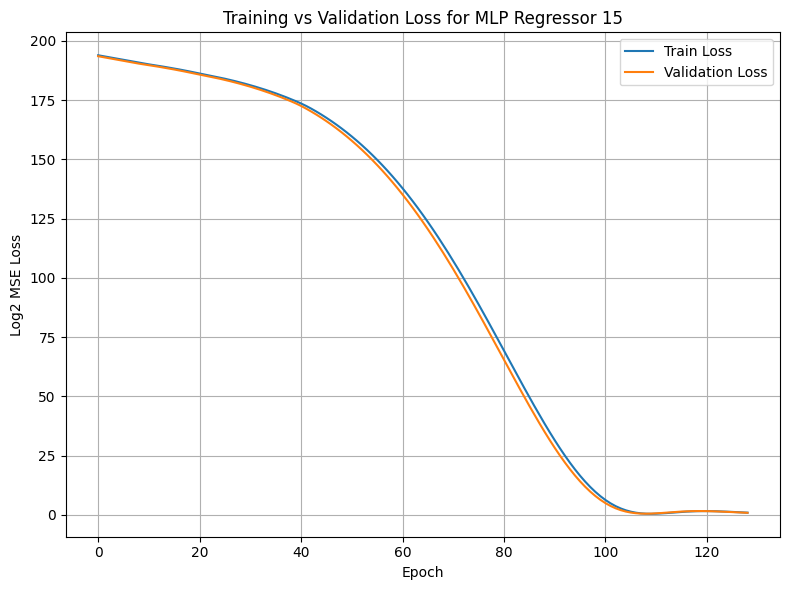


🔧 Training Regressor for class 16...
  Epoch 0 | Val log2-loss: 209.0214
  Epoch 100 | Val log2-loss: 0.8010
  Early stopping at epoch 117 with best val loss 0.4522
Test log2-loss: 0.8787


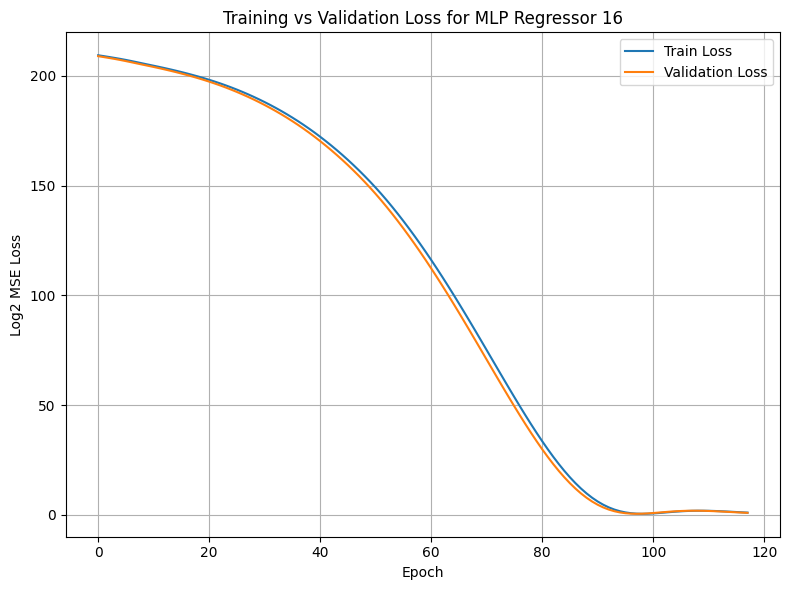


🔧 Training Regressor for class 17...
  Epoch 0 | Val log2-loss: 219.6800
  Epoch 100 | Val log2-loss: 98.3116
  Early stopping at epoch 166 with best val loss 0.4631
Test log2-loss: 0.7209


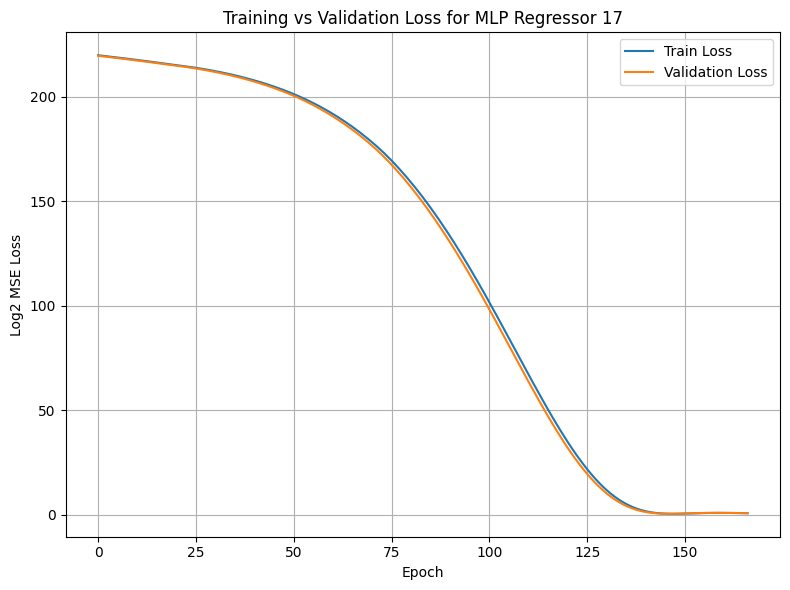


🔧 Training Regressor for class 18...
  Epoch 0 | Val log2-loss: 245.8058
  Epoch 100 | Val log2-loss: 107.8454
  Early stopping at epoch 157 with best val loss 0.5637
Test log2-loss: 0.9936


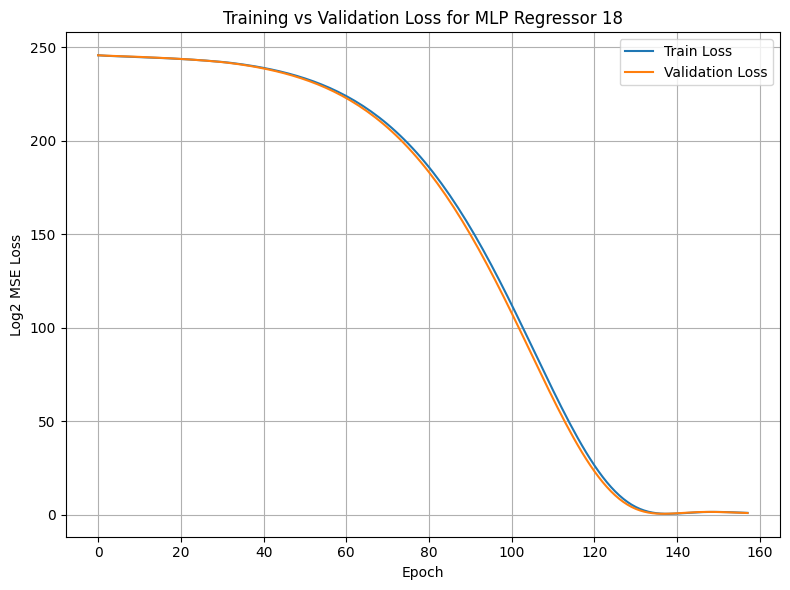


🔧 Training Regressor for class 19...
  Epoch 0 | Val log2-loss: 346.0992
  Epoch 100 | Val log2-loss: 218.8186
  Early stopping at epoch 168 with best val loss 2.7663
Test log2-loss: 3.2855


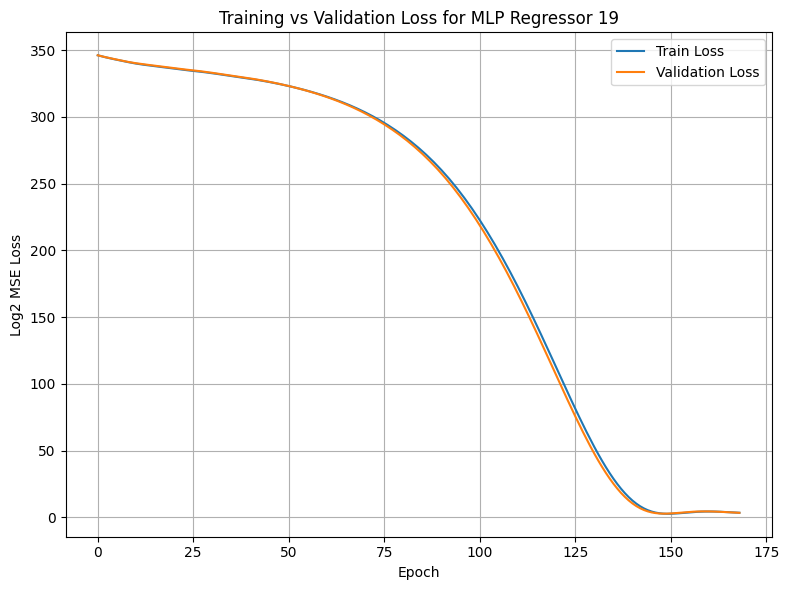

✅ Saved MLP regressors at 9_6_MLP_regressor_models


In [ ]:
import matplotlib.pyplot as plt
import torch
import os

regressors = {}

compressed_reps_tensor = torch.tensor(compressed_reps, dtype=torch.float32).to(device)
log_result_values = np.log2(np.clip(df_96['result'].values, 1e-6, None))
log_result_tensor = torch.tensor(log_result_values, dtype=torch.float32).view(-1, 1).to(device)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.model(x)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

for class_id in range(20):
    print(f"\n🔧 Training Regressor for class {class_id}...")
    class_mask = df_96['class'].values == class_id

    X_class = compressed_reps_tensor[class_mask]
    y_class = log_result_tensor[class_mask]

    if X_class.size(0) < 10:
        print(f"  Skipping class {class_id} (too few samples)")
        continue

    X_temp, X_test, y_temp, y_test = train_test_split(X_class, y_class, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

    reg_model = MLPRegressor().to(device)
    optimizer = optim.Adam(reg_model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    patience = 20
    epochs_no_improve = 0
    min_delta = 1e-4
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(20000):
        reg_model.train()
        y_pred = reg_model(X_train)
        loss = log2_mse_loss(y_pred,y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reg_model.eval()
        with torch.no_grad():
            val_pred = reg_model(X_val)
            val_loss = log2_mse_loss(val_pred, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 100 == 0:
            print(f"  Epoch {epoch} | Val log2-loss: {val_loss.item():.4f}")

        if val_loss.item() + min_delta < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = reg_model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
            break

    # Save model
    if best_model_state:
        reg_model.load_state_dict(best_model_state)
    regressors[class_id] = reg_model

    reg_model.eval()
    with torch.no_grad():
        test_pred = reg_model(X_test)
        test_loss = log2_mse_loss(test_pred, y_test)

    print(f"Test log2-loss: {test_loss.item():.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log2 MSE Loss")
    plt.title(f"Training vs Validation Loss for MLP Regressor {class_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

os.makedirs("9_6_MLP_regressor_models", exist_ok=True)

for class_id, model in regressors.items():
    model_path = f"9_6_MLP_regressor_models/9_6_MLP_regressor_{class_id}.pth"
    torch.save(model.state_dict(), model_path)

print(f"✅ Saved MLP regressors at 9_6_MLP_regressor_models")

# Final Model Testing

In [ ]:
df_96_test = grouped_dfs[(9, 6)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_96_test.apply(preprocess, axis=1))
y = df_96_test['result'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_full_scaled_test = scaler.transform(X_test)
X_full_tensor_test = torch.tensor(X_full_scaled_test, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps_test = trained_encoder(X_full_tensor_test).cpu().numpy()

compressed_reps_test_tensor = torch.tensor(compressed_reps_test, dtype=torch.float32).to(device)

clf_model.eval()
with torch.no_grad():
    test_outputs_clf = clf_model(compressed_reps_test_tensor)
    test_pred_clf = torch.argmax(test_outputs_clf, dim=1).cpu().numpy()

y_true_actual = y_test
y_pred_actual = []

for i in range(len(X_test)):
    class_id = int(test_pred_clf[i])

    if class_id not in regressors:
        y_pred_actual.append(0.0)
        continue

    regressor = regressors[class_id]
    regressor.eval()

    input_tensor = compressed_reps_test_tensor[i].unsqueeze(0)

    with torch.no_grad():
        log_pred = regressor(input_tensor)
        pred_value = torch.pow(2.0, log_pred).item()

    y_pred_actual.append(pred_value)

y_pred_actual = np.array(y_pred_actual)
y_true_actual = np.clip(y_true_actual, 1e-6, None)

def log2_mse_np(y_true, y_pred):
    y_true = np.clip(y_true, 1e-6, None)
    y_pred = np.clip(y_pred, 1e-6, None)
    return np.mean((np.log2(y_true) - np.log2(y_pred)) ** 2)

test_log2_loss = log2_mse_np(y_true_actual, y_pred_actual)
print(f"✅ Final Test Log2 Loss: {test_log2_loss:.4f}")

✅ Final Test Log2 Loss: 5.1501


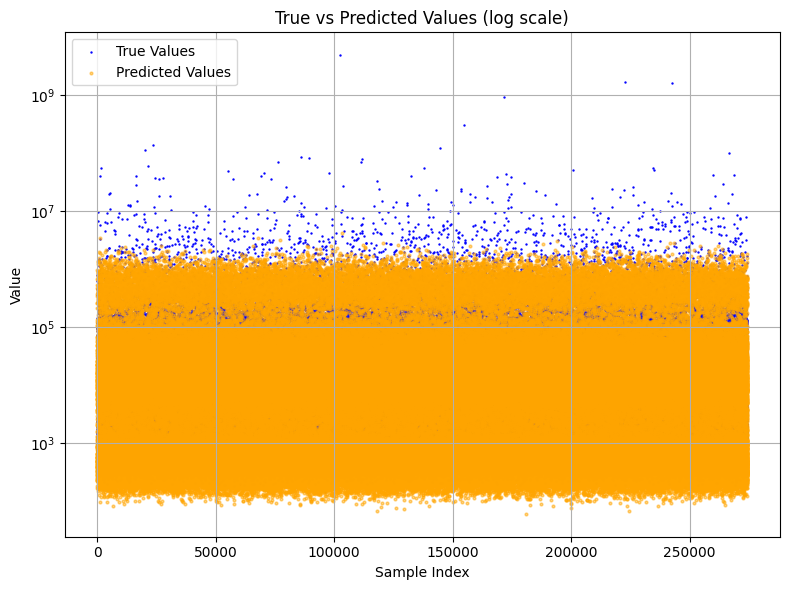

In [ ]:
import matplotlib.pyplot as plt

y_true = np.array(y_true_actual)
y_pred = np.array(y_pred_actual)

plt.figure(figsize=(8, 6))

plt.scatter(range(len(y_true)), y_true, label='True Values', color='blue', alpha=1, s=0.5)

plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.5, s=4)

plt.title('True vs Predicted Values (log scale)')
plt.yscale('log')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Training for (10,4)

# Encoder Decoder Model Training

Using device: cuda
Epoch 0 | Train Loss: 101.8883 | Val Loss: 101.6033
Epoch 100 | Train Loss: 5.2727 | Val Loss: 5.1361
Epoch 200 | Train Loss: 2.1904 | Val Loss: 2.1889
Epoch 300 | Train Loss: 1.9910 | Val Loss: 1.9941
Epoch 400 | Train Loss: 1.6753 | Val Loss: 1.6746
Epoch 500 | Train Loss: 1.3901 | Val Loss: 1.3911
Epoch 600 | Train Loss: 1.2522 | Val Loss: 1.2542
Epoch 700 | Train Loss: 1.1902 | Val Loss: 1.1925
Epoch 800 | Train Loss: 1.1507 | Val Loss: 1.1533
Epoch 900 | Train Loss: 1.1322 | Val Loss: 1.1348
Epoch 1000 | Train Loss: 1.1275 | Val Loss: 1.1303
Epoch 1100 | Train Loss: 1.1255 | Val Loss: 1.1284
Epoch 1200 | Train Loss: 1.1241 | Val Loss: 1.1271
Epoch 1300 | Train Loss: 1.1231 | Val Loss: 1.1261
Epoch 1400 | Train Loss: 1.1222 | Val Loss: 1.1253
Epoch 1500 | Train Loss: 1.1216 | Val Loss: 1.1247
Early stopping at epoch 1579 with best val loss 1.1244


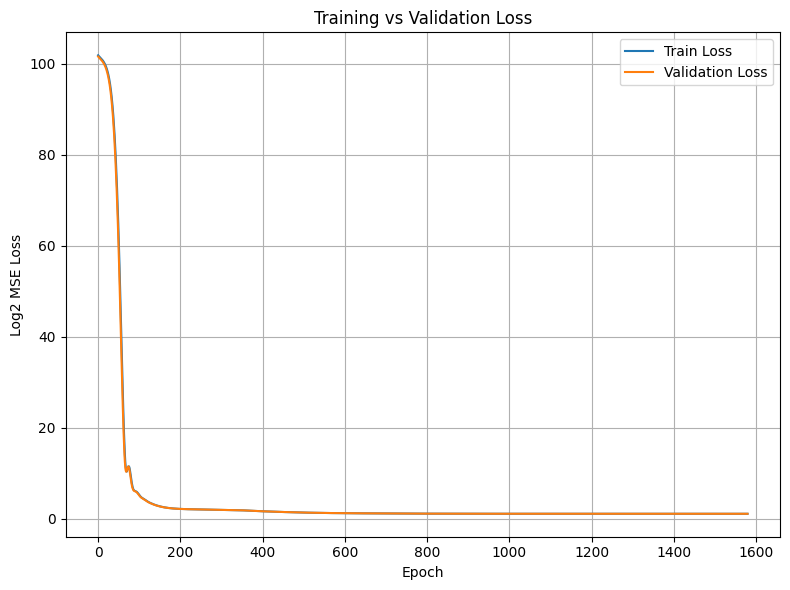

Test Loss: 1.1180
✅ Encoder-Decoder model saved as encoder_decoder_model.pth
✅ Scaler saved as scaler.pkl


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

df_104 = grouped_dfs[(10, 4)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_104.apply(preprocess, axis=1))
y = df_104['result'].values
y_log = np.log2(np.clip(y, 1e-6, None))

X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

class EncoderDecoder(nn.Module):
    def __init__(self, input_dim=43, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

ed_model = EncoderDecoder().to(device)

optimizer = optim.Adam(ed_model.parameters(), lr=0.001)
num_epochs = 3000

patience = 20
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ed_model.train()
    y_pred = ed_model(X_train)
    loss = log2_mse_loss(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ed_model.eval()
    with torch.no_grad():
        val_pred = ed_model(X_val)
        val_loss = log2_mse_loss(val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    if val_loss.item() + min_delta < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = ed_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
        break

if best_model_state is not None:
    ed_model.load_state_dict(best_model_state)

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log2 MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ed_model.eval()
with torch.no_grad():
    test_pred = ed_model(X_test)
    test_loss = log2_mse_loss(test_pred, y_test)

print(f"Test Loss: {test_loss:.4f}")

torch.save(ed_model.state_dict(), f"10_4_encoder_decoder_model.pth")
print("✅ Encoder-Decoder model saved as encoder_decoder_model.pth")

joblib.dump(scaler, "10_4_scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

# MLP Classifier Model Training

Epoch 0 | Train Loss: 3.0464 | Val Acc: 0.0497
Epoch 10 | Train Loss: 2.9240 | Val Acc: 0.0497
Epoch 20 | Train Loss: 2.8618 | Val Acc: 0.0499
Epoch 30 | Train Loss: 2.8169 | Val Acc: 0.0512
Epoch 40 | Train Loss: 2.7663 | Val Acc: 0.0754
Epoch 50 | Train Loss: 2.7095 | Val Acc: 0.1068
Epoch 60 | Train Loss: 2.6479 | Val Acc: 0.1187
Epoch 70 | Train Loss: 2.5854 | Val Acc: 0.1357
Epoch 80 | Train Loss: 2.5237 | Val Acc: 0.1514
Epoch 90 | Train Loss: 2.4656 | Val Acc: 0.1604
Test Accuracy: 0.1696
✅ Classifier model saved as classifier_mlp_model.pth


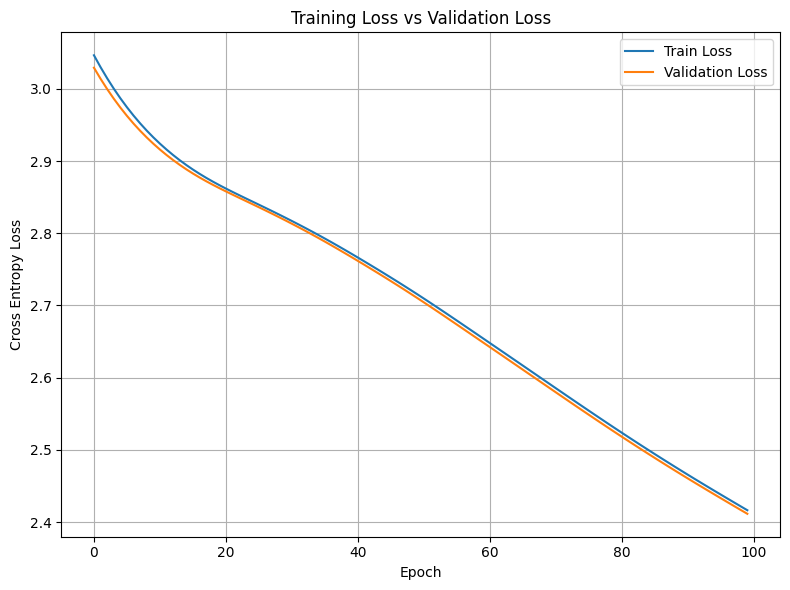

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

trained_encoder = ed_model.encoder

result_values = df_104['result'].values

df_104['class'] = pd.qcut(np.log2(result_values), q=20, labels=False, duplicates='drop')

X_full = np.vstack(df_104.apply(preprocess, axis=1))
X_full_scaled = scaler.transform(X_full)
X_full_tensor = torch.tensor(X_full_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps = trained_encoder(X_full_tensor).cpu().numpy()

class_labels = df_104['class'].values
label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(class_labels)

X_cls_temp, X_cls_test, y_cls_temp, y_cls_test = train_test_split(compressed_reps, y_classes, test_size=0.15, random_state=42)
X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(X_cls_temp, y_cls_temp, test_size=0.1765, random_state=42)

X_cls_train = torch.tensor(X_cls_train, dtype=torch.float32).to(device)
X_cls_val = torch.tensor(X_cls_val, dtype=torch.float32).to(device)
X_cls_test = torch.tensor(X_cls_test, dtype=torch.float32).to(device)

y_cls_train = torch.tensor(y_cls_train, dtype=torch.long).to(device)
y_cls_val = torch.tensor(y_cls_val, dtype=torch.long).to(device)
y_cls_test = torch.tensor(y_cls_test, dtype=torch.long).to(device)

class ClassifierMLP(nn.Module):
    def __init__(self, input_dim=16, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

clf_model = ClassifierMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=0.001)

patience = 20
best_val_acc = 0.0
epochs_no_improve = 0
min_delta = 1e-4
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(100):
    clf_model.train()
    outputs = clf_model(X_cls_train)
    loss = criterion(outputs, y_cls_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    clf_model.eval()
    with torch.no_grad():
        val_outputs = clf_model(X_cls_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_loss = criterion(val_outputs, y_cls_val)
        val_acc = accuracy_score(y_cls_val.cpu(), val_preds.cpu())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_model_state = clf_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val acc {best_val_acc:.4f}")
        break

if best_model_state:
    clf_model.load_state_dict(best_model_state)

clf_model.eval()
with torch.no_grad():
    test_outputs = clf_model(X_cls_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = accuracy_score(y_cls_test.cpu(), test_preds.cpu())

print(f"Test Accuracy: {test_acc:.4f}")

torch.save(clf_model.state_dict(), "10_4_classifier_mlp_model.pth")
print("✅ Classifier model saved as classifier_mlp_model.pth")

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MLP Regressor Model Training


🔧 Training Regressor for class 0...
  Epoch 0 | Val log2-loss: 19.7977
  Epoch 100 | Val log2-loss: 0.3297
  Early stopping at epoch 121 with best val loss 0.3292
Test log2-loss: 0.3429


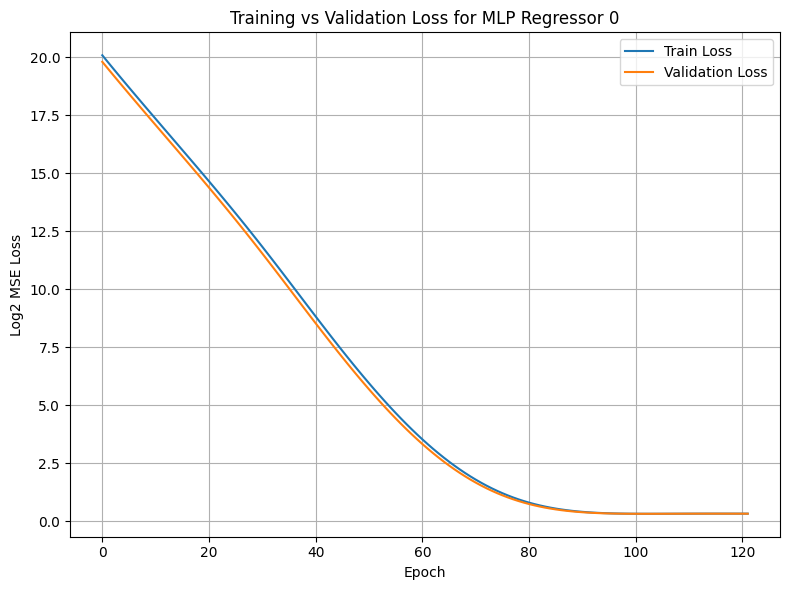


🔧 Training Regressor for class 1...
  Epoch 0 | Val log2-loss: 33.6180
  Epoch 100 | Val log2-loss: 1.4410
  Early stopping at epoch 154 with best val loss 0.2568
Test log2-loss: 0.2625


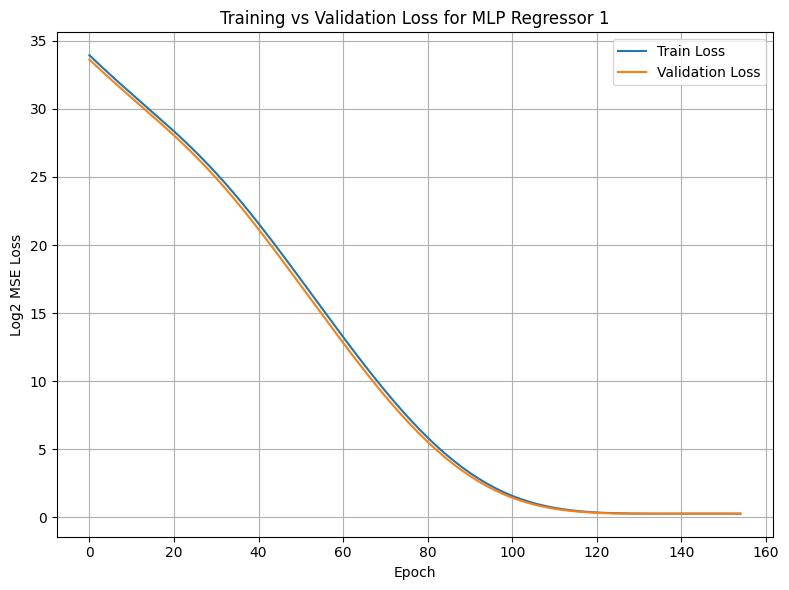


🔧 Training Regressor for class 2...
  Epoch 0 | Val log2-loss: 39.6558
  Epoch 100 | Val log2-loss: 2.8935
  Epoch 200 | Val log2-loss: 0.4200
  Epoch 300 | Val log2-loss: 0.4050
  Epoch 400 | Val log2-loss: 0.3877
  Epoch 500 | Val log2-loss: 0.3682
  Epoch 600 | Val log2-loss: 0.3427
  Epoch 700 | Val log2-loss: 0.3105
  Epoch 800 | Val log2-loss: 0.2694
  Epoch 900 | Val log2-loss: 0.2081
  Epoch 1000 | Val log2-loss: 0.1099
  Epoch 1100 | Val log2-loss: 0.0683
  Epoch 1200 | Val log2-loss: 0.0589
  Epoch 1300 | Val log2-loss: 0.0566
  Epoch 1400 | Val log2-loss: 0.0550
  Epoch 1500 | Val log2-loss: 0.0535
  Epoch 1600 | Val log2-loss: 0.0520
  Epoch 1700 | Val log2-loss: 0.0506
  Epoch 1800 | Val log2-loss: 0.0491
  Epoch 1900 | Val log2-loss: 0.0476
  Epoch 2000 | Val log2-loss: 0.0461
  Epoch 2100 | Val log2-loss: 0.0446
  Epoch 2200 | Val log2-loss: 0.0432
  Epoch 2300 | Val log2-loss: 0.0418
  Epoch 2400 | Val log2-loss: 0.0404
  Epoch 2500 | Val log2-loss: 0.0391
  Epoch 2600

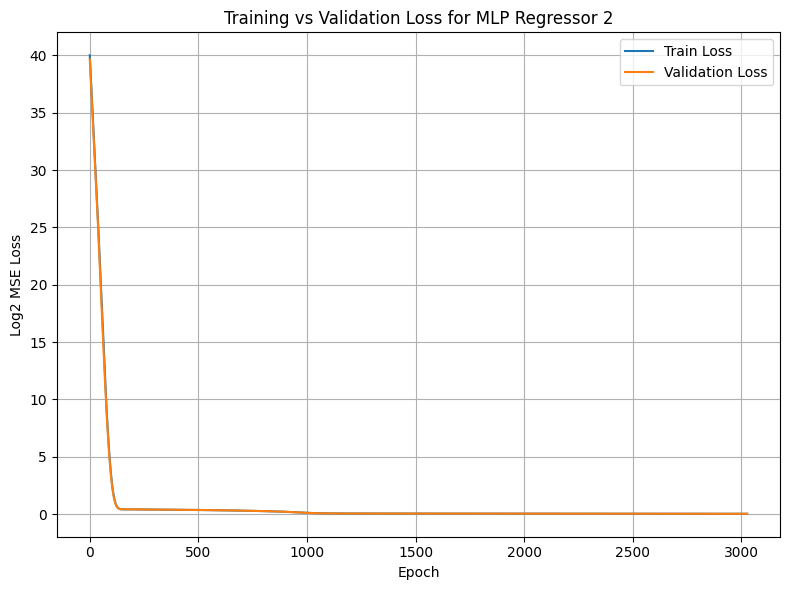


🔧 Training Regressor for class 3...
  Epoch 0 | Val log2-loss: 48.0910
  Epoch 100 | Val log2-loss: 4.1165
  Epoch 200 | Val log2-loss: 0.9009
  Epoch 300 | Val log2-loss: 0.8624
  Epoch 400 | Val log2-loss: 0.8168
  Epoch 500 | Val log2-loss: 0.7654
  Epoch 600 | Val log2-loss: 0.7085
  Epoch 700 | Val log2-loss: 0.6434
  Epoch 800 | Val log2-loss: 0.5692
  Epoch 900 | Val log2-loss: 0.4872
  Epoch 1000 | Val log2-loss: 0.4007
  Epoch 1100 | Val log2-loss: 0.3149
  Epoch 1200 | Val log2-loss: 0.2389
  Epoch 1300 | Val log2-loss: 0.1809
  Epoch 1400 | Val log2-loss: 0.1427
  Epoch 1500 | Val log2-loss: 0.1197
  Epoch 1600 | Val log2-loss: 0.1052
  Epoch 1700 | Val log2-loss: 0.0946
  Epoch 1800 | Val log2-loss: 0.0855
  Epoch 1900 | Val log2-loss: 0.0770
  Epoch 2000 | Val log2-loss: 0.0690
  Epoch 2100 | Val log2-loss: 0.0613
  Epoch 2200 | Val log2-loss: 0.0540
  Epoch 2300 | Val log2-loss: 0.0472
  Epoch 2400 | Val log2-loss: 0.0410
  Epoch 2500 | Val log2-loss: 0.0356
  Epoch 2600

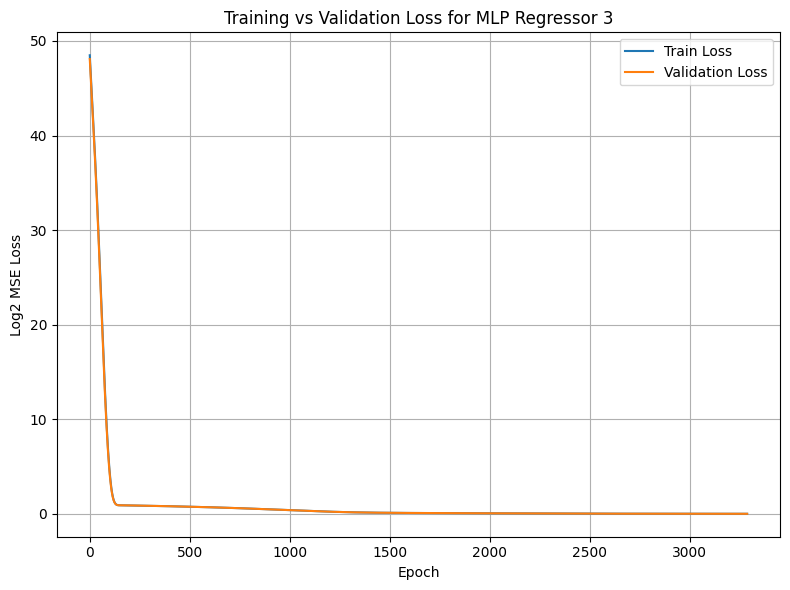


🔧 Training Regressor for class 4...
  Epoch 0 | Val log2-loss: 53.5785
  Epoch 100 | Val log2-loss: 4.6454
  Epoch 200 | Val log2-loss: 0.8380
  Epoch 300 | Val log2-loss: 0.8066
  Epoch 400 | Val log2-loss: 0.7693
  Epoch 500 | Val log2-loss: 0.7245
  Epoch 600 | Val log2-loss: 0.6672
  Epoch 700 | Val log2-loss: 0.5858
  Epoch 800 | Val log2-loss: 0.4717
  Epoch 900 | Val log2-loss: 0.3236
  Epoch 1000 | Val log2-loss: 0.1902
  Epoch 1100 | Val log2-loss: 0.1189
  Epoch 1200 | Val log2-loss: 0.0922
  Epoch 1300 | Val log2-loss: 0.0782
  Epoch 1400 | Val log2-loss: 0.0663
  Epoch 1500 | Val log2-loss: 0.0549
  Epoch 1600 | Val log2-loss: 0.0441
  Epoch 1700 | Val log2-loss: 0.0341
  Epoch 1800 | Val log2-loss: 0.0255
  Epoch 1900 | Val log2-loss: 0.0186
  Epoch 2000 | Val log2-loss: 0.0135
  Epoch 2100 | Val log2-loss: 0.0100
  Epoch 2200 | Val log2-loss: 0.0078
  Epoch 2300 | Val log2-loss: 0.0066
  Epoch 2400 | Val log2-loss: 0.0059
  Early stopping at epoch 2400 with best val loss

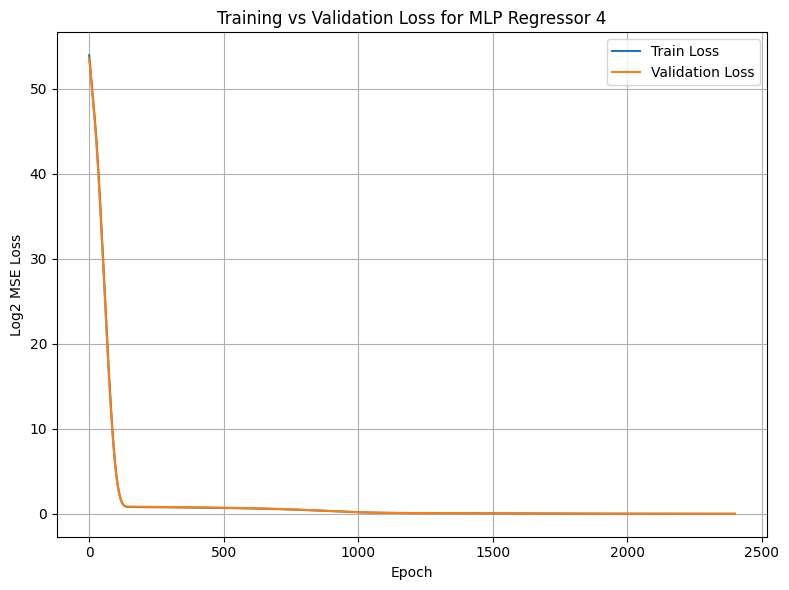


🔧 Training Regressor for class 5...
  Epoch 0 | Val log2-loss: 48.5280
  Epoch 100 | Val log2-loss: 1.1768
  Early stopping at epoch 141 with best val loss 0.7325
Test log2-loss: 0.7215


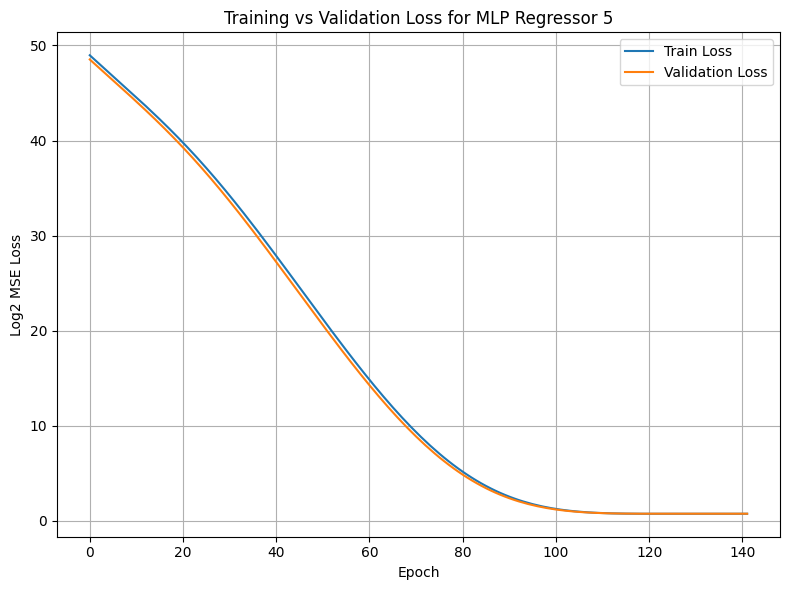


🔧 Training Regressor for class 6...
  Epoch 0 | Val log2-loss: 60.8573
  Epoch 100 | Val log2-loss: 6.0113
  Epoch 200 | Val log2-loss: 1.0980
  Epoch 300 | Val log2-loss: 1.0208
  Epoch 400 | Val log2-loss: 0.9177
  Epoch 500 | Val log2-loss: 0.7682
  Epoch 600 | Val log2-loss: 0.5104
  Epoch 700 | Val log2-loss: 0.2744
  Epoch 800 | Val log2-loss: 0.1410
  Epoch 900 | Val log2-loss: 0.0867
  Epoch 1000 | Val log2-loss: 0.0677
  Epoch 1100 | Val log2-loss: 0.0602
  Epoch 1200 | Val log2-loss: 0.0561
  Epoch 1300 | Val log2-loss: 0.0532
  Epoch 1400 | Val log2-loss: 0.0509
  Epoch 1500 | Val log2-loss: 0.0490
  Epoch 1600 | Val log2-loss: 0.0472
  Epoch 1700 | Val log2-loss: 0.0456
  Epoch 1800 | Val log2-loss: 0.0440
  Epoch 1900 | Val log2-loss: 0.0425
  Epoch 2000 | Val log2-loss: 0.0410
  Epoch 2100 | Val log2-loss: 0.0394
  Epoch 2200 | Val log2-loss: 0.0378
  Epoch 2300 | Val log2-loss: 0.0362
  Epoch 2400 | Val log2-loss: 0.0346
  Epoch 2500 | Val log2-loss: 0.0329
  Epoch 2600

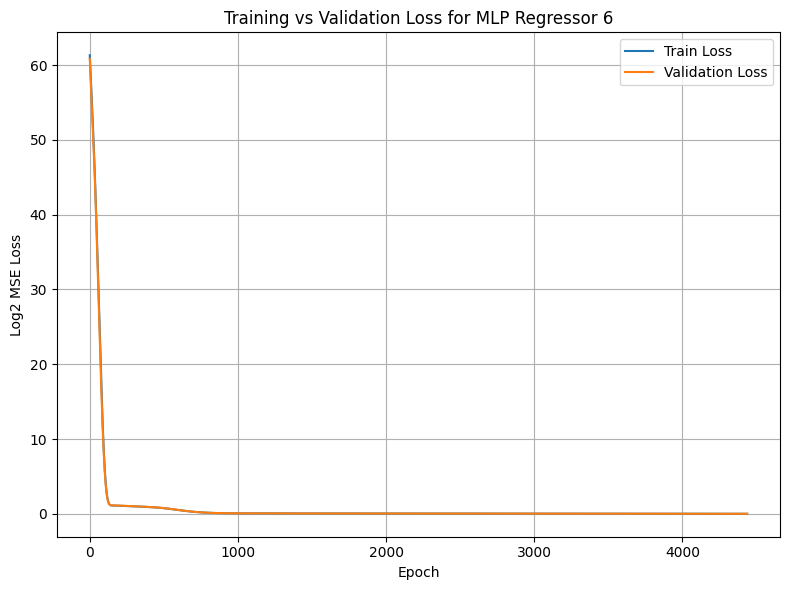


🔧 Training Regressor for class 7...
  Epoch 0 | Val log2-loss: 63.3380
  Epoch 100 | Val log2-loss: 4.1188
  Epoch 200 | Val log2-loss: 1.6322
  Epoch 300 | Val log2-loss: 1.4455
  Epoch 400 | Val log2-loss: 1.2224
  Epoch 500 | Val log2-loss: 0.9431
  Epoch 600 | Val log2-loss: 0.5542
  Epoch 700 | Val log2-loss: 0.1758
  Epoch 800 | Val log2-loss: 0.0659
  Epoch 900 | Val log2-loss: 0.0437
  Epoch 1000 | Val log2-loss: 0.0362
  Epoch 1100 | Val log2-loss: 0.0321
  Epoch 1200 | Val log2-loss: 0.0296
  Epoch 1300 | Val log2-loss: 0.0279
  Epoch 1400 | Val log2-loss: 0.0268
  Epoch 1500 | Val log2-loss: 0.0261
  Epoch 1600 | Val log2-loss: 0.0255
  Early stopping at epoch 1619 with best val loss 0.0255
Test log2-loss: 0.0274


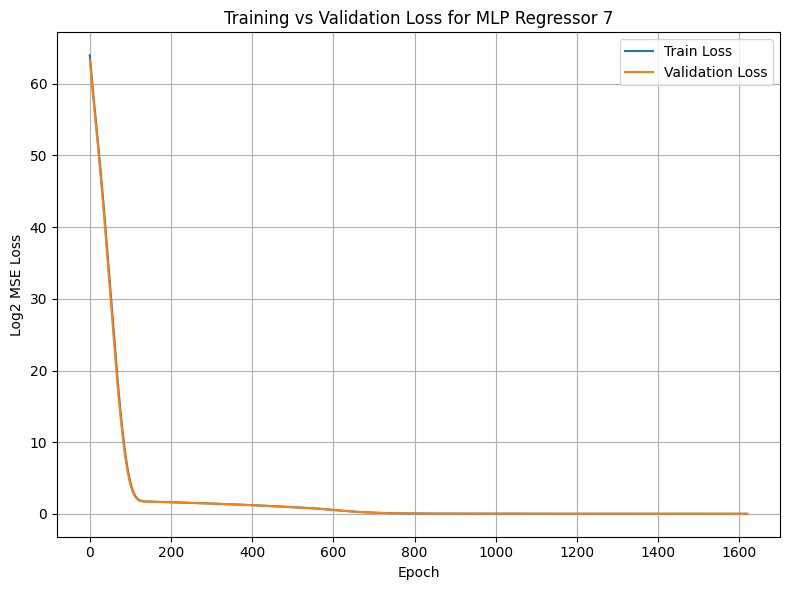


🔧 Training Regressor for class 8...
  Epoch 0 | Val log2-loss: 68.3210
  Epoch 100 | Val log2-loss: 5.5540
  Epoch 200 | Val log2-loss: 1.4137
  Epoch 300 | Val log2-loss: 1.1513
  Epoch 400 | Val log2-loss: 0.7771
  Epoch 500 | Val log2-loss: 0.4456
  Epoch 600 | Val log2-loss: 0.2331
  Epoch 700 | Val log2-loss: 0.1263
  Epoch 800 | Val log2-loss: 0.0771
  Epoch 900 | Val log2-loss: 0.0522
  Epoch 1000 | Val log2-loss: 0.0381
  Epoch 1100 | Val log2-loss: 0.0294
  Epoch 1200 | Val log2-loss: 0.0239
  Epoch 1300 | Val log2-loss: 0.0206
  Epoch 1400 | Val log2-loss: 0.0186
  Epoch 1500 | Val log2-loss: 0.0174
  Epoch 1600 | Val log2-loss: 0.0167
  Early stopping at epoch 1626 with best val loss 0.0167
Test log2-loss: 0.0166


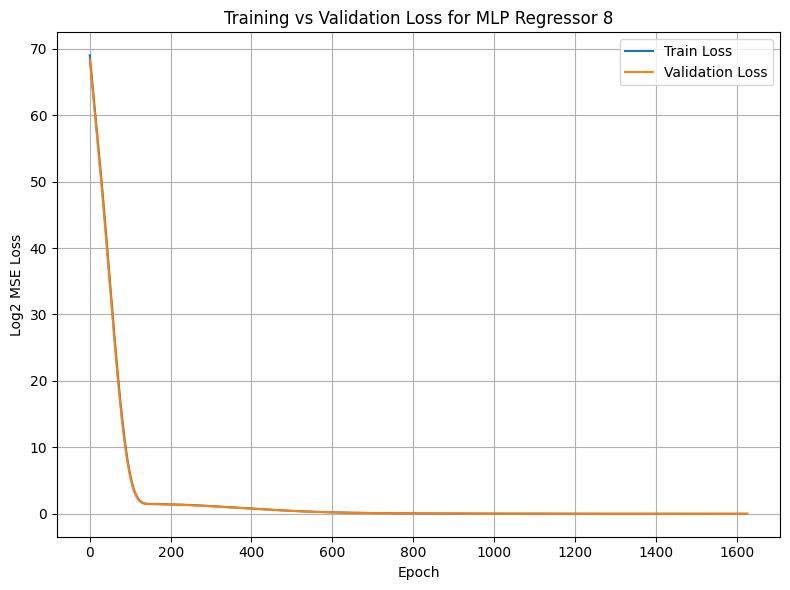


🔧 Training Regressor for class 9...
  Epoch 0 | Val log2-loss: 67.9136
  Epoch 100 | Val log2-loss: 0.6863
  Early stopping at epoch 128 with best val loss 0.6261
Test log2-loss: 0.6284


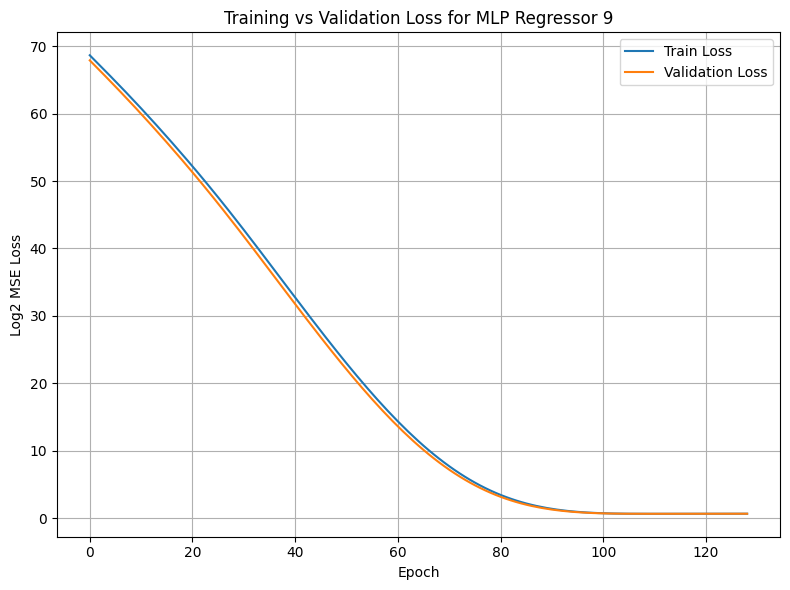


🔧 Training Regressor for class 10...
  Epoch 0 | Val log2-loss: 74.4769
  Epoch 100 | Val log2-loss: 0.6156
  Early stopping at epoch 130 with best val loss 0.4980
Test log2-loss: 0.5208


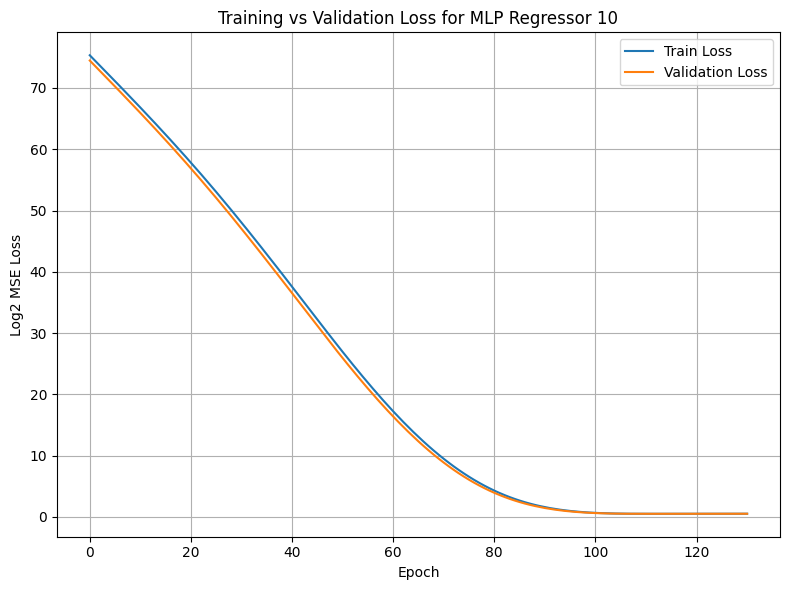


🔧 Training Regressor for class 11...
  Epoch 0 | Val log2-loss: 69.7982
  Epoch 100 | Val log2-loss: 2.8055
  Epoch 200 | Val log2-loss: 2.3469
  Epoch 300 | Val log2-loss: 1.8915
  Epoch 400 | Val log2-loss: 1.4569
  Epoch 500 | Val log2-loss: 1.0617
  Epoch 600 | Val log2-loss: 0.7280
  Epoch 700 | Val log2-loss: 0.4762
  Epoch 800 | Val log2-loss: 0.3020
  Epoch 900 | Val log2-loss: 0.1885
  Epoch 1000 | Val log2-loss: 0.1471
  Epoch 1100 | Val log2-loss: 0.1278
  Epoch 1200 | Val log2-loss: 0.1133
  Epoch 1300 | Val log2-loss: 0.1013
  Epoch 1400 | Val log2-loss: 0.0913
  Epoch 1500 | Val log2-loss: 0.0817
  Epoch 1600 | Val log2-loss: 0.0645
  Epoch 1700 | Val log2-loss: 0.0554
  Epoch 1800 | Val log2-loss: 0.0496
  Epoch 1900 | Val log2-loss: 0.0455
  Epoch 2000 | Val log2-loss: 0.0427
  Epoch 2100 | Val log2-loss: 0.0406
  Epoch 2200 | Val log2-loss: 0.0392
  Epoch 2300 | Val log2-loss: 0.0381
  Epoch 2400 | Val log2-loss: 0.0374
  Epoch 2500 | Val log2-loss: 0.0368
  Early sto

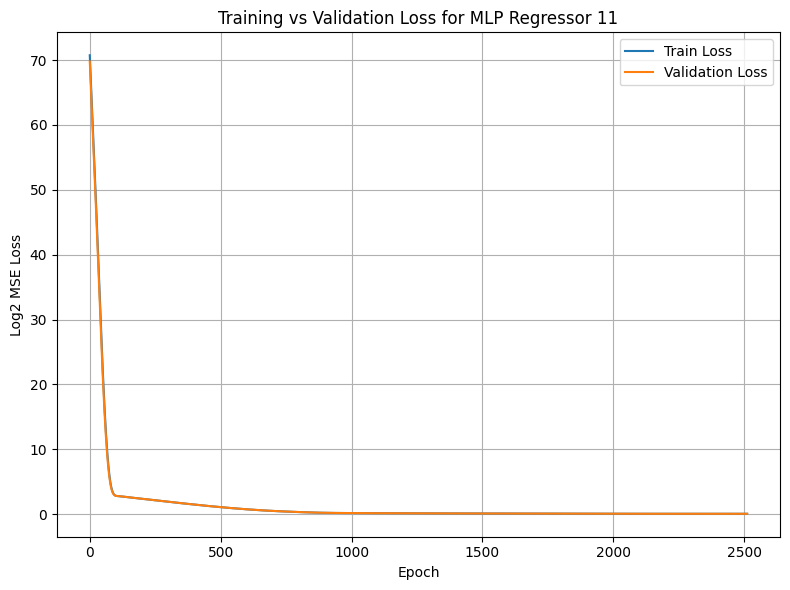


🔧 Training Regressor for class 12...
  Epoch 0 | Val log2-loss: 92.1730
  Epoch 100 | Val log2-loss: 1.7954
  Epoch 200 | Val log2-loss: 1.5946
  Epoch 300 | Val log2-loss: 1.3849
  Epoch 400 | Val log2-loss: 1.1750
  Epoch 500 | Val log2-loss: 0.9714
  Epoch 600 | Val log2-loss: 0.7793
  Epoch 700 | Val log2-loss: 0.6039
  Epoch 800 | Val log2-loss: 0.4509
  Epoch 900 | Val log2-loss: 0.3257
  Epoch 1000 | Val log2-loss: 0.2308
  Epoch 1100 | Val log2-loss: 0.1646
  Epoch 1200 | Val log2-loss: 0.1216
  Epoch 1300 | Val log2-loss: 0.0948
  Epoch 1400 | Val log2-loss: 0.0779
  Epoch 1500 | Val log2-loss: 0.0667
  Epoch 1600 | Val log2-loss: 0.0587
  Epoch 1700 | Val log2-loss: 0.0527
  Epoch 1800 | Val log2-loss: 0.0481
  Epoch 1900 | Val log2-loss: 0.0447
  Epoch 2000 | Val log2-loss: 0.0421
  Epoch 2100 | Val log2-loss: 0.0402
  Epoch 2200 | Val log2-loss: 0.0388
  Epoch 2300 | Val log2-loss: 0.0378
  Epoch 2400 | Val log2-loss: 0.0370
  Epoch 2500 | Val log2-loss: 0.0365
  Early sto

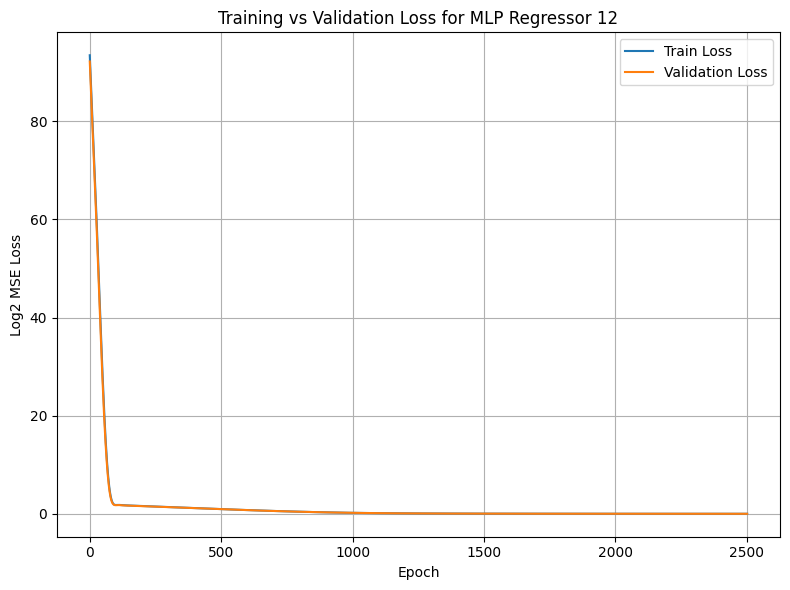


🔧 Training Regressor for class 13...
  Epoch 0 | Val log2-loss: 108.9194
  Epoch 100 | Val log2-loss: 1.1492
  Early stopping at epoch 133 with best val loss 0.7614
Test log2-loss: 0.7512


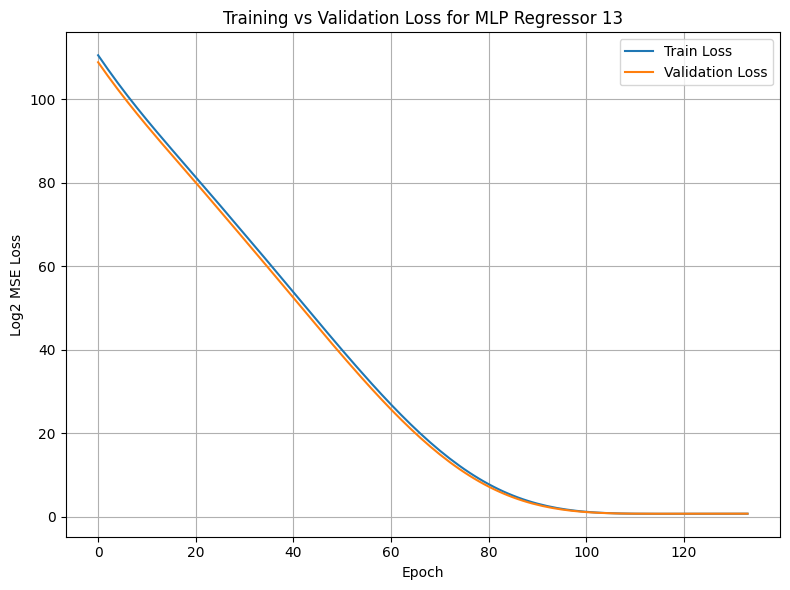


🔧 Training Regressor for class 14...
  Epoch 0 | Val log2-loss: 110.0949
  Epoch 100 | Val log2-loss: 0.4855
  Early stopping at epoch 113 with best val loss 0.4439
Test log2-loss: 0.4752


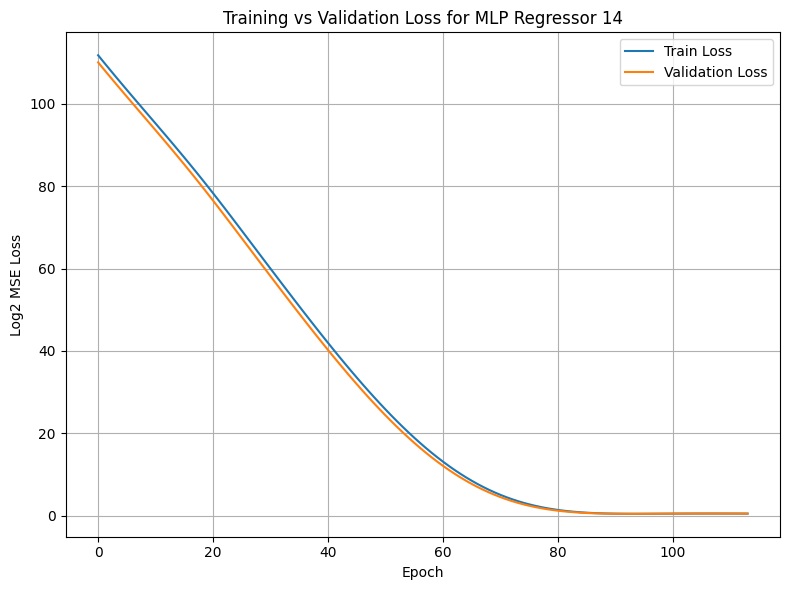


🔧 Training Regressor for class 15...
  Epoch 0 | Val log2-loss: 140.9806
  Epoch 100 | Val log2-loss: 4.6597
  Epoch 200 | Val log2-loss: 1.8758
  Epoch 300 | Val log2-loss: 1.7628
  Epoch 400 | Val log2-loss: 1.6411
  Epoch 500 | Val log2-loss: 1.5157
  Epoch 600 | Val log2-loss: 1.3900
  Epoch 700 | Val log2-loss: 1.2660
  Epoch 800 | Val log2-loss: 1.1428
  Epoch 900 | Val log2-loss: 1.0295
  Epoch 1000 | Val log2-loss: 0.9264
  Epoch 1100 | Val log2-loss: 0.8341
  Epoch 1200 | Val log2-loss: 0.7537
  Epoch 1300 | Val log2-loss: 0.6859
  Epoch 1400 | Val log2-loss: 0.6306
  Epoch 1500 | Val log2-loss: 0.5866
  Epoch 1600 | Val log2-loss: 0.5522
  Epoch 1700 | Val log2-loss: 0.5251
  Epoch 1800 | Val log2-loss: 0.5030
  Epoch 1900 | Val log2-loss: 0.4842
  Epoch 2000 | Val log2-loss: 0.4674
  Epoch 2100 | Val log2-loss: 0.4518
  Epoch 2200 | Val log2-loss: 0.4371
  Epoch 2300 | Val log2-loss: 0.4229
  Epoch 2400 | Val log2-loss: 0.4092
  Epoch 2500 | Val log2-loss: 0.3961
  Epoch 26

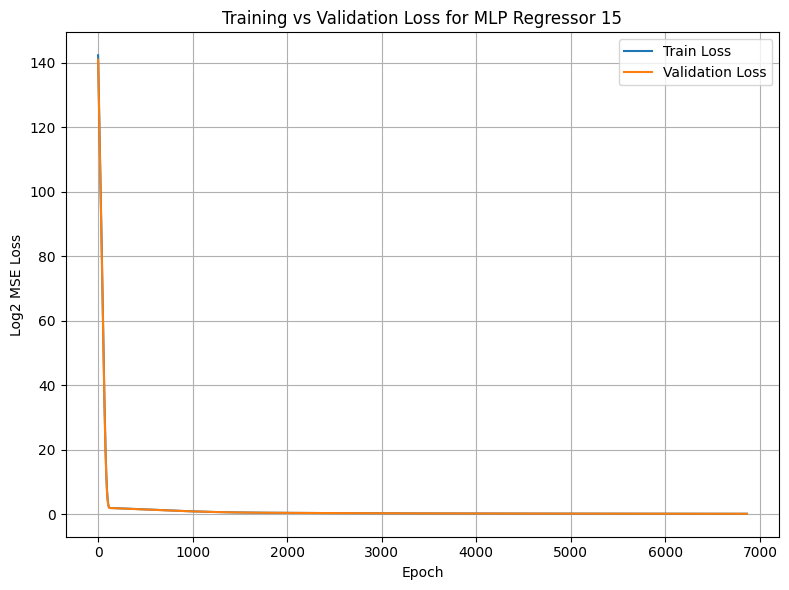


🔧 Training Regressor for class 16...
  Epoch 0 | Val log2-loss: 173.7465
  Epoch 100 | Val log2-loss: 1.6522
  Early stopping at epoch 119 with best val loss 1.6501
Test log2-loss: 1.6597


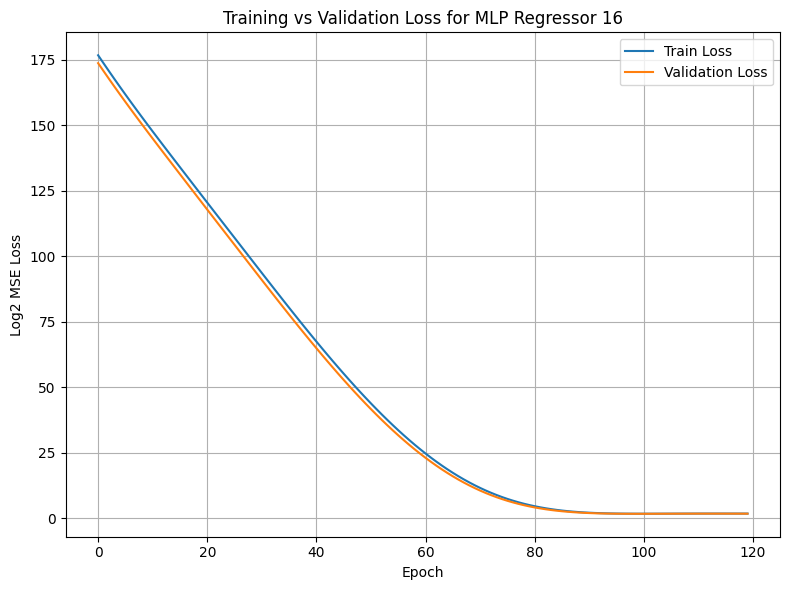


🔧 Training Regressor for class 17...
  Epoch 0 | Val log2-loss: 220.3311
  Epoch 100 | Val log2-loss: 0.5173
  Early stopping at epoch 128 with best val loss 0.3712
Test log2-loss: 0.4364


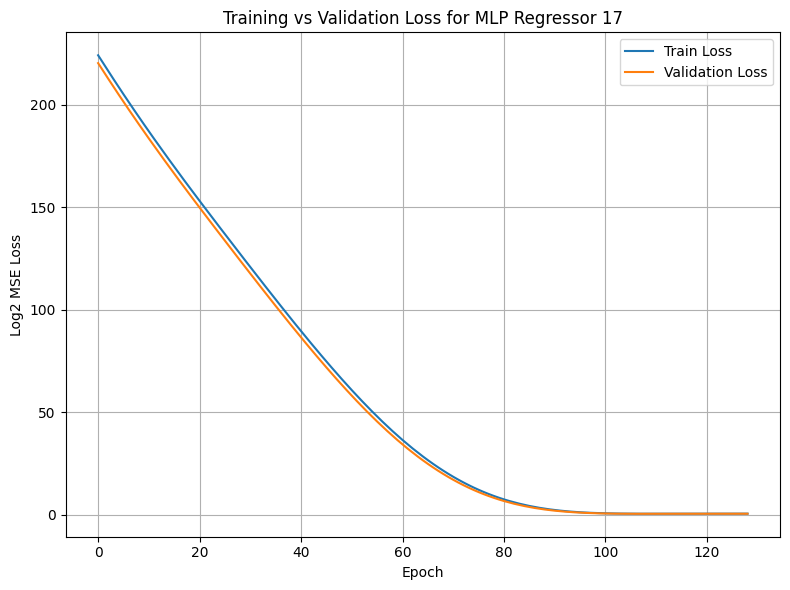


🔧 Training Regressor for class 18...
  Epoch 0 | Val log2-loss: 251.3701
  Epoch 100 | Val log2-loss: 7.3068
  Early stopping at epoch 156 with best val loss 0.2873
Test log2-loss: 0.2912


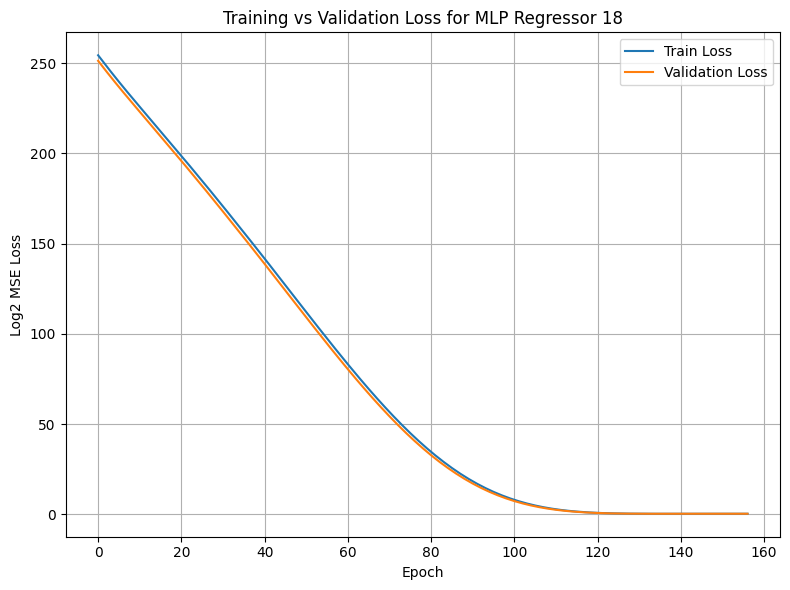


🔧 Training Regressor for class 19...
  Epoch 0 | Val log2-loss: 323.8700
  Epoch 100 | Val log2-loss: 14.5523
  Early stopping at epoch 158 with best val loss 2.2832
Test log2-loss: 2.2579


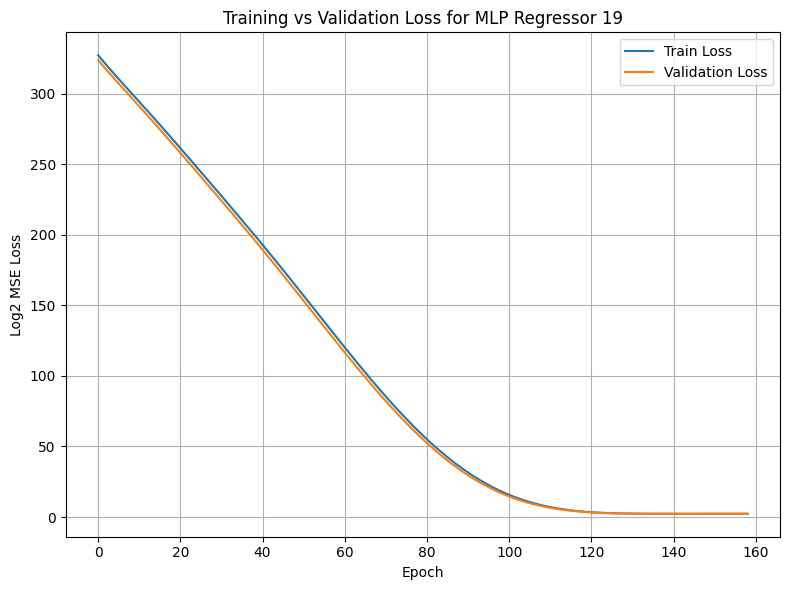

✅ Saved MLP regressors at 10_4_MLP_regressor_models


In [ ]:
import matplotlib.pyplot as plt
import torch
import os

regressors = {}

compressed_reps_tensor = torch.tensor(compressed_reps, dtype=torch.float32).to(device)
log_result_values = np.log2(np.clip(df_104['result'].values, 1e-6, None))
log_result_tensor = torch.tensor(log_result_values, dtype=torch.float32).view(-1, 1).to(device)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

for class_id in range(20):
    print(f"\n🔧 Training Regressor for class {class_id}...")
    class_mask = df_104['class'].values == class_id

    X_class = compressed_reps_tensor[class_mask]
    y_class = log_result_tensor[class_mask]

    if X_class.size(0) < 10:
        print(f"  Skipping class {class_id} (too few samples)")
        continue

    X_temp, X_test, y_temp, y_test = train_test_split(X_class, y_class, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

    reg_model = MLPRegressor().to(device)
    optimizer = optim.Adam(reg_model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    patience = 20
    epochs_no_improve = 0
    min_delta = 1e-4
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(10000):
        reg_model.train()
        y_pred = reg_model(X_train)
        loss = log2_mse_loss(y_pred,y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reg_model.eval()
        with torch.no_grad():
            val_pred = reg_model(X_val)
            val_loss = log2_mse_loss(val_pred, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 100 == 0:
            print(f"  Epoch {epoch} | Val log2-loss: {val_loss.item():.4f}")

        if val_loss.item() + min_delta < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = reg_model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
            break

    if best_model_state:
        reg_model.load_state_dict(best_model_state)
    regressors[class_id] = reg_model

    reg_model.eval()
    with torch.no_grad():
        test_pred = reg_model(X_test)
        test_loss = log2_mse_loss(test_pred, y_test)

    print(f"Test log2-loss: {test_loss.item():.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log2 MSE Loss")
    plt.title(f"Training vs Validation Loss for MLP Regressor {class_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

os.makedirs("10_4_MLP_regressor_models", exist_ok=True)

for class_id, model in regressors.items():
    model_path = f"10_4_MLP_regressor_models/10_4_MLP_regressor_{class_id}.pth"
    torch.save(model.state_dict(), model_path)

print(f"✅ Saved MLP regressors at 10_4_MLP_regressor_models")

# Final Model Testing

In [ ]:
df_104_test = grouped_dfs[(10, 4)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_104_test.apply(preprocess, axis=1))
y = df_104_test['result'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_full_scaled_test = scaler.transform(X_test)
X_full_tensor_test = torch.tensor(X_full_scaled_test, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps_test = trained_encoder(X_full_tensor_test).cpu().numpy()

compressed_reps_test_tensor = torch.tensor(compressed_reps_test, dtype=torch.float32).to(device)

clf_model.eval()
with torch.no_grad():
    test_outputs_clf = clf_model(compressed_reps_test_tensor)
    test_pred_clf = torch.argmax(test_outputs_clf, dim=1).cpu().numpy()

y_true_actual = y_test
y_pred_actual = []

for i in range(len(X_test)):
    class_id = int(test_pred_clf[i])

    if class_id not in regressors:
        y_pred_actual.append(0.0)
        continue

    regressor = regressors[class_id]
    regressor.eval()

    input_tensor = compressed_reps_test_tensor[i].unsqueeze(0)

    with torch.no_grad():
        log_pred = regressor(input_tensor)
        pred_value = torch.pow(2.0, log_pred).item()

    y_pred_actual.append(pred_value)

y_pred_actual = np.array(y_pred_actual)
y_true_actual = np.clip(y_true_actual, 1e-6, None)

def log2_mse_np(y_true, y_pred):
    y_true = np.clip(y_true, 1e-6, None)
    y_pred = np.clip(y_pred, 1e-6, None)
    return np.mean((np.log2(y_true) - np.log2(y_pred)) ** 2)

test_log2_loss = log2_mse_np(y_true_actual, y_pred_actual)
print(f"✅ Final Test Log2 Loss: {test_log2_loss:.4f}")

✅ Final Test Log2 Loss: 2.4375


/tmp/ipykernel_31/3591627150.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


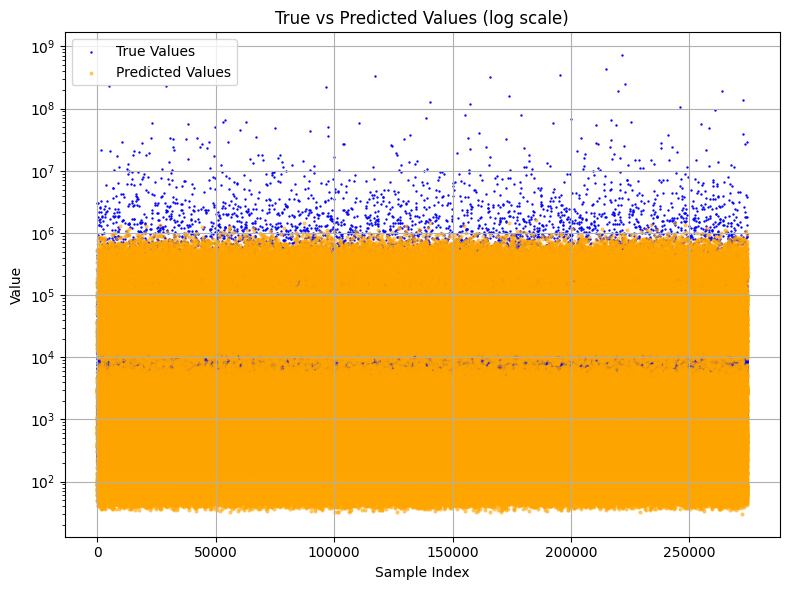

In [ ]:
import matplotlib.pyplot as plt

y_true = np.array(y_true_actual)
y_pred = np.array(y_pred_actual)

plt.figure(figsize=(8, 6))

plt.scatter(range(len(y_true)), y_true, label='True Values', color='blue', alpha=1, s=0.5)

plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.5, s=4)

plt.title('True vs Predicted Values (log scale)')
plt.yscale('log')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Training for (10,5)

# Encoder Decoder Model Training

Using device: cuda
Epoch 0 | Train Loss: 130.3974 | Val Loss: 130.4144
Epoch 100 | Train Loss: 3.1221 | Val Loss: 3.1130
Epoch 200 | Train Loss: 2.3231 | Val Loss: 2.3294
Epoch 300 | Train Loss: 1.7968 | Val Loss: 1.8010
Epoch 400 | Train Loss: 1.5153 | Val Loss: 1.5214
Epoch 500 | Train Loss: 1.4093 | Val Loss: 1.4164
Epoch 600 | Train Loss: 1.2903 | Val Loss: 1.2982
Epoch 700 | Train Loss: 1.2330 | Val Loss: 1.2418
Epoch 800 | Train Loss: 1.2194 | Val Loss: 1.2286
Epoch 900 | Train Loss: 1.2147 | Val Loss: 1.2240
Epoch 1000 | Train Loss: 1.2135 | Val Loss: 1.2229
Epoch 1100 | Train Loss: 1.2115 | Val Loss: 1.2210
Early stopping at epoch 1168 with best val loss 1.2207


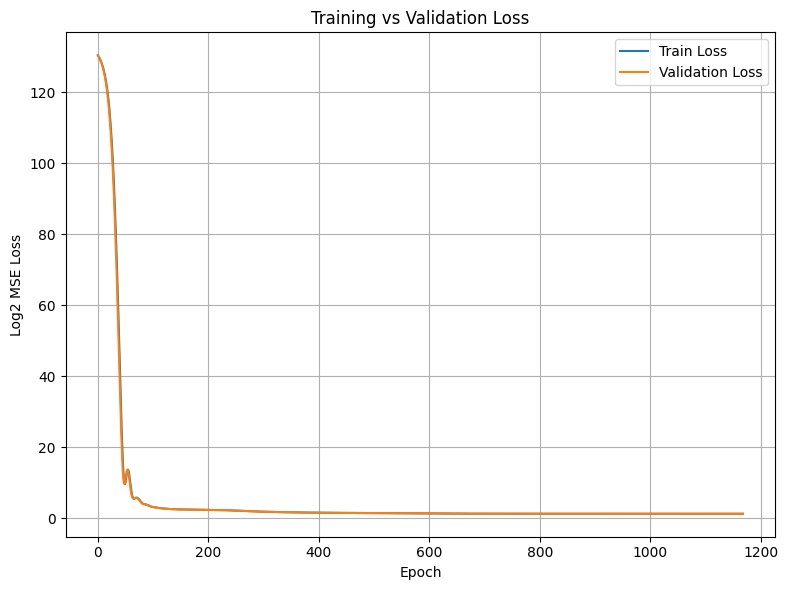

Test Loss: 1.2128
✅ Encoder-Decoder model saved as encoder_decoder_model.pth
✅ Scaler saved as scaler.pkl


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

df_105 = grouped_dfs[(10, 5)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_105.apply(preprocess, axis=1))
y = df_105['result'].values
y_log = np.log2(np.clip(y, 1e-6, None))

X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

class EncoderDecoder(nn.Module):
    def __init__(self, input_dim=53, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

ed_model = EncoderDecoder().to(device)

optimizer = optim.Adam(ed_model.parameters(), lr=0.001)
num_epochs = 3000

patience = 20
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ed_model.train()
    y_pred = ed_model(X_train)
    loss = log2_mse_loss(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ed_model.eval()
    with torch.no_grad():
        val_pred = ed_model(X_val)
        val_loss = log2_mse_loss(val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    if val_loss.item() + min_delta < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = ed_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
        break

if best_model_state is not None:
    ed_model.load_state_dict(best_model_state)

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log2 MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ed_model.eval()
with torch.no_grad():
    test_pred = ed_model(X_test)
    test_loss = log2_mse_loss(test_pred, y_test)

print(f"Test Loss: {test_loss:.4f}")

torch.save(ed_model.state_dict(), f"10_5_encoder_decoder_model.pth")
print("✅ Encoder-Decoder model saved as encoder_decoder_model.pth")

joblib.dump(scaler, "10_5_scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

# MLP Classifier Model Training

Epoch 0 | Train Loss: 3.0481 | Val Acc: 0.0425
Epoch 10 | Train Loss: 2.9510 | Val Acc: 0.0505
Epoch 20 | Train Loss: 2.8885 | Val Acc: 0.0501
Epoch 30 | Train Loss: 2.8343 | Val Acc: 0.0571
Epoch 40 | Train Loss: 2.7831 | Val Acc: 0.0807
Epoch 50 | Train Loss: 2.7288 | Val Acc: 0.0965
Epoch 60 | Train Loss: 2.6739 | Val Acc: 0.1165
Epoch 70 | Train Loss: 2.6197 | Val Acc: 0.1274
Epoch 80 | Train Loss: 2.5668 | Val Acc: 0.1308
Epoch 90 | Train Loss: 2.5175 | Val Acc: 0.1331
Test Accuracy: 0.1370
✅ Classifier model saved as classifier_mlp_model.pth


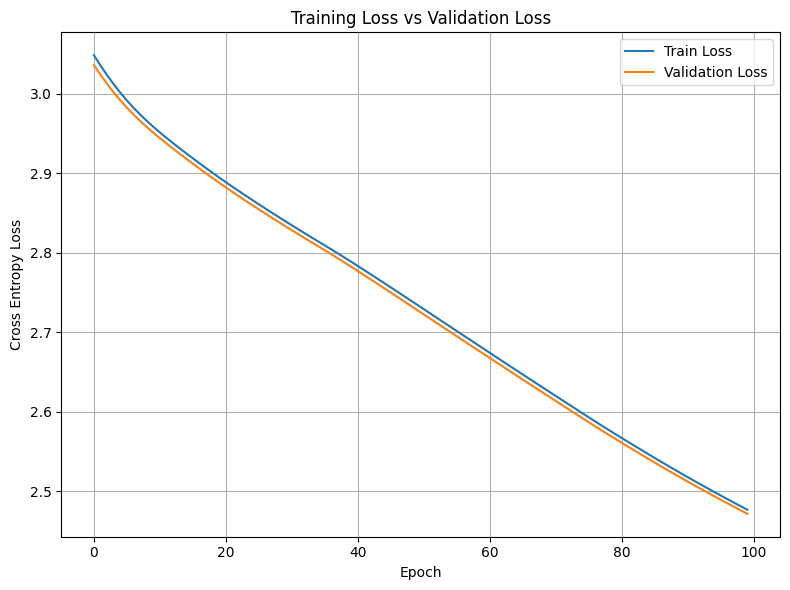

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

trained_encoder = ed_model.encoder

result_values = df_105['result'].values

df_105['class'] = pd.qcut(np.log2(result_values), q=20, labels=False, duplicates='drop')

X_full = np.vstack(df_105.apply(preprocess, axis=1))
X_full_scaled = scaler.transform(X_full)
X_full_tensor = torch.tensor(X_full_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps = trained_encoder(X_full_tensor).cpu().numpy()

class_labels = df_105['class'].values
label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(class_labels)

X_cls_temp, X_cls_test, y_cls_temp, y_cls_test = train_test_split(compressed_reps, y_classes, test_size=0.15, random_state=42)
X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(X_cls_temp, y_cls_temp, test_size=0.1765, random_state=42)

X_cls_train = torch.tensor(X_cls_train, dtype=torch.float32).to(device)
X_cls_val = torch.tensor(X_cls_val, dtype=torch.float32).to(device)
X_cls_test = torch.tensor(X_cls_test, dtype=torch.float32).to(device)

y_cls_train = torch.tensor(y_cls_train, dtype=torch.long).to(device)
y_cls_val = torch.tensor(y_cls_val, dtype=torch.long).to(device)
y_cls_test = torch.tensor(y_cls_test, dtype=torch.long).to(device)

class ClassifierMLP(nn.Module):
    def __init__(self, input_dim=16, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

clf_model = ClassifierMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=0.001)

patience = 20
best_val_acc = 0.0
epochs_no_improve = 0
min_delta = 1e-4
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(100):
    clf_model.train()
    outputs = clf_model(X_cls_train)
    loss = criterion(outputs, y_cls_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    clf_model.eval()
    with torch.no_grad():
        val_outputs = clf_model(X_cls_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_loss = criterion(val_outputs, y_cls_val)
        val_acc = accuracy_score(y_cls_val.cpu(), val_preds.cpu())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_model_state = clf_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val acc {best_val_acc:.4f}")
        break

if best_model_state:
    clf_model.load_state_dict(best_model_state)

clf_model.eval()
with torch.no_grad():
    test_outputs = clf_model(X_cls_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = accuracy_score(y_cls_test.cpu(), test_preds.cpu())

print(f"Test Accuracy: {test_acc:.4f}")

torch.save(clf_model.state_dict(), "10_5_classifier_mlp_model.pth")
print("✅ Classifier model saved as classifier_mlp_model.pth")

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MLP Regressor Model Training


🔧 Training Regressor for class 0...
  Epoch 0 | Val log2-loss: 52.0752
  Epoch 100 | Val log2-loss: 2.9759
  Early stopping at epoch 130 with best val loss 0.4834
Test log2-loss: 0.5577


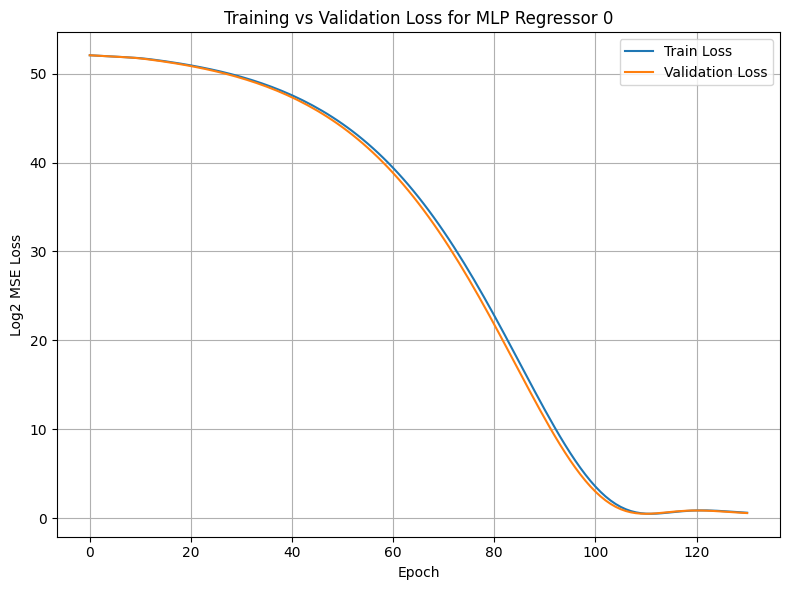


🔧 Training Regressor for class 1...
  Epoch 0 | Val log2-loss: 53.4902
  Epoch 100 | Val log2-loss: 22.8309
  Early stopping at epoch 150 with best val loss 0.4809
Test log2-loss: 0.5354


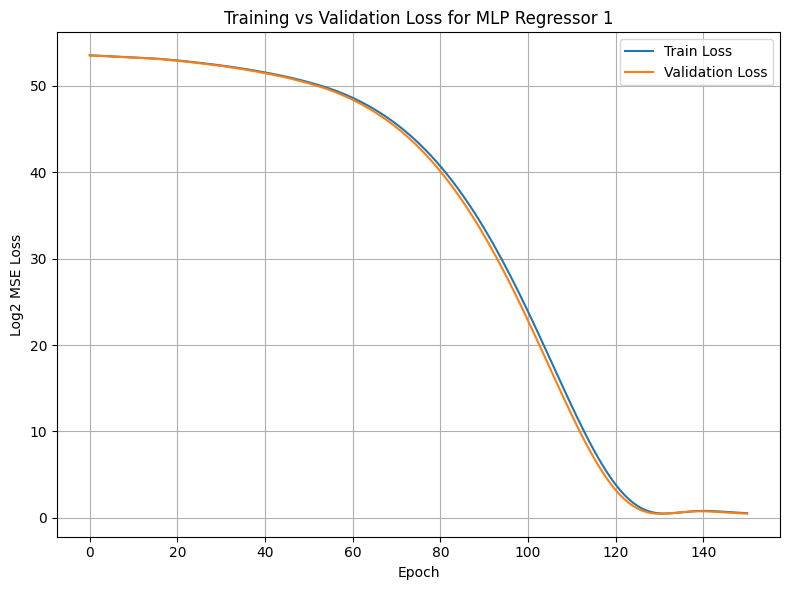


🔧 Training Regressor for class 2...
  Epoch 0 | Val log2-loss: 51.2322
  Epoch 100 | Val log2-loss: 1.2609
  Early stopping at epoch 125 with best val loss 0.5756
Test log2-loss: 0.6477


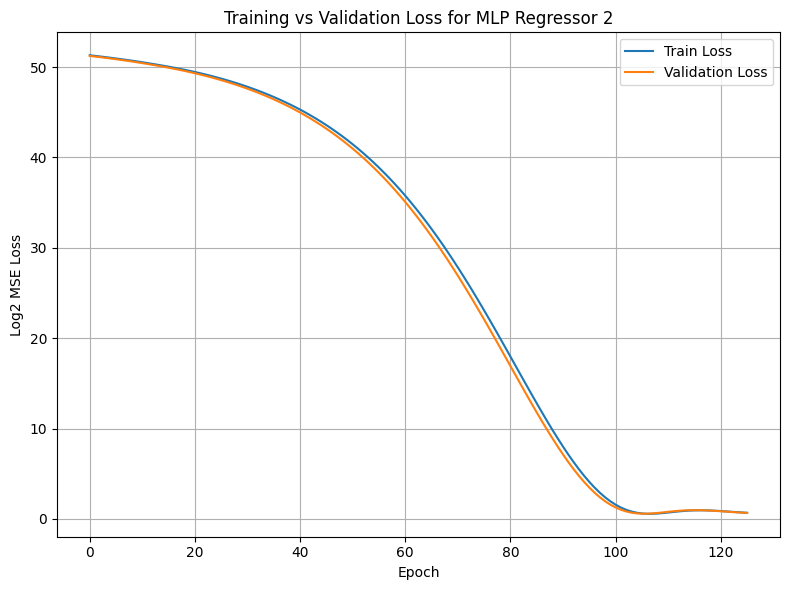


🔧 Training Regressor for class 3...
  Epoch 0 | Val log2-loss: 64.6971
  Epoch 100 | Val log2-loss: 36.5223
  Early stopping at epoch 156 with best val loss 1.0961
Test log2-loss: 1.1641


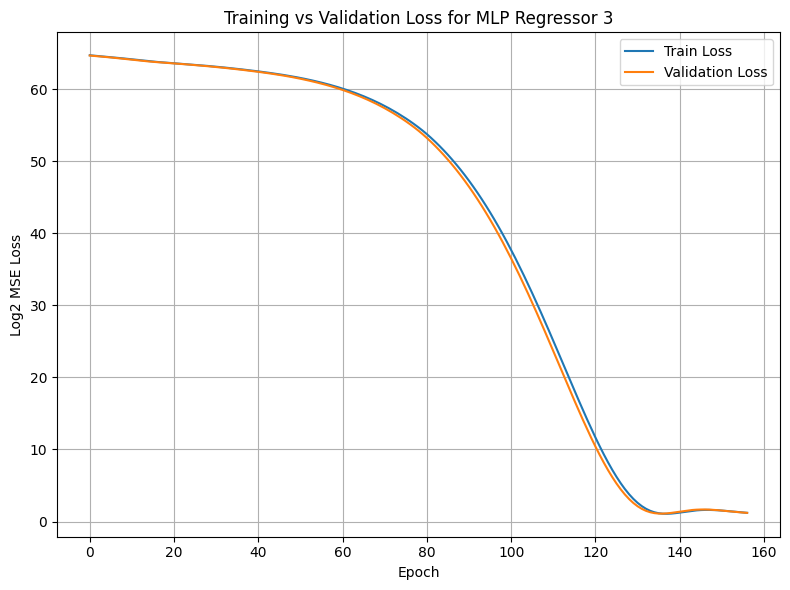


🔧 Training Regressor for class 4...
  Epoch 0 | Val log2-loss: 64.1523
  Epoch 100 | Val log2-loss: 17.2336
  Early stopping at epoch 143 with best val loss 1.3241
Test log2-loss: 1.3866


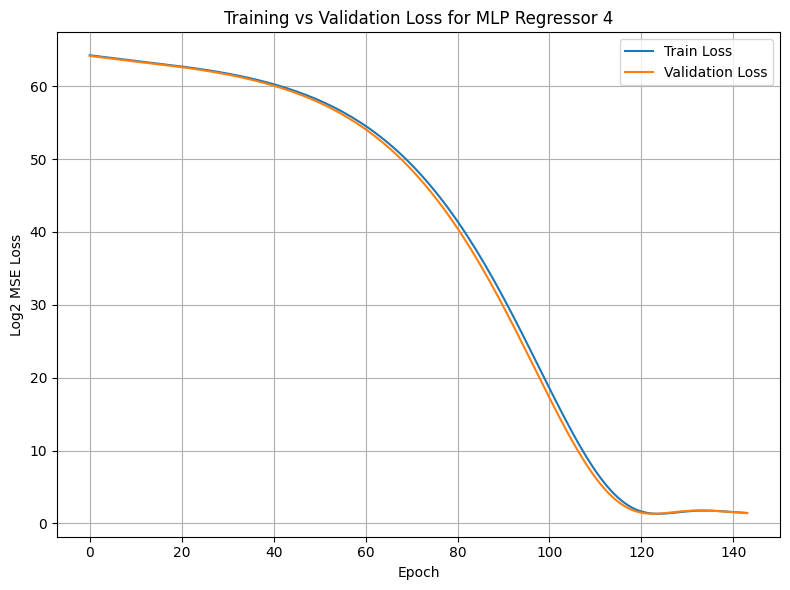


🔧 Training Regressor for class 5...
  Epoch 0 | Val log2-loss: 75.6376
  Epoch 100 | Val log2-loss: 55.0896
  Early stopping at epoch 162 with best val loss 1.5277
Test log2-loss: 1.6022


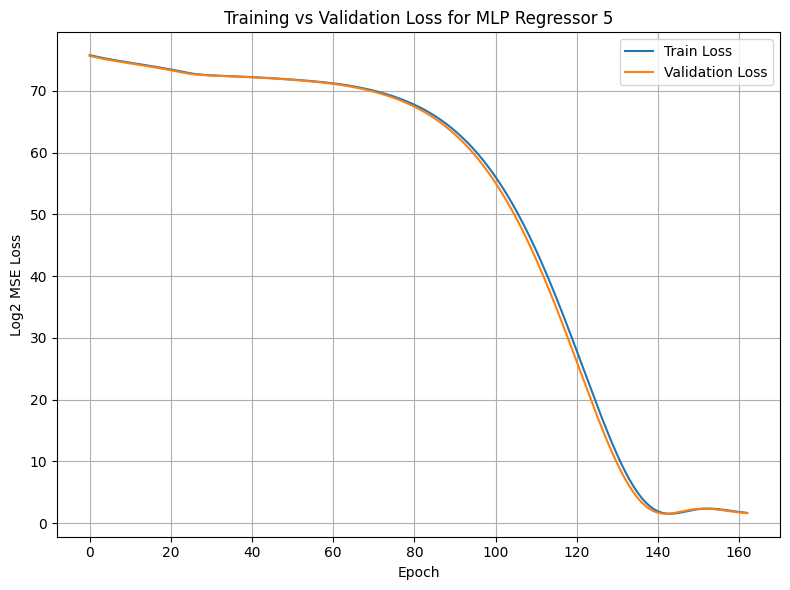


🔧 Training Regressor for class 6...
  Epoch 0 | Val log2-loss: 72.7058
  Epoch 100 | Val log2-loss: 1.8238
  Early stopping at epoch 113 with best val loss 1.0032
Test log2-loss: 1.1174


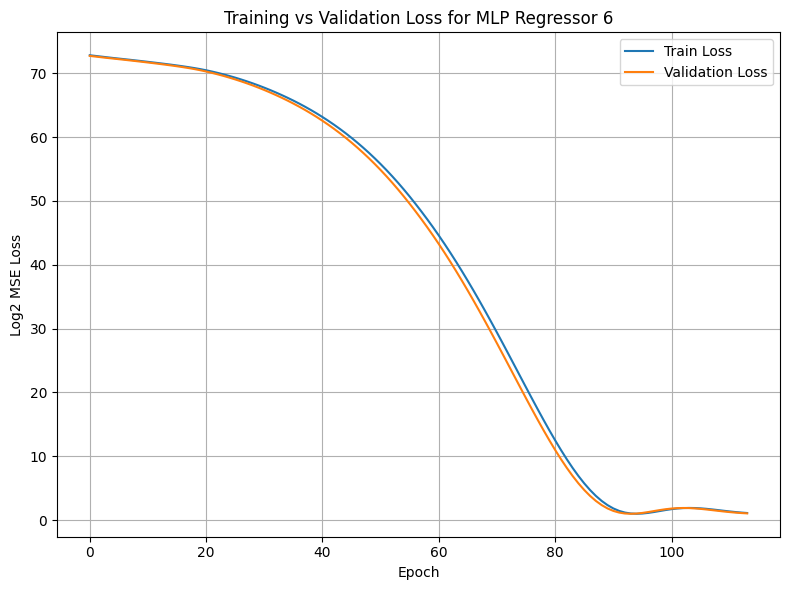


🔧 Training Regressor for class 7...
  Epoch 0 | Val log2-loss: 71.0626
  Epoch 100 | Val log2-loss: 23.4153
  Early stopping at epoch 141 with best val loss 0.6549
Test log2-loss: 0.6657


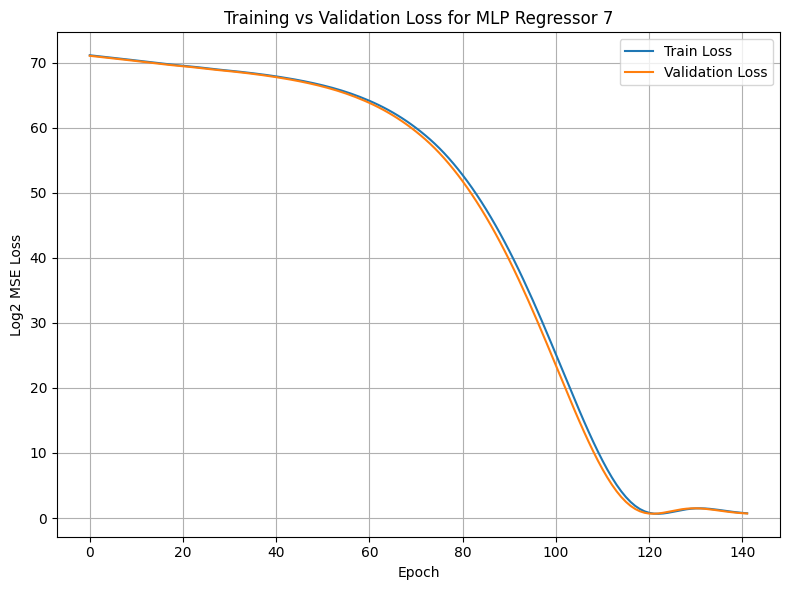


🔧 Training Regressor for class 8...
  Epoch 0 | Val log2-loss: 71.7441
  Epoch 100 | Val log2-loss: 4.6680
  Early stopping at epoch 128 with best val loss 0.8906
Test log2-loss: 0.9229


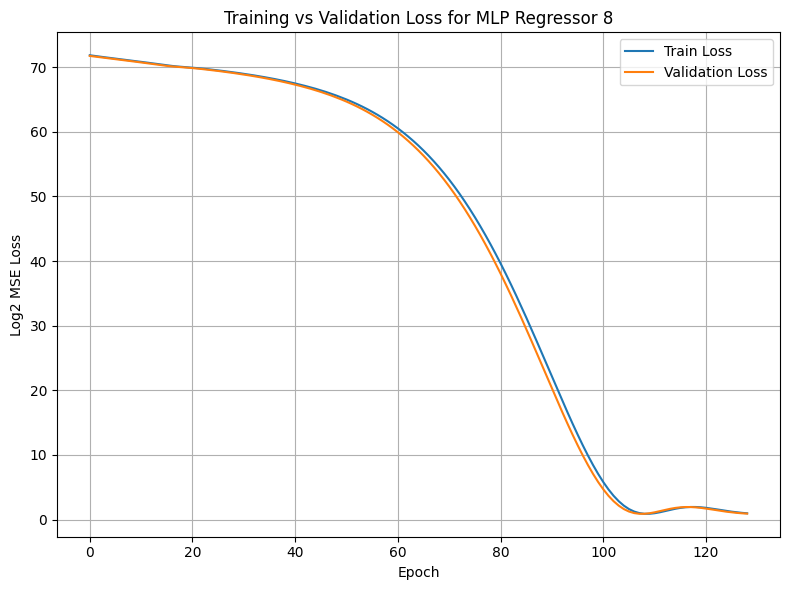


🔧 Training Regressor for class 9...
  Epoch 0 | Val log2-loss: 89.5117
  Epoch 100 | Val log2-loss: 87.6331
  Epoch 200 | Val log2-loss: 85.7838
  Epoch 300 | Val log2-loss: 83.9633
  Epoch 400 | Val log2-loss: 82.1712
  Epoch 500 | Val log2-loss: 80.4069
  Epoch 600 | Val log2-loss: 78.6698
  Epoch 700 | Val log2-loss: 76.9595
  Epoch 800 | Val log2-loss: 75.2755
  Epoch 900 | Val log2-loss: 73.6174
  Epoch 1000 | Val log2-loss: 71.9846
  Epoch 1100 | Val log2-loss: 70.3767
  Epoch 1200 | Val log2-loss: 68.7934
  Epoch 1300 | Val log2-loss: 67.2343
  Epoch 1400 | Val log2-loss: 65.6989
  Epoch 1500 | Val log2-loss: 64.1868
  Epoch 1600 | Val log2-loss: 62.6978
  Epoch 1700 | Val log2-loss: 61.2315
  Epoch 1800 | Val log2-loss: 59.7876
  Epoch 1900 | Val log2-loss: 58.3657
  Epoch 2000 | Val log2-loss: 56.9656
  Epoch 2100 | Val log2-loss: 55.5869
  Epoch 2200 | Val log2-loss: 54.2295
  Epoch 2300 | Val log2-loss: 52.8929
  Epoch 2400 | Val log2-loss: 51.5771
  Epoch 2500 | Val log2-l

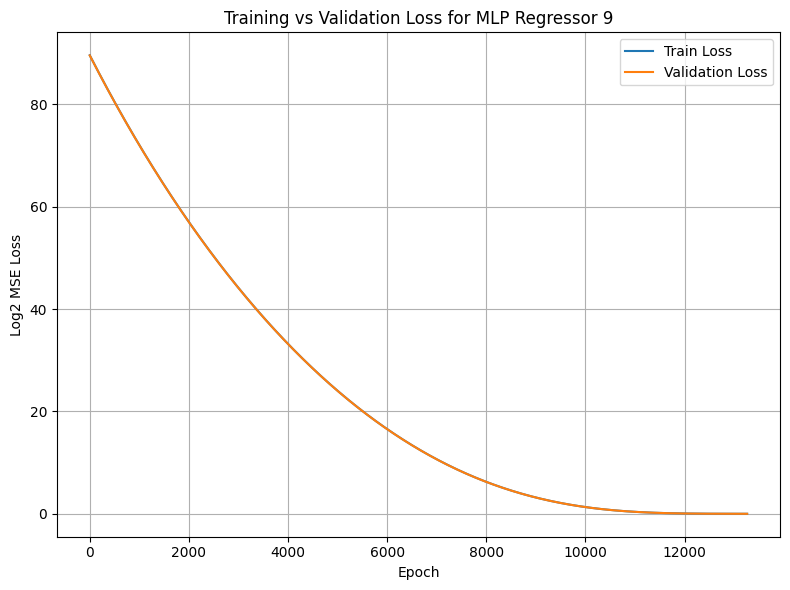


🔧 Training Regressor for class 10...
  Epoch 0 | Val log2-loss: 95.5562
  Epoch 100 | Val log2-loss: 2.3348
  Early stopping at epoch 121 with best val loss 2.3097
Test log2-loss: 2.3876


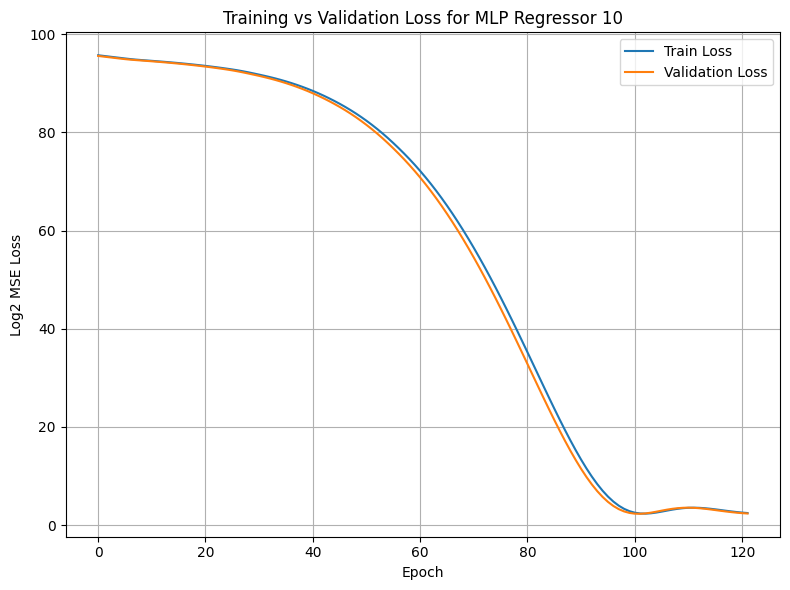


🔧 Training Regressor for class 11...
  Epoch 0 | Val log2-loss: 100.0735
  Epoch 100 | Val log2-loss: 45.8592
  Early stopping at epoch 149 with best val loss 1.0955
Test log2-loss: 1.2954


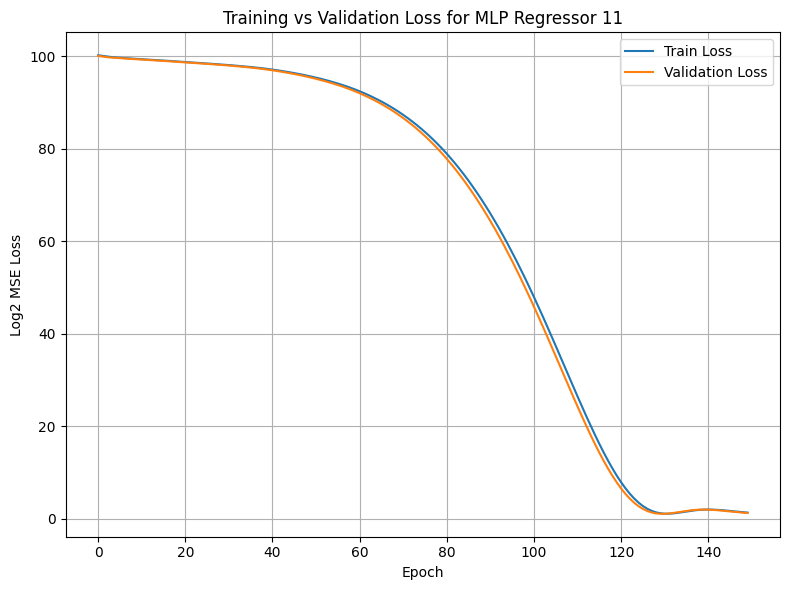


🔧 Training Regressor for class 12...
  Epoch 0 | Val log2-loss: 122.1173
  Epoch 100 | Val log2-loss: 102.0962
  Early stopping at epoch 197 with best val loss 0.8008
Test log2-loss: 0.8230


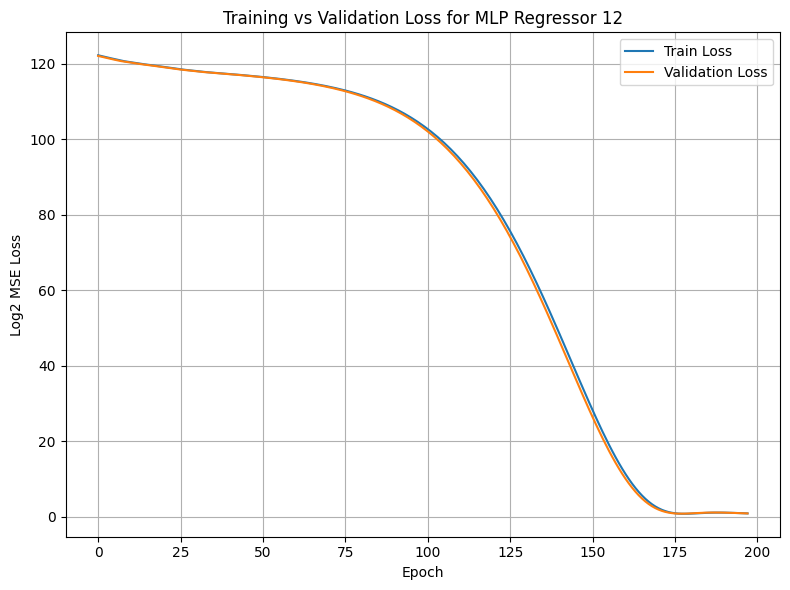


🔧 Training Regressor for class 13...
  Epoch 0 | Val log2-loss: 125.0886
  Epoch 100 | Val log2-loss: 122.1054
  Epoch 200 | Val log2-loss: 119.9190
  Epoch 300 | Val log2-loss: 117.7613
  Epoch 400 | Val log2-loss: 115.6319
  Epoch 500 | Val log2-loss: 113.5303
  Epoch 600 | Val log2-loss: 111.4561
  Epoch 700 | Val log2-loss: 109.4089
  Epoch 800 | Val log2-loss: 107.3881
  Epoch 900 | Val log2-loss: 105.3934
  Epoch 1000 | Val log2-loss: 103.4243
  Epoch 1100 | Val log2-loss: 101.4805
  Epoch 1200 | Val log2-loss: 99.5614
  Epoch 1300 | Val log2-loss: 97.6669
  Epoch 1400 | Val log2-loss: 95.7964
  Epoch 1500 | Val log2-loss: 93.9496
  Epoch 1600 | Val log2-loss: 92.1263
  Epoch 1700 | Val log2-loss: 90.3260
  Epoch 1800 | Val log2-loss: 88.5485
  Epoch 1900 | Val log2-loss: 86.7934
  Epoch 2000 | Val log2-loss: 85.0605
  Epoch 2100 | Val log2-loss: 83.3496
  Epoch 2200 | Val log2-loss: 81.6603
  Epoch 2300 | Val log2-loss: 79.9924
  Epoch 2400 | Val log2-loss: 78.3456
  Epoch 2500

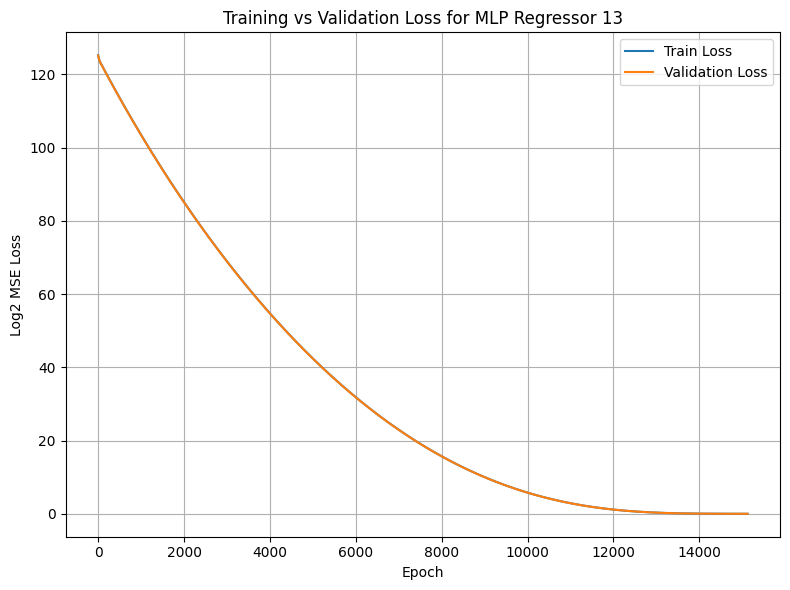


🔧 Training Regressor for class 14...
  Epoch 0 | Val log2-loss: 150.4838
  Epoch 100 | Val log2-loss: 41.4790
  Early stopping at epoch 140 with best val loss 2.8818
Test log2-loss: 3.1374


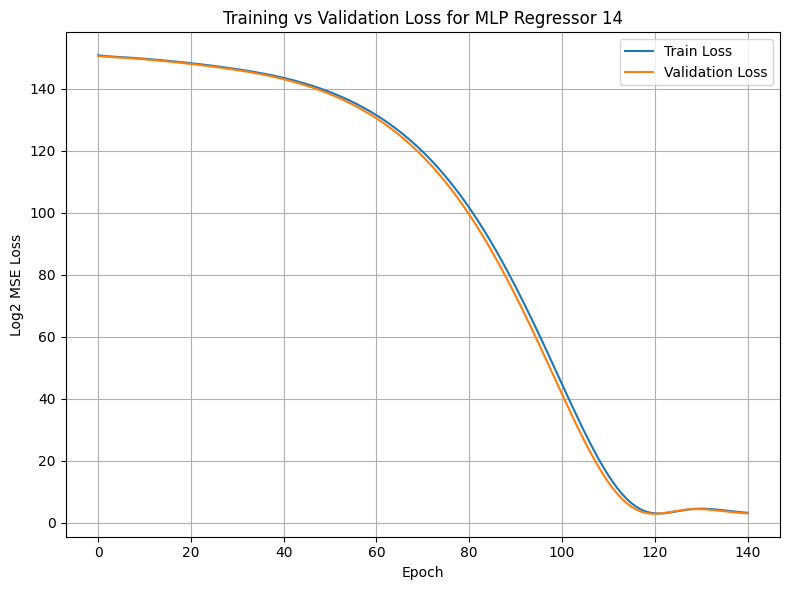


🔧 Training Regressor for class 15...
  Epoch 0 | Val log2-loss: 179.5786
  Epoch 100 | Val log2-loss: 3.3251
  Early stopping at epoch 111 with best val loss 1.8437
Test log2-loss: 2.1829


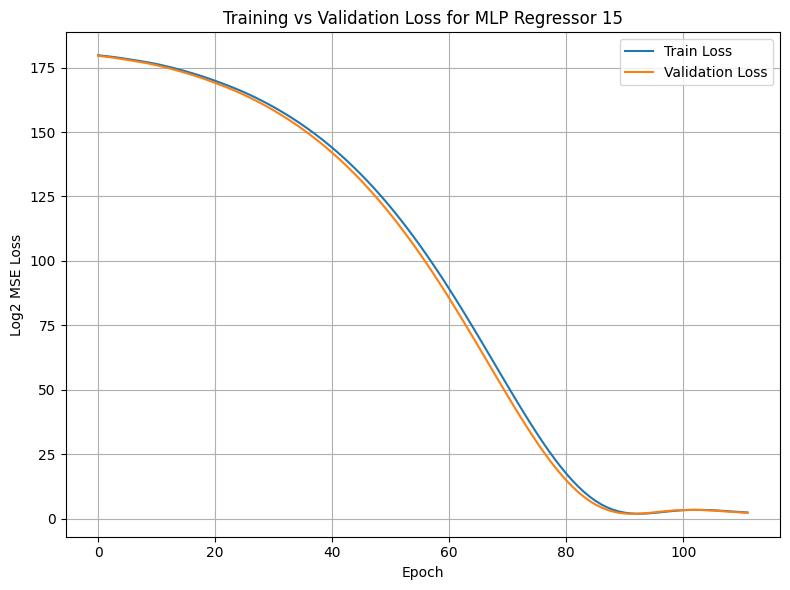


🔧 Training Regressor for class 16...
  Epoch 0 | Val log2-loss: 224.7520
  Epoch 100 | Val log2-loss: 221.7675
  Epoch 200 | Val log2-loss: 218.8122
  Epoch 300 | Val log2-loss: 215.8859
  Epoch 400 | Val log2-loss: 212.9883
  Epoch 500 | Val log2-loss: 210.1188
  Epoch 600 | Val log2-loss: 207.2769
  Epoch 700 | Val log2-loss: 204.4623
  Epoch 800 | Val log2-loss: 201.6745
  Epoch 900 | Val log2-loss: 198.9131
  Epoch 1000 | Val log2-loss: 196.1777
  Epoch 1100 | Val log2-loss: 193.4679
  Epoch 1200 | Val log2-loss: 190.7835
  Epoch 1300 | Val log2-loss: 188.1239
  Epoch 1400 | Val log2-loss: 185.4890
  Epoch 1500 | Val log2-loss: 182.8782
  Epoch 1600 | Val log2-loss: 180.2914
  Epoch 1700 | Val log2-loss: 177.7282
  Epoch 1800 | Val log2-loss: 175.1883
  Epoch 1900 | Val log2-loss: 172.6715
  Epoch 2000 | Val log2-loss: 170.1775
  Epoch 2100 | Val log2-loss: 167.7060
  Epoch 2200 | Val log2-loss: 165.2567
  Epoch 2300 | Val log2-loss: 162.8295
  Epoch 2400 | Val log2-loss: 160.4241

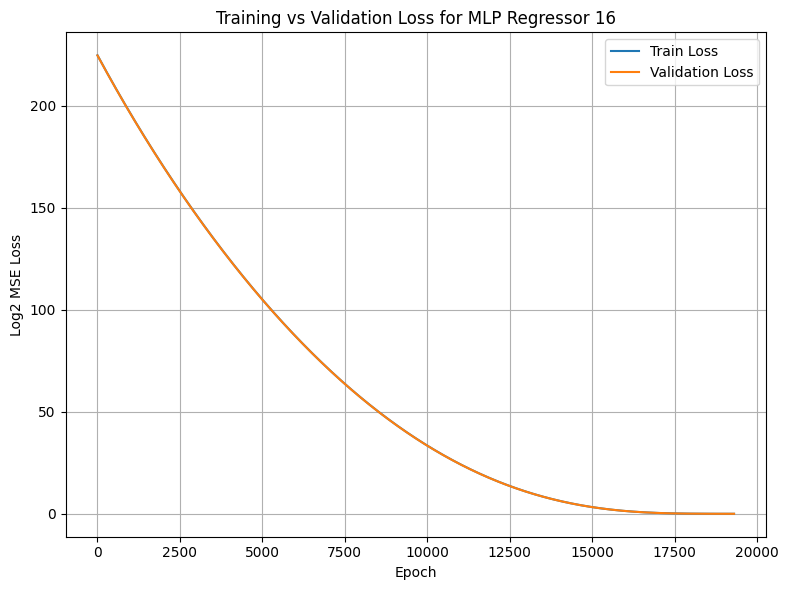


🔧 Training Regressor for class 17...
  Epoch 0 | Val log2-loss: 246.1775
  Epoch 100 | Val log2-loss: 0.5508
  Early stopping at epoch 118 with best val loss 0.3703
Test log2-loss: 0.3531


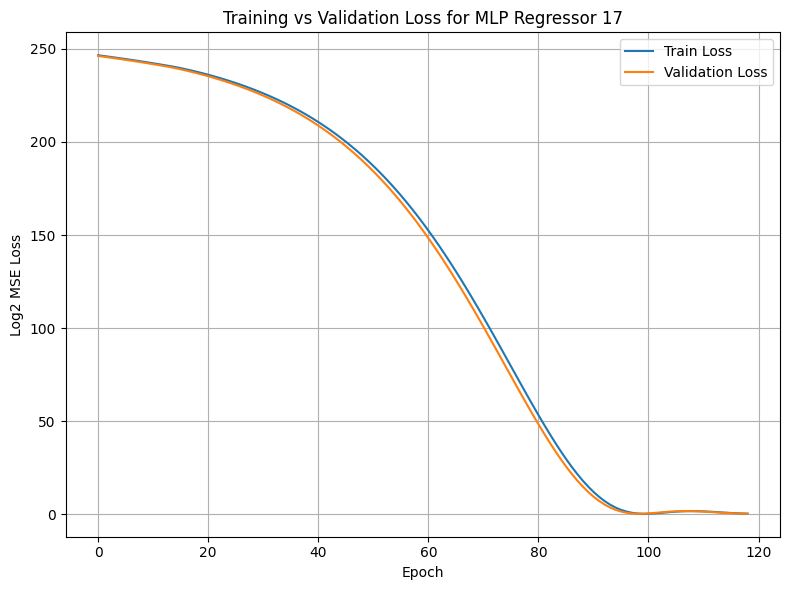


🔧 Training Regressor for class 18...
  Epoch 0 | Val log2-loss: 278.5580
  Epoch 100 | Val log2-loss: 47.0060
  Early stopping at epoch 137 with best val loss 0.3356
Test log2-loss: 0.6858


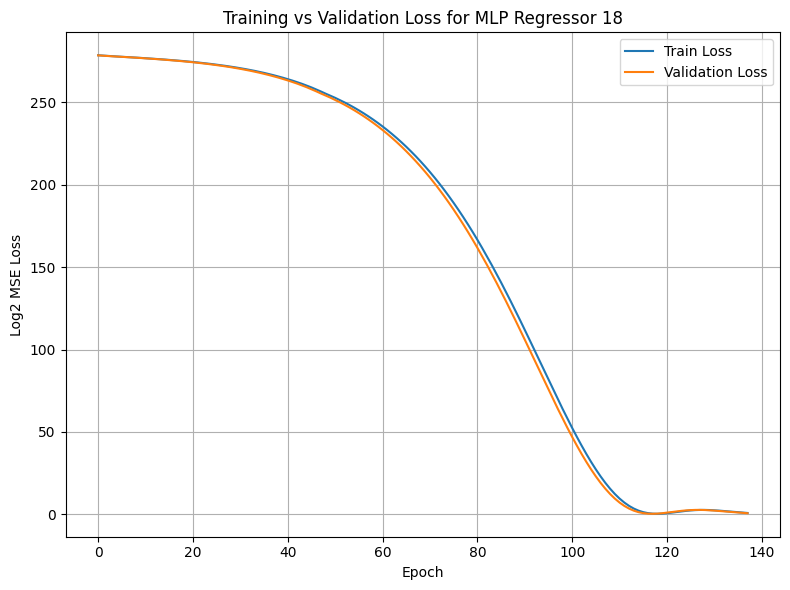


🔧 Training Regressor for class 19...
  Epoch 0 | Val log2-loss: 383.9840
  Epoch 100 | Val log2-loss: 277.5849
  Early stopping at epoch 169 with best val loss 2.4536
Test log2-loss: 3.0811


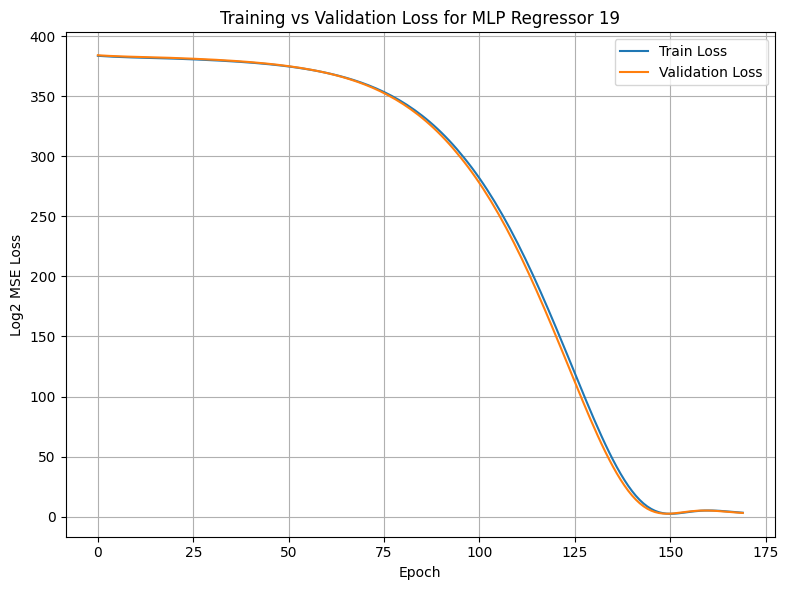

✅ Saved MLP regressors at 10_5_MLP_regressor_models


In [ ]:
import matplotlib.pyplot as plt
import torch
import os

regressors = {}

compressed_reps_tensor = torch.tensor(compressed_reps, dtype=torch.float32).to(device)
log_result_values = np.log2(np.clip(df_105['result'].values, 1e-6, None))
log_result_tensor = torch.tensor(log_result_values, dtype=torch.float32).view(-1, 1).to(device)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.model(x)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

for class_id in range(20):
    print(f"\n🔧 Training Regressor for class {class_id}...")
    class_mask = df_105['class'].values == class_id

    X_class = compressed_reps_tensor[class_mask]
    y_class = log_result_tensor[class_mask]

    if X_class.size(0) < 10:
        print(f"  Skipping class {class_id} (too few samples)")
        continue

    X_temp, X_test, y_temp, y_test = train_test_split(X_class, y_class, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

    reg_model = MLPRegressor().to(device)
    optimizer = optim.Adam(reg_model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    patience = 20
    epochs_no_improve = 0
    min_delta = 1e-4
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(25000):
        reg_model.train()
        y_pred = reg_model(X_train)
        loss = log2_mse_loss(y_pred,y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reg_model.eval()
        with torch.no_grad():
            val_pred = reg_model(X_val)
            val_loss = log2_mse_loss(val_pred, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 100 == 0:
            print(f"  Epoch {epoch} | Val log2-loss: {val_loss.item():.4f}")

        if val_loss.item() + min_delta < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = reg_model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
            break

    if best_model_state:
        reg_model.load_state_dict(best_model_state)
    regressors[class_id] = reg_model

    reg_model.eval()
    with torch.no_grad():
        test_pred = reg_model(X_test)
        test_loss = log2_mse_loss(test_pred, y_test)

    print(f"Test log2-loss: {test_loss.item():.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log2 MSE Loss")
    plt.title(f"Training vs Validation Loss for MLP Regressor {class_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

os.makedirs("10_5_MLP_regressor_models", exist_ok=True)

for class_id, model in regressors.items():
    model_path = f"10_5_MLP_regressor_models/10_5_MLP_regressor_{class_id}.pth"
    torch.save(model.state_dict(), model_path)

print(f"✅ Saved MLP regressors at 10_5_MLP_regressor_models")

# Final Model Testing

In [ ]:
df_105_test = grouped_dfs[(10, 5)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_105_test.apply(preprocess, axis=1))
y = df_105_test['result'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_full_scaled_test = scaler.transform(X_test)
X_full_tensor_test = torch.tensor(X_full_scaled_test, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps_test = trained_encoder(X_full_tensor_test).cpu().numpy()

compressed_reps_test_tensor = torch.tensor(compressed_reps_test, dtype=torch.float32).to(device)

clf_model.eval()
with torch.no_grad():
    test_outputs_clf = clf_model(compressed_reps_test_tensor)
    test_pred_clf = torch.argmax(test_outputs_clf, dim=1).cpu().numpy()

y_true_actual = y_test
y_pred_actual = []

for i in range(len(X_test)):
    class_id = int(test_pred_clf[i])

    if class_id not in regressors:
        y_pred_actual.append(0.0)
        continue

    regressor = regressors[class_id]
    regressor.eval()

    input_tensor = compressed_reps_test_tensor[i].unsqueeze(0)

    with torch.no_grad():
        log_pred = regressor(input_tensor)
        pred_value = torch.pow(2.0, log_pred).item()

    y_pred_actual.append(pred_value)

y_pred_actual = np.array(y_pred_actual)
y_true_actual = np.clip(y_true_actual, 1e-6, None)

def log2_mse_np(y_true, y_pred):
    y_true = np.clip(y_true, 1e-6, None)
    y_pred = np.clip(y_pred, 1e-6, None)
    return np.mean((np.log2(y_true) - np.log2(y_pred)) ** 2)

test_log2_loss = log2_mse_np(y_true_actual, y_pred_actual)
print(f"✅ Final Test Log2 Loss: {test_log2_loss:.4f}")

✅ Final Test Log2 Loss: 3.0617


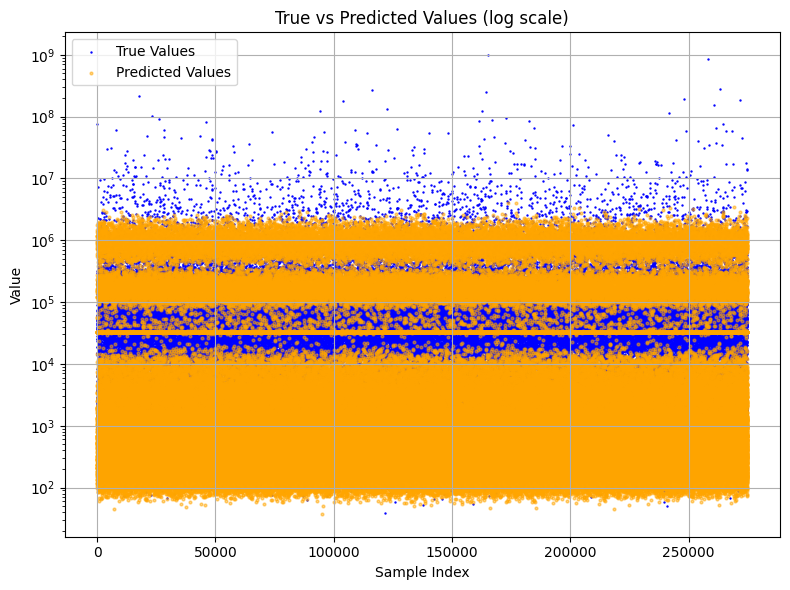

In [ ]:
import matplotlib.pyplot as plt

y_true = np.array(y_true_actual)
y_pred = np.array(y_pred_actual)

plt.figure(figsize=(8, 6))

plt.scatter(range(len(y_true)), y_true, label='True Values', color='blue', alpha=1, s=0.5)

plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.5, s=4)

plt.title('True vs Predicted Values (log scale)')
plt.yscale('log')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Training for (10,6)

# Encoder Decoder Model Training

Using device: cuda
Epoch 0 | Train Loss: 150.7931 | Val Loss: 150.6035
Epoch 100 | Train Loss: 3.3683 | Val Loss: 3.3320
Epoch 200 | Train Loss: 2.4615 | Val Loss: 2.4597
Epoch 300 | Train Loss: 2.3193 | Val Loss: 2.3189
Epoch 400 | Train Loss: 2.0779 | Val Loss: 2.0764
Epoch 500 | Train Loss: 1.8966 | Val Loss: 1.8969
Epoch 600 | Train Loss: 1.7767 | Val Loss: 1.7753
Epoch 700 | Train Loss: 1.6215 | Val Loss: 1.6166
Epoch 800 | Train Loss: 1.5481 | Val Loss: 1.5455
Epoch 900 | Train Loss: 1.5331 | Val Loss: 1.5302
Epoch 1000 | Train Loss: 1.5283 | Val Loss: 1.5251
Epoch 1100 | Train Loss: 1.5265 | Val Loss: 1.5232
Epoch 1200 | Train Loss: 1.5258 | Val Loss: 1.5224
Early stopping at epoch 1237 with best val loss 1.5223


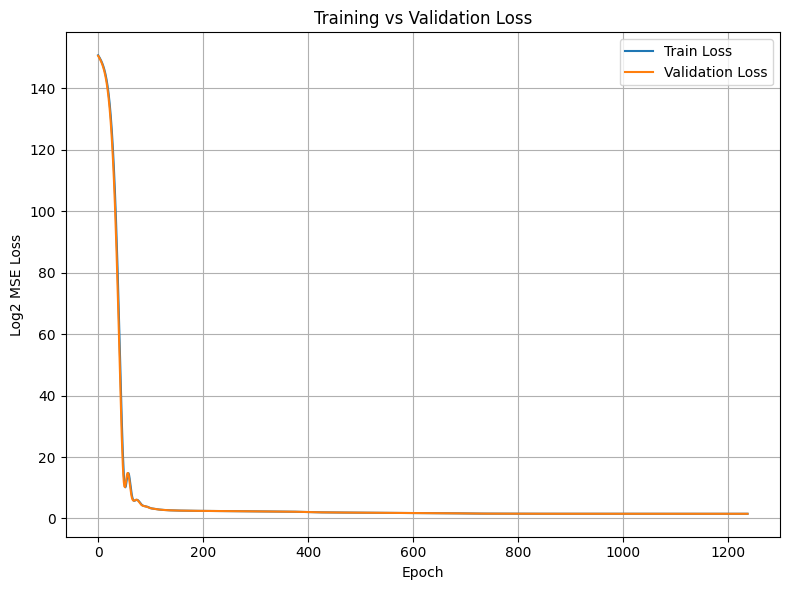

Test Loss: 1.5222
✅ Encoder-Decoder model saved as encoder_decoder_model.pth
✅ Scaler saved as scaler.pkl


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

df_106 = grouped_dfs[(10, 6)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_106.apply(preprocess, axis=1))
y = df_106['result'].values
y_log = np.log2(np.clip(y, 1e-6, None))

X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)


class EncoderDecoder(nn.Module):
    def __init__(self, input_dim=63, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

ed_model = EncoderDecoder().to(device)

optimizer = optim.Adam(ed_model.parameters(), lr=0.001)
num_epochs = 3000

patience = 20
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ed_model.train()
    y_pred = ed_model(X_train)
    loss = log2_mse_loss(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ed_model.eval()
    with torch.no_grad():
        val_pred = ed_model(X_val)
        val_loss = log2_mse_loss(val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    if val_loss.item() + min_delta < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = ed_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
        break

if best_model_state is not None:
    ed_model.load_state_dict(best_model_state)

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log2 MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ed_model.eval()
with torch.no_grad():
    test_pred = ed_model(X_test)
    test_loss = log2_mse_loss(test_pred, y_test)

print(f"Test Loss: {test_loss:.4f}")

torch.save(ed_model.state_dict(), f"10_6_encoder_decoder_model.pth")
print("✅ Encoder-Decoder model saved as encoder_decoder_model.pth")

joblib.dump(scaler, "10_6_scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

# MLP Classifier Model Training

Epoch 0 | Train Loss: 3.0461 | Val Acc: 0.0503
Epoch 10 | Train Loss: 2.9751 | Val Acc: 0.0506
Epoch 20 | Train Loss: 2.9384 | Val Acc: 0.0507
Epoch 30 | Train Loss: 2.9140 | Val Acc: 0.0509
Epoch 40 | Train Loss: 2.8900 | Val Acc: 0.0534
Epoch 50 | Train Loss: 2.8664 | Val Acc: 0.0583
Epoch 60 | Train Loss: 2.8417 | Val Acc: 0.0645
Epoch 70 | Train Loss: 2.8149 | Val Acc: 0.0714
Epoch 80 | Train Loss: 2.7862 | Val Acc: 0.0823
Epoch 90 | Train Loss: 2.7558 | Val Acc: 0.0916
Test Accuracy: 0.0977
✅ Classifier model saved as classifier_mlp_model.pth


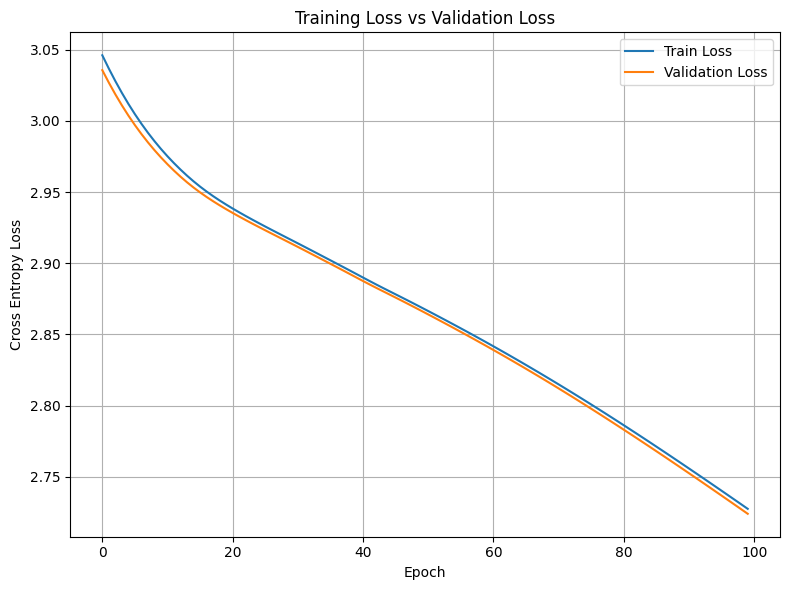

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

trained_encoder = ed_model.encoder

result_values = df_106['result'].values

df_106['class'] = pd.qcut(np.log2(result_values), q=20, labels=False, duplicates='drop')

X_full = np.vstack(df_106.apply(preprocess, axis=1))
X_full_scaled = scaler.transform(X_full)
X_full_tensor = torch.tensor(X_full_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps = trained_encoder(X_full_tensor).cpu().numpy()

class_labels = df_106['class'].values
label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(class_labels)

X_cls_temp, X_cls_test, y_cls_temp, y_cls_test = train_test_split(compressed_reps, y_classes, test_size=0.15, random_state=42)
X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(X_cls_temp, y_cls_temp, test_size=0.1765, random_state=42)

X_cls_train = torch.tensor(X_cls_train, dtype=torch.float32).to(device)
X_cls_val = torch.tensor(X_cls_val, dtype=torch.float32).to(device)
X_cls_test = torch.tensor(X_cls_test, dtype=torch.float32).to(device)

y_cls_train = torch.tensor(y_cls_train, dtype=torch.long).to(device)
y_cls_val = torch.tensor(y_cls_val, dtype=torch.long).to(device)
y_cls_test = torch.tensor(y_cls_test, dtype=torch.long).to(device)

class ClassifierMLP(nn.Module):
    def __init__(self, input_dim=16, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

clf_model = ClassifierMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=0.001)

patience = 20
best_val_acc = 0.0
epochs_no_improve = 0
min_delta = 1e-4
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(100):
    clf_model.train()
    outputs = clf_model(X_cls_train)
    loss = criterion(outputs, y_cls_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    clf_model.eval()
    with torch.no_grad():
        val_outputs = clf_model(X_cls_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_loss = criterion(val_outputs, y_cls_val)
        val_acc = accuracy_score(y_cls_val.cpu(), val_preds.cpu())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_model_state = clf_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} with best val acc {best_val_acc:.4f}")
        break

if best_model_state:
    clf_model.load_state_dict(best_model_state)

clf_model.eval()
with torch.no_grad():
    test_outputs = clf_model(X_cls_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = accuracy_score(y_cls_test.cpu(), test_preds.cpu())

print(f"Test Accuracy: {test_acc:.4f}")

torch.save(clf_model.state_dict(), "10_6_classifier_mlp_model.pth")
print("✅ Classifier model saved as classifier_mlp_model.pth")

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MLP Regressor Model Training


🔧 Training Regressor for class 0...
  Epoch 0 | Val log2-loss: 68.1843
  Epoch 100 | Val log2-loss: 66.5465
  Epoch 200 | Val log2-loss: 64.9379
  Epoch 300 | Val log2-loss: 63.3582
  Epoch 400 | Val log2-loss: 61.8066
  Epoch 500 | Val log2-loss: 60.2827
  Epoch 600 | Val log2-loss: 58.7859
  Epoch 700 | Val log2-loss: 57.3158
  Epoch 800 | Val log2-loss: 55.8717
  Epoch 900 | Val log2-loss: 54.4531
  Epoch 1000 | Val log2-loss: 53.0597
  Epoch 1100 | Val log2-loss: 51.6910
  Epoch 1200 | Val log2-loss: 50.3466
  Epoch 1300 | Val log2-loss: 49.0259
  Epoch 1400 | Val log2-loss: 47.7286
  Epoch 1500 | Val log2-loss: 46.4544
  Epoch 1600 | Val log2-loss: 45.2029
  Epoch 1700 | Val log2-loss: 43.9736
  Epoch 1800 | Val log2-loss: 42.7664
  Epoch 1900 | Val log2-loss: 41.5807
  Epoch 2000 | Val log2-loss: 40.4164
  Epoch 2100 | Val log2-loss: 39.2731
  Epoch 2200 | Val log2-loss: 38.1506
  Epoch 2300 | Val log2-loss: 37.0486
  Epoch 2400 | Val log2-loss: 35.9667
  Epoch 2500 | Val log2-l

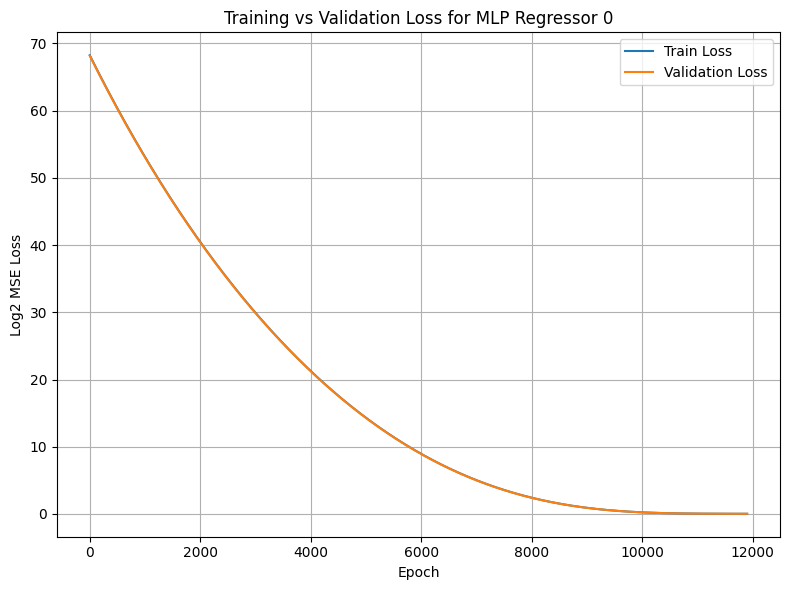


🔧 Training Regressor for class 1...
  Epoch 0 | Val log2-loss: 78.8328
  Epoch 100 | Val log2-loss: 70.0320
  Epoch 200 | Val log2-loss: 0.5938
  Early stopping at epoch 206 with best val loss 0.4000
Test log2-loss: 0.5083


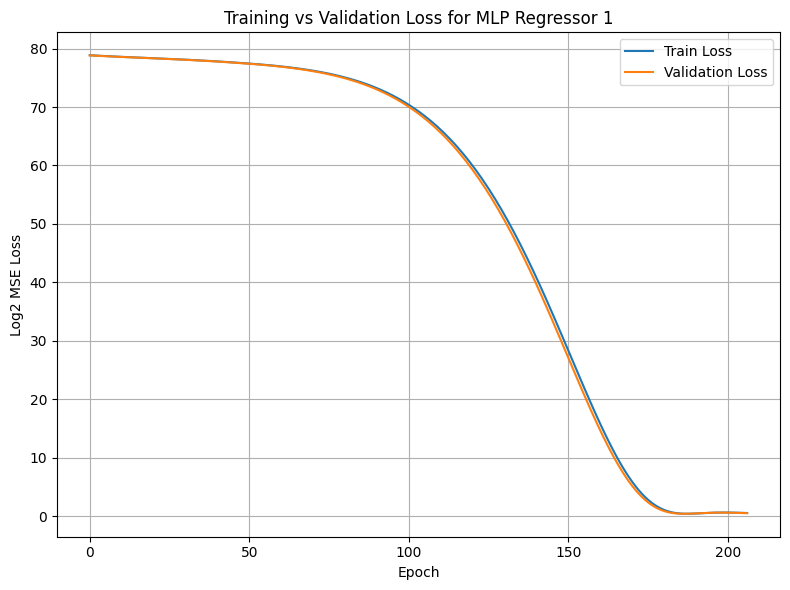


🔧 Training Regressor for class 2...
  Epoch 0 | Val log2-loss: 66.7702
  Epoch 100 | Val log2-loss: 64.8618
  Epoch 200 | Val log2-loss: 63.2740
  Epoch 300 | Val log2-loss: 61.7149
  Epoch 400 | Val log2-loss: 60.1839
  Epoch 500 | Val log2-loss: 58.6806
  Epoch 600 | Val log2-loss: 57.2043
  Epoch 700 | Val log2-loss: 55.7546
  Epoch 800 | Val log2-loss: 54.3310
  Epoch 900 | Val log2-loss: 52.9329
  Epoch 1000 | Val log2-loss: 51.5600
  Epoch 1100 | Val log2-loss: 50.2116
  Epoch 1200 | Val log2-loss: 48.8875
  Epoch 1300 | Val log2-loss: 47.5871
  Epoch 1400 | Val log2-loss: 46.3101
  Epoch 1500 | Val log2-loss: 45.0562
  Epoch 1600 | Val log2-loss: 43.8248
  Epoch 1700 | Val log2-loss: 42.6157
  Epoch 1800 | Val log2-loss: 41.4286
  Epoch 1900 | Val log2-loss: 40.2630
  Epoch 2000 | Val log2-loss: 39.1188
  Epoch 2100 | Val log2-loss: 37.9955
  Epoch 2200 | Val log2-loss: 36.8929
  Epoch 2300 | Val log2-loss: 35.8108
  Epoch 2400 | Val log2-loss: 34.7488
  Epoch 2500 | Val log2-l

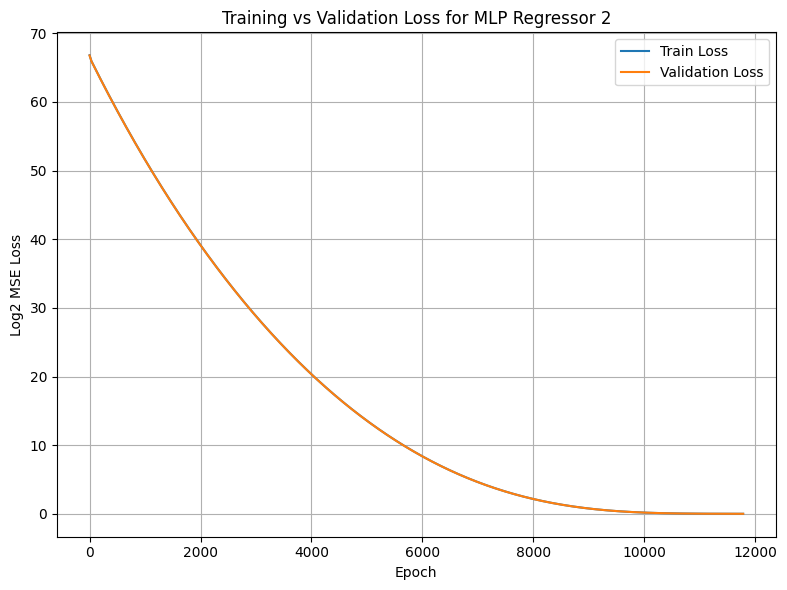


🔧 Training Regressor for class 3...
  Epoch 0 | Val log2-loss: 76.5172
  Epoch 100 | Val log2-loss: 14.2368
  Early stopping at epoch 140 with best val loss 0.4519
Test log2-loss: 0.5636


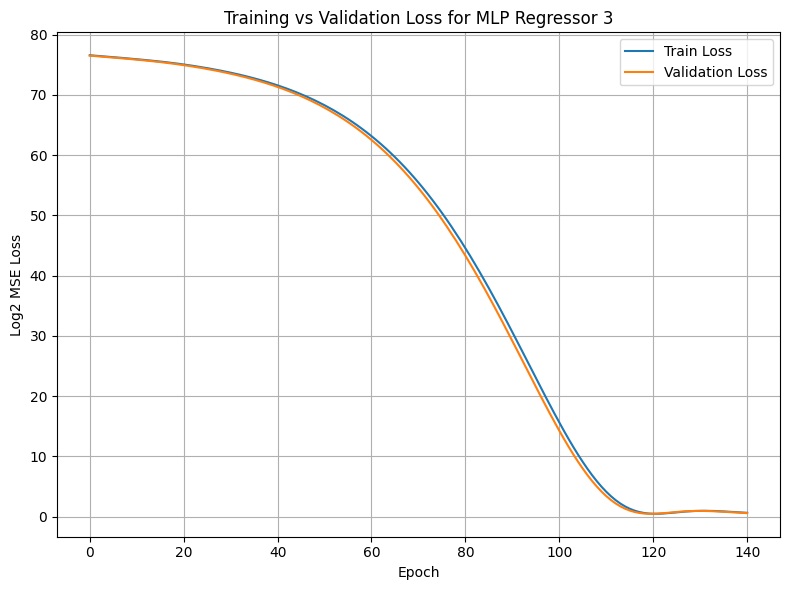


🔧 Training Regressor for class 4...
  Epoch 0 | Val log2-loss: 73.9430
  Epoch 100 | Val log2-loss: 29.4619
  Early stopping at epoch 145 with best val loss 0.5217
Test log2-loss: 0.6217


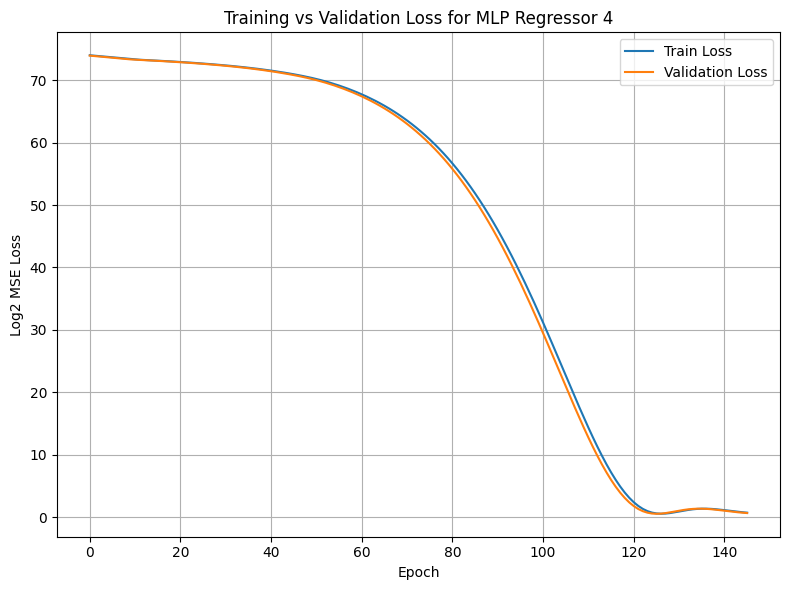


🔧 Training Regressor for class 5...
  Epoch 0 | Val log2-loss: 85.7727
  Epoch 100 | Val log2-loss: 82.4937
  Epoch 200 | Val log2-loss: 80.7021
  Epoch 300 | Val log2-loss: 78.9383
  Epoch 400 | Val log2-loss: 77.2025
  Epoch 500 | Val log2-loss: 75.4942
  Epoch 600 | Val log2-loss: 73.8130
  Epoch 700 | Val log2-loss: 72.1584
  Epoch 800 | Val log2-loss: 70.5300
  Epoch 900 | Val log2-loss: 68.9274
  Epoch 1000 | Val log2-loss: 67.3500
  Epoch 1100 | Val log2-loss: 65.7975
  Epoch 1200 | Val log2-loss: 64.2694
  Epoch 1300 | Val log2-loss: 62.7654
  Epoch 1400 | Val log2-loss: 61.2850
  Epoch 1500 | Val log2-loss: 59.8280
  Epoch 1600 | Val log2-loss: 58.3939
  Epoch 1700 | Val log2-loss: 56.9824
  Epoch 1800 | Val log2-loss: 55.5931
  Epoch 1900 | Val log2-loss: 54.2259
  Epoch 2000 | Val log2-loss: 52.8803
  Epoch 2100 | Val log2-loss: 51.5560
  Epoch 2200 | Val log2-loss: 50.2529
  Epoch 2300 | Val log2-loss: 48.9706
  Epoch 2400 | Val log2-loss: 47.7089
  Epoch 2500 | Val log2-l

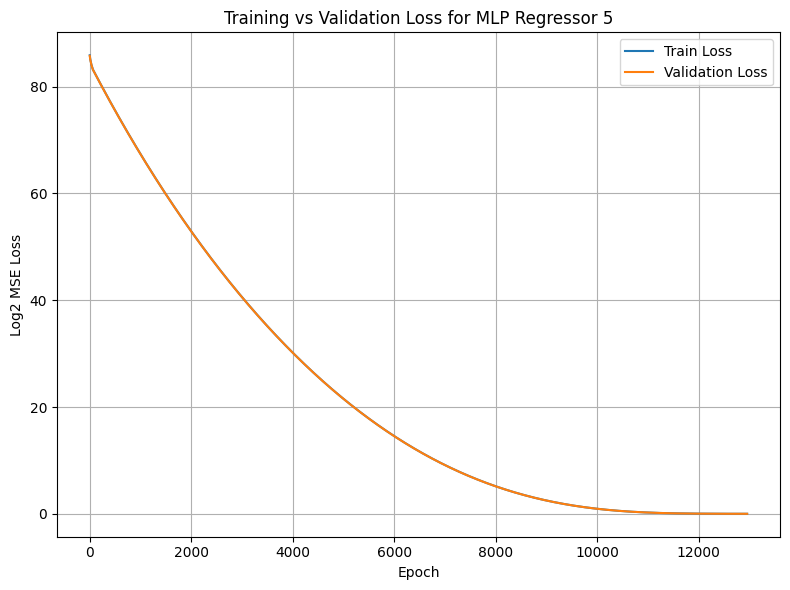


🔧 Training Regressor for class 6...
  Epoch 0 | Val log2-loss: 97.8901
  Epoch 100 | Val log2-loss: 19.5109
  Early stopping at epoch 134 with best val loss 3.1953
Test log2-loss: 3.2283


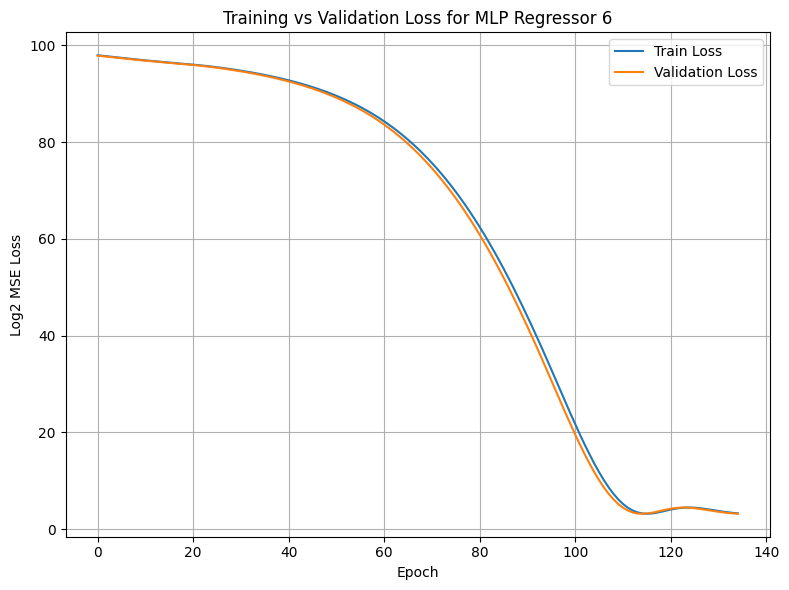


🔧 Training Regressor for class 7...
  Epoch 0 | Val log2-loss: 93.2928
  Epoch 100 | Val log2-loss: 2.1667
  Epoch 200 | Val log2-loss: 1.5257
  Epoch 300 | Val log2-loss: 1.3301
  Epoch 400 | Val log2-loss: 1.0835
  Epoch 500 | Val log2-loss: 0.8223
  Epoch 600 | Val log2-loss: 0.5095
  Epoch 700 | Val log2-loss: 0.1639
  Epoch 800 | Val log2-loss: 0.0559
  Epoch 900 | Val log2-loss: 0.0382
  Epoch 1000 | Val log2-loss: 0.0341
  Epoch 1100 | Val log2-loss: 0.0314
  Epoch 1200 | Val log2-loss: 0.0296
  Epoch 1300 | Val log2-loss: 0.0282
  Epoch 1400 | Val log2-loss: 0.0271
  Epoch 1500 | Val log2-loss: 0.0260
  Epoch 1600 | Val log2-loss: 0.0250
  Epoch 1700 | Val log2-loss: 0.0239
  Epoch 1800 | Val log2-loss: 0.0229
  Epoch 1900 | Val log2-loss: 0.0219
  Epoch 2000 | Val log2-loss: 0.0209
  Epoch 2100 | Val log2-loss: 0.0198
  Epoch 2200 | Val log2-loss: 0.0187
  Epoch 2300 | Val log2-loss: 0.0176
  Epoch 2400 | Val log2-loss: 0.0166
  Epoch 2500 | Val log2-loss: 0.0155
  Epoch 2600

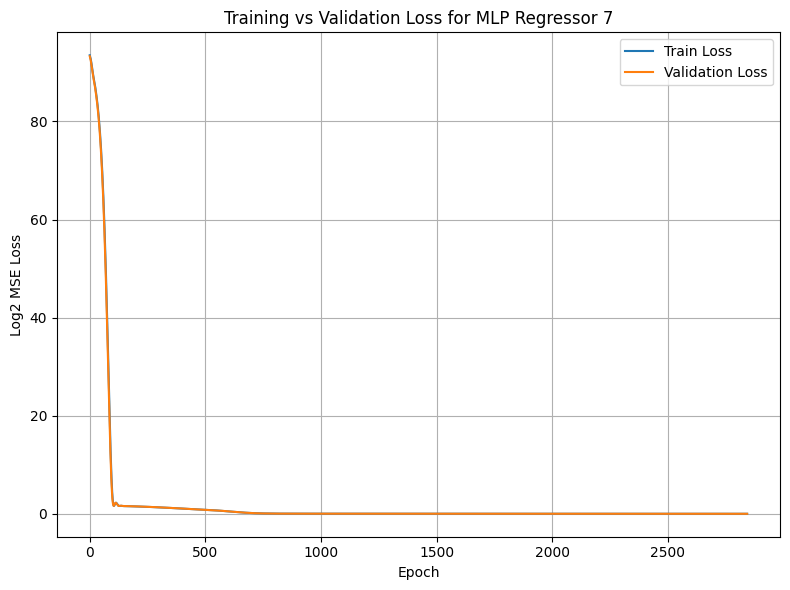


🔧 Training Regressor for class 8...
  Epoch 0 | Val log2-loss: 97.4469
  Epoch 100 | Val log2-loss: 46.3612
  Early stopping at epoch 149 with best val loss 0.9624
Test log2-loss: 1.0495


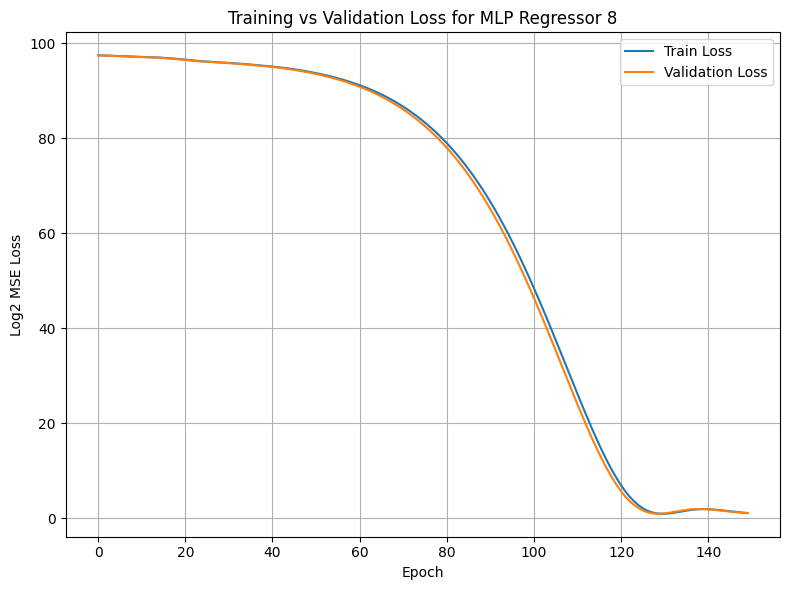


🔧 Training Regressor for class 9...
  Epoch 0 | Val log2-loss: 120.8670
  Epoch 100 | Val log2-loss: 117.6601
  Epoch 200 | Val log2-loss: 115.5146
  Epoch 300 | Val log2-loss: 113.3976
  Epoch 400 | Val log2-loss: 111.3087
  Epoch 500 | Val log2-loss: 109.2476
  Epoch 600 | Val log2-loss: 107.2139
  Epoch 700 | Val log2-loss: 105.2070
  Epoch 800 | Val log2-loss: 103.2266
  Epoch 900 | Val log2-loss: 101.2723
  Epoch 1000 | Val log2-loss: 99.3435
  Epoch 1100 | Val log2-loss: 97.4399
  Epoch 1200 | Val log2-loss: 95.5611
  Epoch 1300 | Val log2-loss: 93.7067
  Epoch 1400 | Val log2-loss: 91.8763
  Epoch 1500 | Val log2-loss: 90.0697
  Epoch 1600 | Val log2-loss: 88.2864
  Epoch 1700 | Val log2-loss: 86.5261
  Epoch 1800 | Val log2-loss: 84.7886
  Epoch 1900 | Val log2-loss: 83.0735
  Epoch 2000 | Val log2-loss: 81.3805
  Epoch 2100 | Val log2-loss: 79.7094
  Epoch 2200 | Val log2-loss: 78.0599
  Epoch 2300 | Val log2-loss: 76.4317
  Epoch 2400 | Val log2-loss: 74.8247
  Epoch 2500 | 

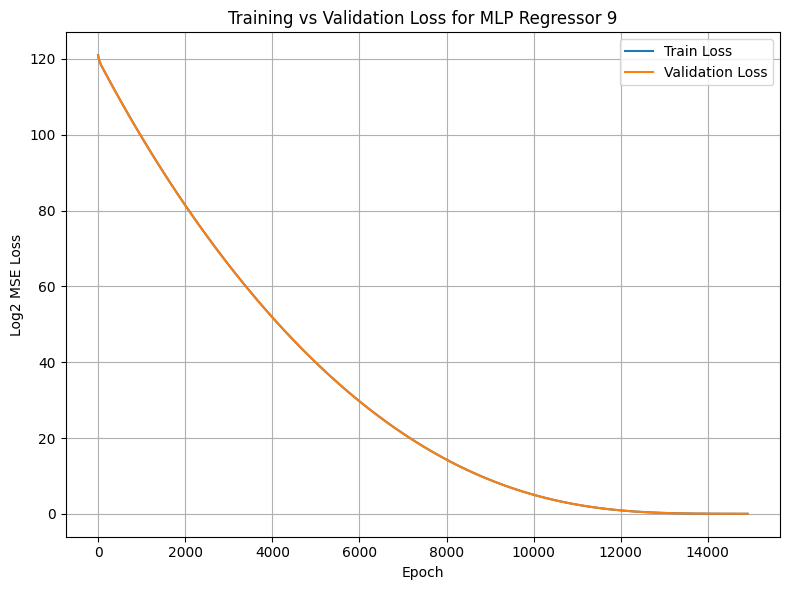


🔧 Training Regressor for class 10...
  Epoch 0 | Val log2-loss: 110.9643
  Epoch 100 | Val log2-loss: 88.3901
  Early stopping at epoch 189 with best val loss 0.4998
Test log2-loss: 0.6977


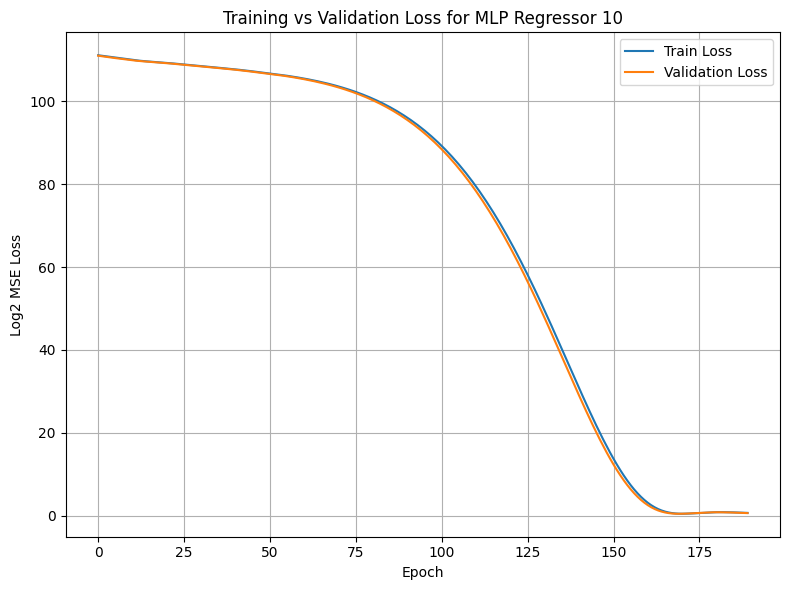


🔧 Training Regressor for class 11...
  Epoch 0 | Val log2-loss: 134.1927
  Epoch 100 | Val log2-loss: 16.7439
  Early stopping at epoch 133 with best val loss 0.5334
Test log2-loss: 0.6847


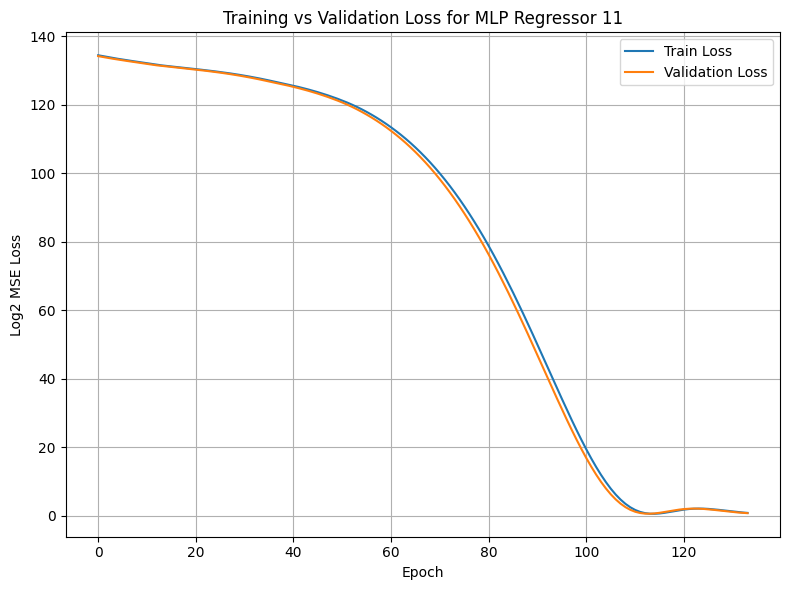


🔧 Training Regressor for class 12...
  Epoch 0 | Val log2-loss: 152.9442
  Epoch 100 | Val log2-loss: 26.0059
  Early stopping at epoch 138 with best val loss 1.0365
Test log2-loss: 1.2609


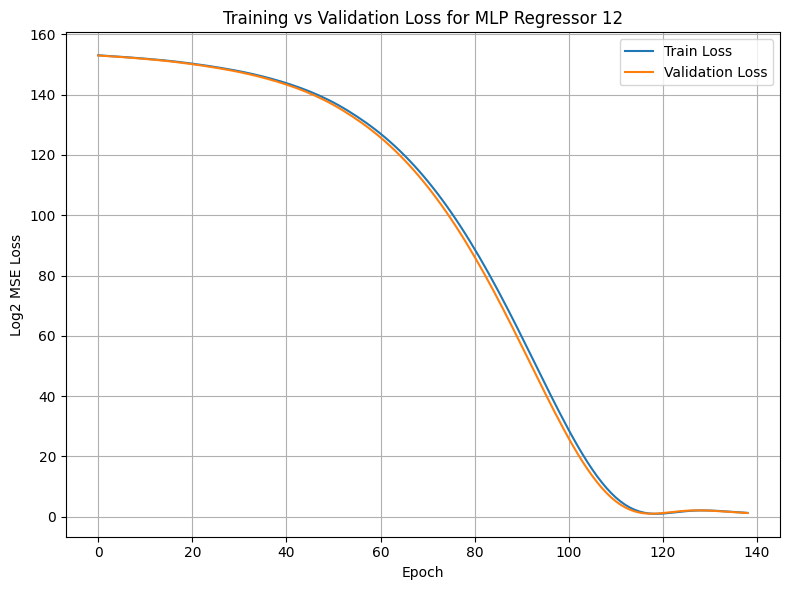


🔧 Training Regressor for class 13...
  Epoch 0 | Val log2-loss: 170.9288
  Epoch 100 | Val log2-loss: 7.3311
  Epoch 200 | Val log2-loss: 4.6134
  Epoch 300 | Val log2-loss: 4.3548
  Epoch 400 | Val log2-loss: 3.9911
  Epoch 500 | Val log2-loss: 3.4878
  Epoch 600 | Val log2-loss: 2.8207
  Epoch 700 | Val log2-loss: 1.9821
  Epoch 800 | Val log2-loss: 1.0234
  Epoch 900 | Val log2-loss: 0.2782
  Epoch 1000 | Val log2-loss: 0.1993
  Epoch 1100 | Val log2-loss: 0.1859
  Epoch 1200 | Val log2-loss: 0.1773
  Epoch 1300 | Val log2-loss: 0.1790
  Epoch 1400 | Val log2-loss: 0.1623
  Epoch 1500 | Val log2-loss: 0.1570
  Early stopping at epoch 1556 with best val loss 0.1554
Test log2-loss: 0.1517


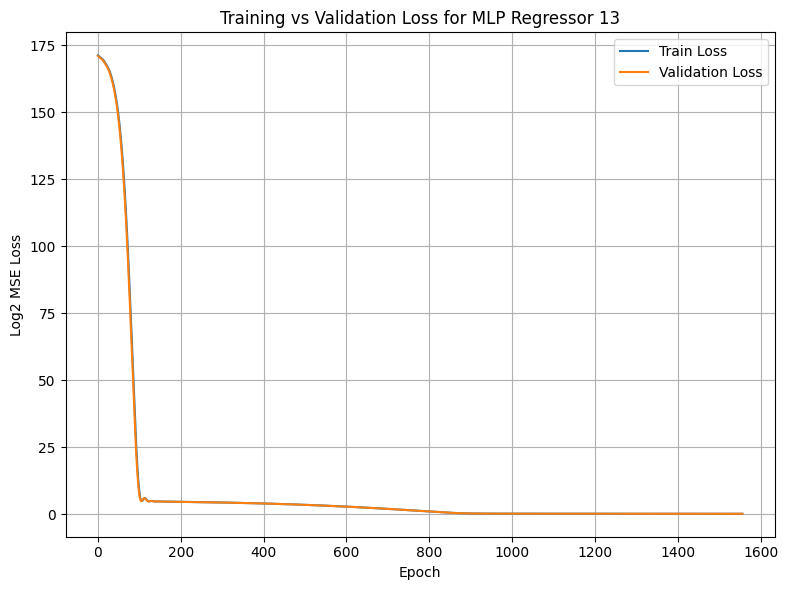


🔧 Training Regressor for class 14...
  Epoch 0 | Val log2-loss: 201.4438
  Epoch 100 | Val log2-loss: 63.6140
  Early stopping at epoch 143 with best val loss 0.8818
Test log2-loss: 1.3429


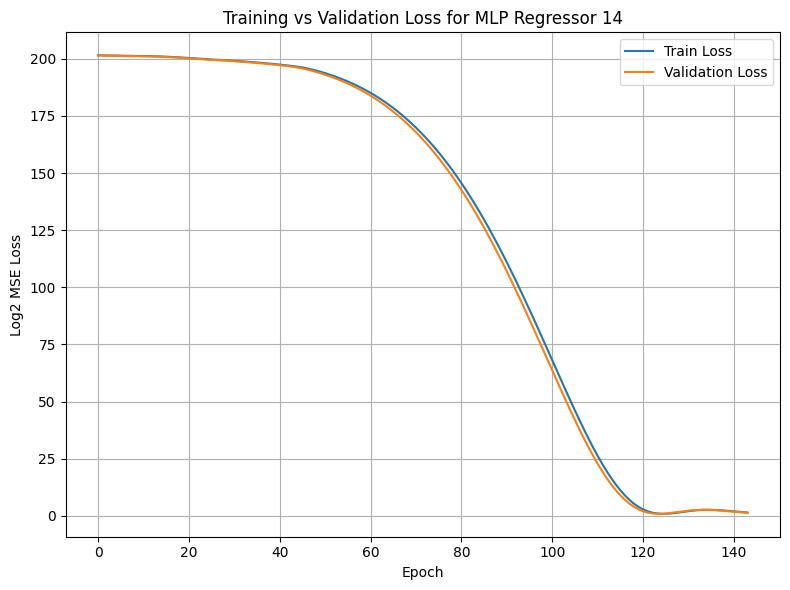


🔧 Training Regressor for class 15...
  Epoch 0 | Val log2-loss: 228.2680
  Early stopping at epoch 93 with best val loss 0.5321
Test log2-loss: 0.7320


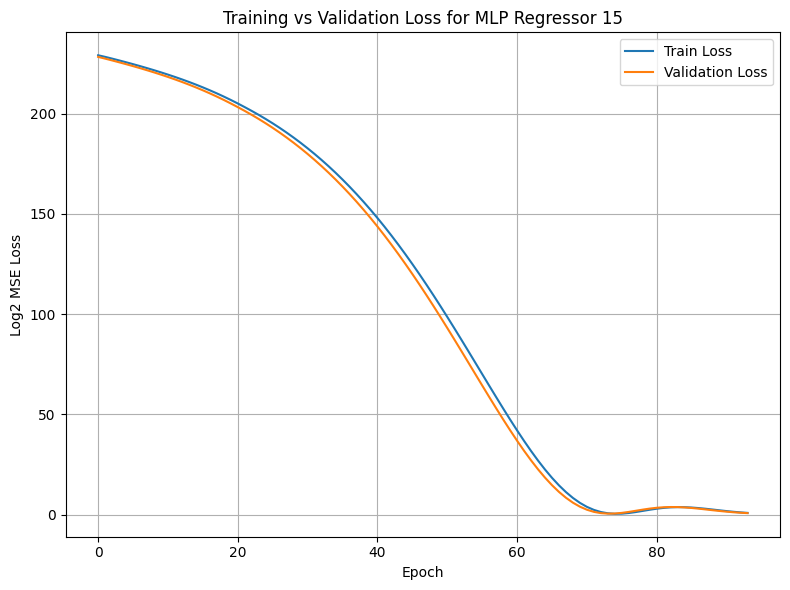


🔧 Training Regressor for class 16...
  Epoch 0 | Val log2-loss: 239.0686
  Epoch 100 | Val log2-loss: 17.9668
  Early stopping at epoch 129 with best val loss 0.3772
Test log2-loss: 0.7261


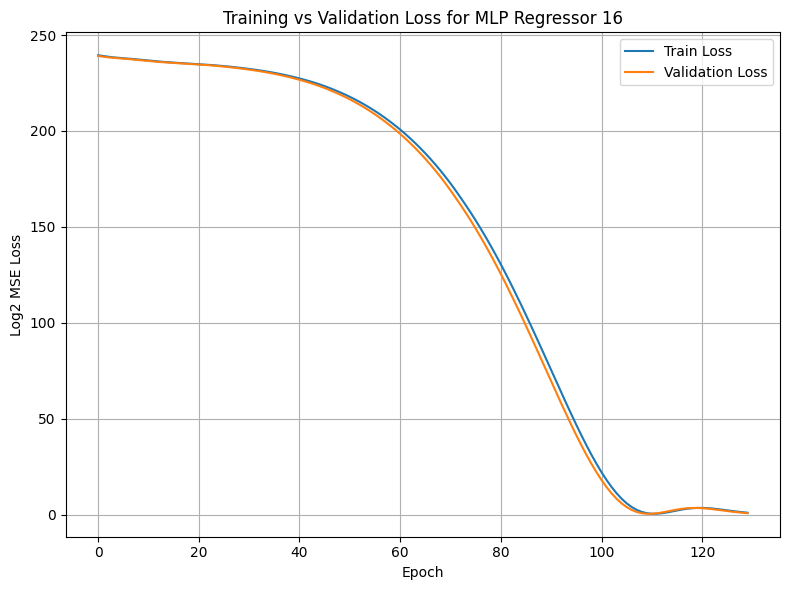


🔧 Training Regressor for class 17...
  Epoch 0 | Val log2-loss: 274.9698
  Epoch 100 | Val log2-loss: 0.9978
  Early stopping at epoch 123 with best val loss 0.3713
Test log2-loss: 0.8131


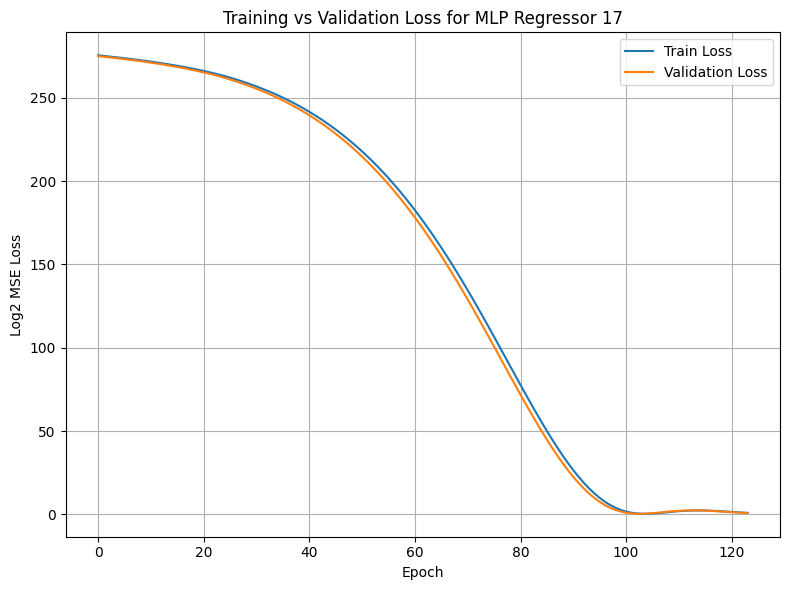


🔧 Training Regressor for class 18...
  Epoch 0 | Val log2-loss: 294.4447
  Epoch 100 | Val log2-loss: 108.0180
  Early stopping at epoch 150 with best val loss 0.3839
Test log2-loss: 0.7563


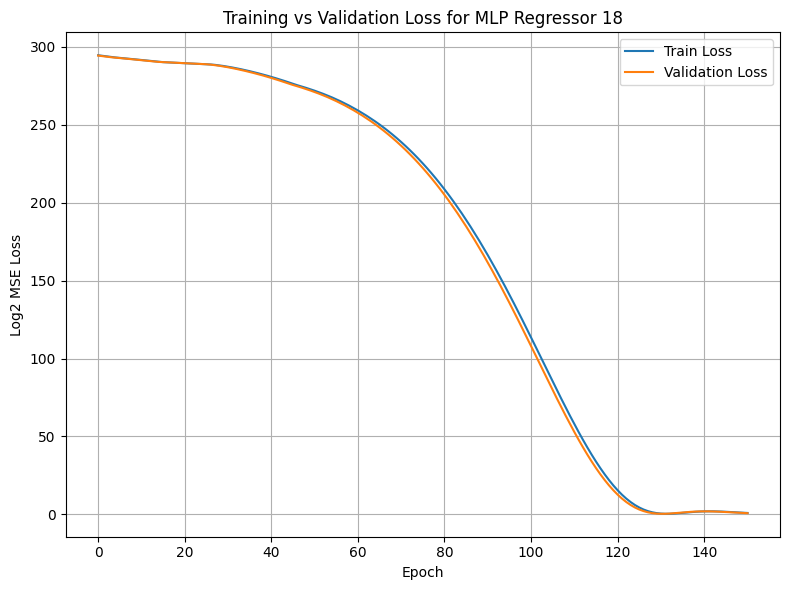


🔧 Training Regressor for class 19...
  Epoch 0 | Val log2-loss: 360.4632
  Epoch 100 | Val log2-loss: 28.1987
  Early stopping at epoch 131 with best val loss 2.4608
Test log2-loss: 3.0102


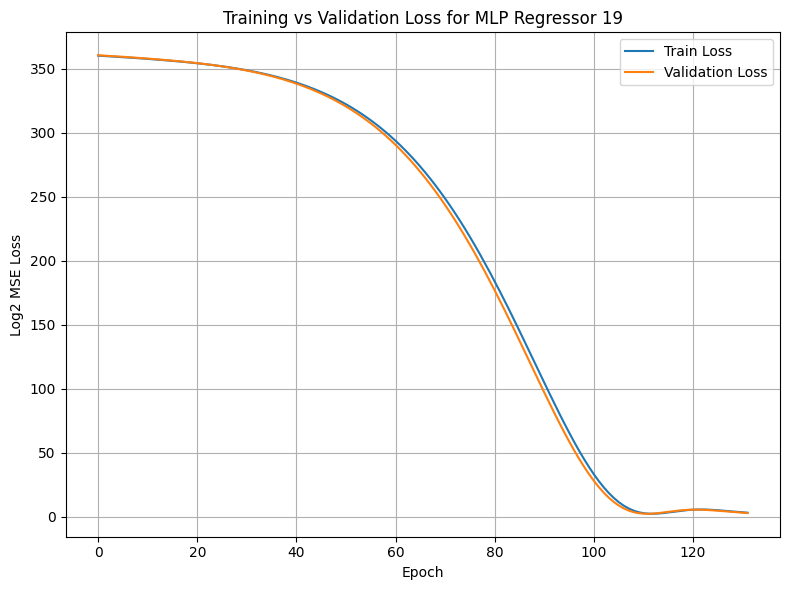

✅ Saved MLP regressors at 10_6_MLP_regressor_models


In [ ]:
import matplotlib.pyplot as plt
import torch
import os

regressors = {}

compressed_reps_tensor = torch.tensor(compressed_reps, dtype=torch.float32).to(device)
log_result_values = np.log2(np.clip(df_106['result'].values, 1e-6, None))
log_result_tensor = torch.tensor(log_result_values, dtype=torch.float32).view(-1, 1).to(device)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.model(x)

def log2_mse_loss(y_pred_log, y_true_log):
    y_pred = torch.pow(2.0, y_pred_log)
    y_true = torch.pow(2.0, y_true_log)
    return torch.mean((torch.log2(y_true) - torch.log2(y_pred)) ** 2)

for class_id in range(20):
    print(f"\n🔧 Training Regressor for class {class_id}...")
    class_mask = df_106['class'].values == class_id

    X_class = compressed_reps_tensor[class_mask]
    y_class = log_result_tensor[class_mask]

    if X_class.size(0) < 10:
        print(f"  Skipping class {class_id} (too few samples)")
        continue

    X_temp, X_test, y_temp, y_test = train_test_split(X_class, y_class, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

    reg_model = MLPRegressor().to(device)
    optimizer = optim.Adam(reg_model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    patience = 20
    epochs_no_improve = 0
    min_delta = 1e-4
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(30000):
        reg_model.train()
        y_pred = reg_model(X_train)
        loss = log2_mse_loss(y_pred,y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reg_model.eval()
        with torch.no_grad():
            val_pred = reg_model(X_val)
            val_loss = log2_mse_loss(val_pred, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 100 == 0:
            print(f"  Epoch {epoch} | Val log2-loss: {val_loss.item():.4f}")

        if val_loss.item() + min_delta < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = reg_model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch} with best val loss {best_val_loss:.4f}")
            break

    if best_model_state:
        reg_model.load_state_dict(best_model_state)
    regressors[class_id] = reg_model

    reg_model.eval()
    with torch.no_grad():
        test_pred = reg_model(X_test)
        test_loss = log2_mse_loss(test_pred, y_test)

    print(f"Test log2-loss: {test_loss.item():.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log2 MSE Loss")
    plt.title(f"Training vs Validation Loss for MLP Regressor {class_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

os.makedirs("10_6_MLP_regressor_models", exist_ok=True)

for class_id, model in regressors.items():
    model_path = f"10_6_MLP_regressor_models/10_6_MLP_regressor_{class_id}.pth"
    torch.save(model.state_dict(), model_path)

print(f"✅ Saved MLP regressors at 10_6_MLP_regressor_models")

# Final Model Testing

In [ ]:
df_106_test = grouped_dfs[(10, 6)].copy()

def preprocess(row):
    n_val, k_val, m_val = row['n'], row['k'], row['m']
    P_flat = row['P'].flatten()
    return np.concatenate([[n_val, k_val, m_val], P_flat])

X = np.vstack(df_106_test.apply(preprocess, axis=1))
y = df_106_test['result'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_full_scaled_test = scaler.transform(X_test)
X_full_tensor_test = torch.tensor(X_full_scaled_test, dtype=torch.float32).to(device)

with torch.no_grad():
    compressed_reps_test = trained_encoder(X_full_tensor_test).cpu().numpy()

compressed_reps_test_tensor = torch.tensor(compressed_reps_test, dtype=torch.float32).to(device)

clf_model.eval()
with torch.no_grad():
    test_outputs_clf = clf_model(compressed_reps_test_tensor)
    test_pred_clf = torch.argmax(test_outputs_clf, dim=1).cpu().numpy()

y_true_actual = y_test
y_pred_actual = []

for i in range(len(X_test)):
    class_id = int(test_pred_clf[i])

    if class_id not in regressors:
        y_pred_actual.append(0.0)
        continue

    regressor = regressors[class_id]
    regressor.eval()

    input_tensor = compressed_reps_test_tensor[i].unsqueeze(0)

    with torch.no_grad():
        log_pred = regressor(input_tensor)
        pred_value = torch.pow(2.0, log_pred).item()

    y_pred_actual.append(pred_value)

y_pred_actual = np.array(y_pred_actual)
y_true_actual = np.clip(y_true_actual, 1e-6, None)

def log2_mse_np(y_true, y_pred):
    y_true = np.clip(y_true, 1e-6, None)
    y_pred = np.clip(y_pred, 1e-6, None)
    return np.mean((np.log2(y_true) - np.log2(y_pred)) ** 2)

test_log2_loss = log2_mse_np(y_true_actual, y_pred_actual)
print(f"✅ Final Test Log2 Loss: {test_log2_loss:.4f}")

✅ Final Test Log2 Loss: 3.6000


/tmp/ipykernel_32/3591627150.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


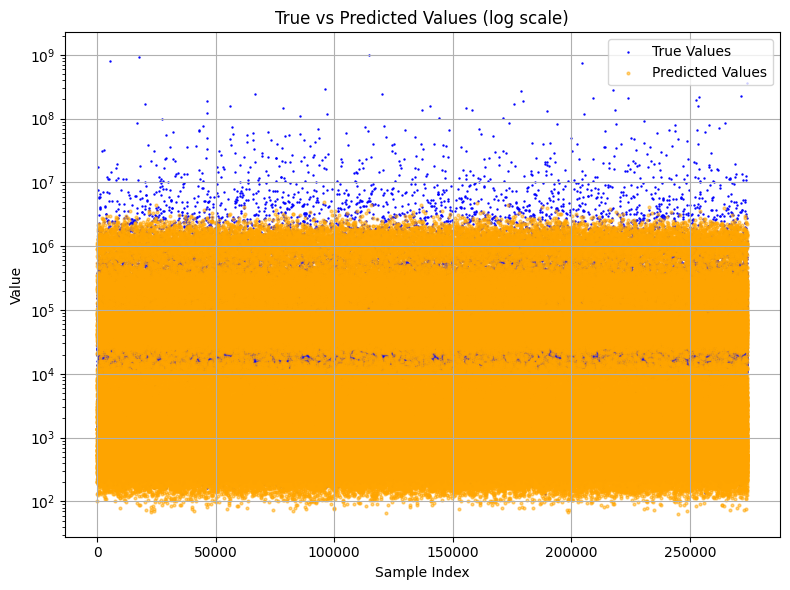

In [ ]:
import matplotlib.pyplot as plt

y_true = np.array(y_true_actual)
y_pred = np.array(y_pred_actual)

plt.figure(figsize=(8, 6))

plt.scatter(range(len(y_true)), y_true, label='True Values', color='blue', alpha=1, s=0.5)

plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.5, s=4)

plt.title('True vs Predicted Values (log scale)')
plt.yscale('log')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Readme

In [ ]:
# 📚 Model Architecture Overview

# We build a three-stage system for each (n, k) setup:

# 1. Encoder-Decoder:
# - Purpose: Compress the full input vector [n, k, m, P_augmented] into a lower-dimensional latent representation.
# - Encoder: Fully connected layers with ReLU activations, ending in a latent space.
# - Decoder: Expands from latent space back to an output vector during training (not used in final inference).
# - After training, we retain only the encoder for feature extraction.

# 2. Classifier (MLP Classifier):
# - Purpose: Classify the latent compressed representation into one of 20 quantile-based classes.
# - Structure:
#   - 1 hidden layer
#   - ReLU activation
#   - Output layer with 20 neurons (for 20 class labels).
# - The classifier decides which regressor should be used for final prediction.

# 3. Regressors (One MLP Regressor per Class):
# - Purpose: Predict the final continuous result value based on the compressed representation.
# - Structure:
#   - Separate MLP regressor for each class.
#   - 1 or more hidden layers (varying depth depending on (n,k)).
#   - Output is a single neuron predicting log2(result).
# - After prediction, we invert the log2 to obtain the actual result (result = 2^(predicted log2)).

# 🛠 Full Inference Pipeline:
# - Input sample -> Add (n, k, m) -> Flatten -> Scale.
# - Pass through the trained Encoder to get compressed representation.
# - Use Classifier to predict the class.
# - Pass compressed representation through the corresponding class-specific Regressor.
# - Invert the log2 transformation to recover the final predicted result.

# 🚀 This modular design ensures better specialization for different regions of the target space, leading to more accurate and robust predictions.


# Testing

In [ ]:
import os
import zipfile
import torch
import torch.nn as nn
import joblib
from sklearn.preprocessing import StandardScaler
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EncoderDecoder Class
class EncoderDecoder(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_hidden_units, decoder_hidden_units, decoder_output_dim):
        super().__init__()

        # Build encoder
        encoder_layers = []
        last_dim = input_dim
        for hidden_dim in encoder_hidden_units:
            encoder_layers.append(nn.Linear(last_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            last_dim = hidden_dim
        encoder_layers.append(nn.Linear(last_dim, latent_dim))
        encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        # Build decoder
        decoder_layers = []
        last_dim = latent_dim
        for hidden_dim in decoder_hidden_units:
            decoder_layers.append(nn.Linear(last_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())
            last_dim = hidden_dim
        decoder_layers.append(nn.Linear(last_dim, decoder_output_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# Classifier MLP
class ClassifierMLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super().__init__()
        layers = []
        last_dim = input_dim
        for hidden_dim in hidden_units:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            last_dim = hidden_dim
        layers.append(nn.Linear(last_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# MLPRegressor
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super().__init__()
        layers = []
        last_dim = input_dim
        for hidden_dim in hidden_units:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            last_dim = hidden_dim
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Load models based on architecture_configs
def load_models(architecture_configs):

    # Upload and unzip
    uploaded = files.upload()

     # Access uploaded zip file
    zip_filename = next(iter(uploaded))

    # Unzip into a folder
    base_dir = '/content/uploaded_models'
    os.makedirs(base_dir, exist_ok=True)

    # Extract the contents of zip file
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(base_dir)

    # Update path to point to the extracted DL_Project_Final_3 directory
    base_dir = os.path.join(base_dir, 'DL_Project_Final_3')

    loaded_models = {}

     # Loop over each (n_k) directory
    for folder in os.listdir(base_dir):
        try:
            n_str, k_str = folder.split("_")
            n, k = int(n_str), int(k_str)
        except:
            continue  # skip any non-(n_k) folders

        # Update path to point to the current folder
        folder_path = os.path.join(base_dir, folder)

        # Skip loading if architecture configuration for (n, k) is not defined
        if (n, k) not in architecture_configs:
            print(f"⚠️ No architecture config for ({n},{k}) — Skipping...")
            continue

        # Retrieve the architecture configuration for the current (n, k) model
        config = architecture_configs[(n, k)]

        # Load encoder-decoder
        encoder_decoder_cfg = config['encoder_decoder']
        encoder_decoder = EncoderDecoder(
            input_dim=encoder_decoder_cfg['input_dim'],
            latent_dim=encoder_decoder_cfg['latent_dim'],
            encoder_hidden_units=encoder_decoder_cfg['encoder_hidden_units'],
            decoder_hidden_units=encoder_decoder_cfg['decoder_hidden_units'],
            decoder_output_dim=encoder_decoder_cfg['decoder_output_dim']
        ).to(device)
        encoder_decoder.load_state_dict(torch.load(os.path.join(folder_path, f"{n}_{k}_encoder_decoder_model.pth"), map_location=device))
        encoder_decoder.eval()

        # Load classifier
        classifier_cfg = config['classifier']
        classifier = ClassifierMLP(
            input_dim=classifier_cfg['input_dim'],
            hidden_units=classifier_cfg['hidden_units'],
            output_dim=classifier_cfg['output_dim']
        ).to(device)
        classifier.load_state_dict(torch.load(os.path.join(folder_path, f"{n}_{k}_classifier_mlp_model.pth"), map_location=device))
        classifier.eval()

        # Load scaler
        with open(os.path.join(folder_path, f"{n}_{k}_scaler.pkl"), 'rb') as f:
            scaler = joblib.load(f)

        # Load regressors
        regressor_cfg = config['regressor']
        regressors = {}

        # Iterate over all regressor model files for the current (n, k) combination
        for fname in os.listdir(folder_path):
            if fname.startswith(f"{n}_{k}_MLP_regressor_") and fname.endswith(".pth"):
                parts = fname.replace(".pth", "").split("_")
                class_id = int(parts[-1])  # The last part after splitting is the class id

                regressor = MLPRegressor(
                    input_dim=regressor_cfg['input_dim'],
                    hidden_units=regressor_cfg['hidden_units'],
                    output_dim=regressor_cfg['output_dim']
                ).to(device)
                regressor.load_state_dict(torch.load(os.path.join(folder_path, fname), map_location=device))
                regressor.eval()
                regressors[class_id] = regressor

        # Store into dictionary
        loaded_models[(n, k)] = {
            'encoder_decoder': encoder_decoder,
            'classifier': classifier,
            'scaler': scaler,
            'regressors': regressors
        }

    print("✅ All models, scalers, and regressors loaded successfully!")
    return loaded_models

In [ ]:
import numpy as np
import torch

# Define the architecture configuration
architecture_configs = {
    (9, 4): {
        "encoder_decoder": {
            "input_dim": 39,
            "latent_dim": 16,
            "encoder_hidden_units": [64],
            "decoder_hidden_units": [64],
            "decoder_output_dim": 10
        },
        "classifier": {
            "input_dim": 16,
            "hidden_units": [64],
            "output_dim": 20
        },
        "regressor": {
            "input_dim": 16,
            "hidden_units": [64],
            "output_dim": 1
        }
    },
    (9, 5): {
        "encoder_decoder": {
            "input_dim": 48,
            "latent_dim": 16,
            "encoder_hidden_units": [64],
            "decoder_hidden_units": [64],
            "decoder_output_dim": 10
        },
        "classifier": {
            "input_dim": 16,
            "hidden_units": [64],
            "output_dim": 20
        },
        "regressor": {
            "input_dim": 16,
            "hidden_units": [64],
            "output_dim": 1
        }
    },
    (9, 6): {
        "encoder_decoder": {
            "input_dim": 57,
            "latent_dim": 16,
            "encoder_hidden_units": [64],
            "decoder_hidden_units": [64],
            "decoder_output_dim": 32
        },
        "classifier": {
            "input_dim": 16,
            "hidden_units": [64],
            "output_dim": 20
        },
        "regressor": {
            "input_dim": 16,
            "hidden_units": [32, 16, 8],
            "output_dim": 1
        }
    },
    (10, 4): {
        "encoder_decoder": {
            "input_dim": 43,
            "latent_dim": 16,
            "encoder_hidden_units": [64],
            "decoder_hidden_units": [64],
            "decoder_output_dim": 32
        },
        "classifier": {
            "input_dim": 16,
            "hidden_units": [64],
            "output_dim": 20
        },
        "regressor": {
            "input_dim": 16,
            "hidden_units": [64],
            "output_dim": 1
        }
    },
    (10, 5): {
        "encoder_decoder": {
            "input_dim": 53,
            "latent_dim": 16,
            "encoder_hidden_units": [128],
            "decoder_hidden_units": [128],
            "decoder_output_dim": 32
        },
        "classifier": {
            "input_dim": 16,
            "hidden_units": [64],
            "output_dim": 20
        },
        "regressor": {
            "input_dim": 16,
            "hidden_units": [32, 16, 8, 4],
            "output_dim": 1
        }
    },
    (10, 6): {
        "encoder_decoder": {
            "input_dim": 63,
            "latent_dim": 16,
            "encoder_hidden_units": [128],
            "decoder_hidden_units": [128],
            "decoder_output_dim": 32
        },
        "classifier": {
            "input_dim": 16,
            "hidden_units": [32],
            "output_dim": 20
        },
        "regressor": {
            "input_dim": 16,
            "hidden_units": [32, 16, 8, 4],
            "output_dim": 1
        }
    }
}

def test(n, k, m_val, p_list):

    loaded_models = load_models(architecture_configs)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    print(loaded_models)

    # Retrieve Encoder-Decoder, Classifier, Scaler, and Regressors
    try:
        encoder_decoder = loaded_models[(n, k)]['encoder_decoder']
        clf_model = loaded_models[(n, k)]['classifier']
        scaler = loaded_models[(n, k)]['scaler']
        regressors = loaded_models[(n, k)]['regressors']
    except KeyError:
        raise ValueError(f"No model found for (n={n}, k={k})")

    encoder = encoder_decoder.encoder  # We only need encoder part

    for P in p_list:

        # Prepare Input
        P = np.array(P)
        I = np.eye(P.shape[0])
        P_augmented = np.concatenate([I, P], axis=1)
        X = P_augmented.flatten()

        # Add (n, k, m_val) metadata before scaling
        X_full = np.concatenate([[n, k, m_val], X]).reshape(1, -1)

        # Scale the full input (n, k, m, flattened P)
        X_scaled = scaler.transform(X_full)

        # Convert to torch tensor
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

        # Encode using Encoder
        with torch.no_grad():
            compressed_rep = encoder(X_tensor)

        # Classify
        clf_model.eval()
        with torch.no_grad():
            class_logits = clf_model(compressed_rep)
            pred_class = torch.argmax(class_logits, dim=1).item()

        # Regress
        if pred_class not in regressors:
            raise ValueError(f"Regressor for class {pred_class} not found for (n={n}, k={k})")

        regressor = regressors[pred_class]
        regressor.eval()
        with torch.no_grad():
            pred_log_result = regressor(compressed_rep)  # Output is log2(result)

            # Convert log2(result) back to original result
            pred_result = torch.pow(2.0, pred_log_result).item()

        # Append the final predicted result value to the predictions list
        results.append(pred_result)

    # Convert to float tensor
    return torch.tensor(results, dtype=torch.float32).view(-1)